In [2]:
# What comes below is Jay's code

import numpy as np
import math
import copy
import sys
from matplotlib import pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import random

# NICO: Having he same epsilon for all functions; will depend on range of coordinates of the terminals 
EPS = 0.0000001
# Want a less strict epsilon for different checks
EPS2 = 0.1
# Finds the angle when going from point a to point b, inside [0, 2pi)
def angle(b, a):
    """
    finds the angle of vertex b from vertex a (measured anticlockwise between 0 and 2 * pi)
    """
    # Default behaviour of returning 0 when the two points are the same;
    # returning none to make the rest of the code not work if this angle is used.
    if dist(a,b) < EPS:
        return None
    # Point b is directly above a
    if abs(b[0] - a[0]) < EPS and b[1] > a[1]:
        angle = np.pi / 2
    # Point b is directly below a
    elif abs(b[0] - a[0]) < EPS and b[1] < a[1]:
        angle = 3 * np.pi / 2
    else:
        angle = math.atan((b[1] - a[1]) / (b[0] - a[0]))

        if b[0] - a[0] < 0:
            angle += np.pi
        elif b[1] - a[1] < 0:
            angle += 2 * np.pi

    return angle

# Calculates the Euclidean distance between two points
def dist(a, b):
    """
    Calculates the Euclidean distance between two points
    """
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

# Finds a point x of an equilateral triangle so that the anticlock-wise traversal is a b x 
def eqpoint(a, b):
    """
    Calculates the equilateral point of a and b (ordered)
    """
    x_a, y_a = a
    x_b, y_b = b

    x_ab = x_a + 1 / 2 * (x_b - x_a) - math.sqrt(3) / 2 * (y_b - y_a)
    y_ab = y_a + math.sqrt(3) / 2 * (x_b - x_a) + 1 / 2 * (y_b - y_a)

    return [x_ab, y_ab]

# I want a new function which checks whether a line is a tangent to a circle
def line_arc_tangent(point1, point2, full_arc):
    arc = full_arc[1]

    # If arc is just a single point (endpoints are equal), check whether the radius is the the same as that of the circle
    if dist(point1, point2) < EPS:
        if (dist(point1, [arc[0], arc[1]]) - arc[2]) < EPS:
            return True
        return False
    
    big_A = point2[1] - point1[1]
    big_B = point1[0] - point2[0]
    big_C = point2[0] * point1[1] - point1[0] * point2[1]
    if abs(big_B) > EPS:
        little_a = big_A ** 2 + big_B ** 2
        little_b = 2 * big_A * big_C + 2 * big_A * big_B * arc[1] - 2 * big_B ** 2 * arc[0]
        little_c = big_C ** 2 + 2 * big_B * big_C * arc[1] - big_B ** 2 * (arc[2] ** 2 - arc[0] ** 2 - arc[1] ** 2)
        discriminant = little_b ** 2 - 4 * little_a * little_c
        if abs(discriminant / (2 * little_a * 2 * little_a)) < EPS*EPS:
            return True
    else:
        little_a = big_A ** 2 + big_B ** 2
        little_b = 2 * big_B * big_C + 2 * big_A * big_B * arc[0] - 2 * big_A ** 2 * arc[1]
        little_c = big_C ** 2 + 2 * big_A * big_C * arc[0] - big_A ** 2 * (arc[2] ** 2 - arc[0] ** 2 - arc[1] ** 2)
        discriminant = little_b ** 2 - 4 * little_a * little_c
        if abs(discriminant / 2 * little_a * 2 * little_a) < EPS*EPS:
            return True
    return False
# Instead of having default behaviour based on line_type on whether we should ignore p1, p2 and the pseudoterminal, forcing 
# the calls to specify whether these points should be ignored or not
def line_arc_intersection(point1, point2, line_type, full_arc, ignore_p1, ignore_p2, ignore_pseudoterminal):
    # finds the intersection point(s) between a line (defined by point1 and point2) and an arc
    # Full arc includes the pseudoterminal and the arc information
    # line_type = 0 for a line segment (want one solution)
    #           = 0.5 for a line segment (want two solutions)
    #           = 1 for a ray with initial point point1 (intersection counts if it is beyond point1)
    #           = 2 for a line
    # print(point1)
    # print(point2)
    arc = full_arc[1]

    # If line is just a single point (endpoints are equal), check whether the radius is the the same as that of the circle
    if dist(point1, point2) < EPS:
        if (dist(point1, [arc[0], arc[1]]) - arc[2]) < EPS:
            # print("Special!")
            # print(point1)
            # print(point2)
            # print([arc[0], arc[1]])
            # print(arc[2])
            return [point1]
        return 0

    big_A = point2[1] - point1[1]
    big_B = point1[0] - point2[0]
    big_C = point2[0] * point1[1] - point1[0] * point2[1]

    # line is neither vertical nor close to being vertical
    if abs(big_B) > EPS:
        # print("Not vertical!")
        little_a = big_A ** 2 + big_B ** 2
        little_b = 2 * big_A * big_C + 2 * big_A * big_B * arc[1] - 2 * big_B ** 2 * arc[0]
        little_c = big_C ** 2 + 2 * big_B * big_C * arc[1] - big_B ** 2 * (arc[2] ** 2 - arc[0] ** 2 - arc[1] ** 2)

        discriminant = little_b ** 2 - 4 * little_a * little_c
        # print(discriminant)
        # First floating point arithmetic; if the discriminant is close enough to 0, assume tangent
        # Divide by little_a when checking this, as it is possible the edge is just very small
        # Also need the EPS squared, as checking that the sqrt of this result is small enough
        if abs(discriminant / (2 * little_a * 2 * little_a)) < EPS*EPS:
            x1 = (- little_b) / (2 * little_a)
            y1 = - (big_A * x1 + big_C) / big_B
            potential_solns = [[x1, y1]]
            
        elif discriminant < 0:
            return 0
        else:
            x1 = (- little_b + math.sqrt(discriminant)) / (2 * little_a)
            y1 = - (big_A * x1 + big_C) / big_B
            x2 = (- little_b - math.sqrt(discriminant)) / (2 * little_a)
            y2 = - (big_A * x2 + big_C) / big_B
            potential_solns = [[x1, y1], [x2, y2]]

    # line is either vertical or close to being vertical
    else:
        little_a = big_A ** 2 + big_B ** 2
        little_b = 2 * big_B * big_C + 2 * big_A * big_B * arc[0] - 2 * big_A ** 2 * arc[1]
        little_c = big_C ** 2 + 2 * big_A * big_C * arc[0] - big_A ** 2 * (arc[2] ** 2 - arc[0] ** 2 - arc[1] ** 2)
        discriminant = little_b ** 2 - 4 * little_a * little_c
        # First floating point arithmetic; if the discriminant is close enough to 0, assume tangent
        # Divide by little_a when checking this, as it is possible the edge is just very small
        if abs(discriminant / 2 * little_a * 2 * little_a) < EPS*EPS:
            y1 = (- little_b) / (2 * little_a)
            x1 = - (big_B * y1 + big_C) / big_A
            potential_solns = [[x1, y1]]
        elif discriminant < 0:
            return 0
        else:
            y1 = (- little_b + math.sqrt(discriminant)) / (2 * little_a)
            x1 = - (big_B * y1 + big_C) / big_A
            y2 = (- little_b - math.sqrt(discriminant)) / (2 * little_a)
            x2 = - (big_B * y2 + big_C) / big_A

            potential_solns = [[x1, y1], [x2, y2]]
    # print("Solutions")
    # print(potential_solns)
    # Have solutions assuming it is a line and a circle; next need to assess whether it actually intersects the segmet / ray and the arc
    actual_solns = []
    # line segment (one solution)
    # NICO: Not 100% sure why we want this case
    if line_type == 0:
        for soln in potential_solns:
            if ignore_p1 and dist(soln, point1) < EPS2:
                continue
            if ignore_p2 and dist(soln, point2) < EPS2:
                continue
            if ignore_pseudoterminal and dist(soln, full_arc[0]) < EPS2:
                continue
            # Before whether point lies in between the two angles, check whether it lies in the segment
            if not((abs((soln[0] - point1[0]) * (soln[0] - point2[0])) < EPS or
                (soln[0] - point1[0]) * (soln[0] - point2[0]) < 0) and 
                   (abs((soln[1] - point1[1]) * (soln[1] - point2[1])) < EPS or 
                    (soln[1] - point1[1]) * (soln[1] - point2[1]) < 0)):
                # print("Not in segment")
                continue
            # check whether this intersection point is between the two angles
            soln_angle = angle(soln, full_arc[0])
            # print(soln_angle)

            # print(arc[3])
            # print(arc[4])

            # First check the angle is the same. Also check 2 pi
            if abs(arc[4] - soln_angle) < EPS or abs(arc[3] - soln_angle) < EPS or abs(2*np.pi - abs(arc[4] - soln_angle)) < EPS or abs(2*np.pi - abs(arc[3] - soln_angle)) < EPS:
                actual_solns.append(soln)
            # If the angle is distinct but the two angles which define the arc are the same, skip
            elif abs(arc[4] - arc[3]) < EPS or abs(2*np.pi - abs(arc[4] - arc[3])) < EPS:
                continue
            # Now know the angles are distinct
            elif arc[4] > soln_angle and soln_angle > arc[3]:
                 actual_solns.append(soln)
            
            elif arc[3] > arc[4] and (soln_angle < arc[4] or soln_angle > arc[3]):
                 actual_solns.append(soln)
        
        if len(actual_solns) == 1:
            return actual_solns[0]
        # Got two solutions when actually only wanted one, something weird has happened,  
        if len(actual_solns) == 2:
            print("Wanted only one intersection but there are two, something weird has happened!")
            return 0
        else:
            return 0

    # line segment (two solutions)
    if line_type == 0.5:
        for soln in potential_solns:
            # print(soln)
            # Before checking whether the point lies in between the two angles, check whether it lies in the segment
            if not((abs((soln[0] - point1[0]) * (soln[0] - point2[0])) < EPS or
                (soln[0] - point1[0]) * (soln[0] - point2[0]) < 0) and 
                   (abs((soln[1] - point1[1]) * (soln[1] - point2[1])) < EPS or 
                    (soln[1] - point1[1]) * (soln[1] - point2[1]) < 0)):
                continue
            if ignore_p1 and dist(soln, point1) < EPS2:
                continue
            if ignore_p2 and dist(soln, point2) < EPS2:
                continue
            if ignore_pseudoterminal and dist(soln, full_arc[0]) < EPS2:
                continue
            # print("Did not ignore")
            # check whether this intersection point is between the two angles
            soln_angle = angle(soln, full_arc[0])
            
            # print(soln_angle)
            # print(arc[3])
            # print(arc[4])
            # First check the angle is the same. Also check 2 pi
            if abs(arc[4] - soln_angle) < EPS or abs(arc[3] - soln_angle) < EPS or abs(2*np.pi - abs(arc[4] - soln_angle)) < EPS or abs(2*np.pi - abs(arc[3] - soln_angle)) < EPS:
                actual_solns.append(soln)
            # If the angle is distinct but the two angles which define the arc are the same, skip
            elif abs(arc[4] - arc[3]) < EPS or abs(2*np.pi - abs(arc[4] - arc[3])) < EPS:
                continue
            # Now know the angles are distinct
            elif arc[4] > soln_angle and soln_angle > arc[3]:
                 actual_solns.append(soln)
            
            elif arc[3] > arc[4] and (soln_angle < arc[4] or soln_angle > arc[3]):
                 actual_solns.append(soln)

        if len(actual_solns) == 0:
            return 0
        else:
            return actual_solns

    # ray with initial point point1
    elif line_type == 1:
        for soln in potential_solns:
            # Before checking whether the point lies in between the two angles, check whether it lies in the ray
            if not((soln[0] - point1[0]) * (point2[0] - point1[0]) >= 0 and (soln[1] - point1[1]) * (
                        point2[1] - point1[1]) >= 0):
                continue
            # print(soln)
            # print("Checks")
            # print("pseudo")
            # print(dist(soln, full_arc[0]))
            # print(ignore_pseudoterminal and dist(soln, full_arc[0]) < EPS2)
            
            # print("p1")
            # print(dist(soln, point1))
            # print(ignore_p1 and dist(soln, point1) < EPS2)
            
            # print("p2")
            # print(dist(soln, point2))
            # print(ignore_p2 and dist(soln, point2) < EPS2)
            
            if ignore_p1 and dist(soln, point1) < EPS2:
                continue
            if ignore_p2 and dist(soln, point2) < EPS2:
                continue
            if ignore_pseudoterminal and dist(soln, full_arc[0]) < EPS2:
                continue
            # check whether this intersection point is between the two angles
            soln_angle = angle(soln, full_arc[0])
            # print(soln_angle)

            # print(arc[3])
            # print(arc[4])
            
            # First check the angle is the same. Also check 2 pi
            if abs(arc[4] - soln_angle) < EPS or abs(arc[3] - soln_angle) < EPS or abs(2*np.pi - abs(arc[4] - soln_angle)) < EPS or abs(2*np.pi - abs(arc[3] - soln_angle)) < EPS:
                actual_solns.append(soln)
            # If the angle is distinct but the two angles which define the arc are the same, skip
            elif abs(arc[4] - arc[3]) < EPS or abs(2*np.pi - abs(arc[4] - arc[3])) < EPS:
                continue
            # Now know the angles are distinct
            elif arc[4] > soln_angle and soln_angle > arc[3]:
                 actual_solns.append(soln)
            
            elif arc[3] > arc[4] and (soln_angle < arc[4] or soln_angle > arc[3]):
                 actual_solns.append(soln)
        # print("Solutions")
        # print(actual_solns)
        if len(actual_solns) == 1:
            return actual_solns[0]
        else:
            return 0

    # line
    else:
        for soln in potential_solns:
            # check whether this intersection point is between the two angles
            soln_angle = angle(soln, full_arc[0])
            
            if ignore_p1 and dist(soln, point1) < EPS2:
                continue
            if ignore_p2 and dist(soln, point2) < EPS2:
                continue
            if ignore_pseudoterminal and dist(soln, full_arc[0]) < EPS2:
                continue
                
            # First check the angle is the same. Also check 2 pi
            if abs(arc[4] - soln_angle) < EPS or abs(arc[3] - soln_angle) < EPS or abs(2*np.pi - abs(arc[4] - soln_angle)) < EPS or abs(2*np.pi - abs(arc[3] - soln_angle)) < EPS:
                actual_solns.append(soln)
            # If the angle is distinct but the two angles which define the arc are the same, skip
            elif abs(arc[4] - arc[3]) < EPS or abs(2*np.pi - abs(arc[4] - arc[3])) < EPS:
                continue
            # Now know the angles are distinct
            elif arc[4] > soln_angle and soln_angle > arc[3]:
                 actual_solns.append(soln)
            
            elif arc[3] > arc[4] and (soln_angle < arc[4] or soln_angle > arc[3]):
                 actual_solns.append(soln)

        if len(actual_solns) == 0:
            return 0
        else:
            return actual_solns


def line_intersection(line1, line2, type1, type2):
    # line1 = [point1, point2]
    # type1 = 0 if line1 is a line segment,
    #       = 1 if line1 is a ray with initial point point1
    #       = 2 if line1 is a line
    # Looks like want increased accuracy
    # eps = EPS * EPS

    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
    
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]
    # Check if parallel
    div = det(xdiff, ydiff)
    # print('division')
    # print(div)
    if div == 0:
        return 0

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div

    # print([x, y])

    
    if type1 == 0:
        if (x - line1[0][0]) * (x - line1[1][0]) > EPS or (y - line1[0][1]) * (y - line1[1][1]) > EPS:
            return 0
    elif type1 == 1:
        if (x - line1[0][0]) * (line1[1][0] - line1[0][0]) < -EPS or (y - line1[0][1]) * (line1[1][1] - line1[0][1]) < -EPS:
            return 0

    if type2 == 0:
        if (x - line2[0][0]) * (x - line2[1][0]) > EPS or (y - line2[0][1]) * (y - line2[1][1]) > EPS:
            return 0
    elif type2 == 1:
        if (x - line2[0][0]) * (line2[1][0] - line2[0][0]) < -EPS or (y - line2[0][1]) * (line2[1][1] - line2[0][1]) < -EPS:
            return 0

    return [x, y]


def intersect(full_arc1, full_arc2):
    """
    finds all intersection point(s) between arc1 and arc2
    arc = [centrex, centrey, radius, angle1, angle2]
    """
    # NIC0: Pseudoterminal + arc info
    
    arc1 = full_arc1[1]
    arc2 = full_arc2[1]

    d = dist([arc1[0], arc1[1]], [arc2[0], arc2[1]])

    if arc1[2] + arc2[2] > d and -d < arc1[2] - arc2[2] < d:
        parasoln = (arc1[2] ** 2 - arc2[2] ** 2 + d ** 2) / (2 * d)
        perpsoln = math.sqrt(arc1[2] ** 2 - parasoln ** 2)

        x2 = arc1[0] + parasoln / d * (arc2[0] - arc1[0])
        y2 = arc1[1] + parasoln / d * (arc2[1] - arc1[1])

        x31 = x2 + perpsoln / d * (arc2[1] - arc1[1])
        x32 = x2 - perpsoln / d * (arc2[1] - arc1[1])

        y31 = y2 - perpsoln / d * (arc2[0] - arc1[0])
        y32 = y2 + perpsoln / d * (arc2[0] - arc1[0])

        solutions = [[x31, y31], [x32, y32]]

    elif abs(arc1[2] + arc2[2] - d) < EPS:
        x3 = arc1[0] + arc1[2] / d * (arc2[0] - arc1[0])
        y3 = arc1[1] + arc1[2] / d * (arc2[1] - arc1[1])
        solutions = [[x3, y3]]

    elif abs(arc1[2] - arc2[2] - d) < EPS:
        x3 = arc1[0] + arc1[2] / d * (arc2[0] - arc1[0])
        y3 = arc1[1] + arc1[2] / d * (arc2[1] - arc1[1])
        solutions = [[x3, y3]]

    elif abs(arc2[2] - arc1[2] - d) < EPS:
        x3 = arc2[0] + arc2[2] / d * (arc1[0] - arc2[0])
        y3 = arc2[1] + arc2[2] / d * (arc1[1] - arc2[1])
        solutions = [[x3, y3]]

    else:
        return 0

    # """

    feasiblesolutions = []
    for solution in solutions:

        # ignore the redundant intersection point at a or b
        if dist(solution, full_arc2[0]) < EPS:
            continue

        arc1angle = angle(solution, full_arc1[0])
        arc2angle = angle(solution, full_arc2[0])

        if arc1[4] < arc1[3]:
            if arc1[3] > arc1angle > arc1[4]:
                continue

        elif arc1[3] <= arc1[4]:
            if arc1angle < arc1[3] or arc1angle > arc1[4]:
                continue

        if arc2[4] < arc2[3]:
            if arc2[3] > arc2angle > arc2[4]:
                continue

        elif arc2[3] <= arc2[4]:
            if arc2angle < arc2[3] or arc2angle > arc2[4]:
                continue

        feasiblesolutions.append(solution)

    if len(feasiblesolutions) == 1:
        return feasiblesolutions[0]
    elif len(feasiblesolutions) > 1:
        return feasiblesolutions
    else:
        return 0

# Find the feasible subarc of the new branch given the two merging branches according to either the a or b branches
def double_projection_arc(a_or_b, b1, b2, full_circle):
    # Circle has the x, y, radius and the angles
    # b1 and b2 have [list of vertices, pseudoterminal location, steiner arc, terminal indices]
    # steiner arc has  [centre_x, centre_y, radius, pseudo_angle1, pseudo_angle2, centre_angle1, centre_angle2]
    circle = full_circle[1]
    
    if a_or_b == "a":
        arc = b1[2]
        # if radius of arc a is not 0, then a is not a terminal
        # a is a terminal, return full arc
        if arc[2] == 0:
            return [circle[3], circle[4], angle(b1[1], [circle[0], circle[1]]), angle(b2[1], [circle[0], circle[1]])]
        else:
            # Work out r_a and l_a, and their projection onto the new arc
            r_a = [arc[0] + arc[2] * math.cos(arc[5]),
                   arc[1] + arc[2] * math.sin(arc[5])]

            l_a = [arc[0] + arc[2] * math.cos(arc[6]),
                   arc[1] + arc[2] * math.sin(arc[6])]

            # print("r_a")
            # print(r_a)
            # print("l_a")
            # print(l_a)
            # l_a is outside the circle
            if dist(l_a, [circle[0], circle[1]]) > circle[2]:
                return 0
            
            # l_a is inside the circle and r_a is outside
            elif dist(r_a, [circle[0], circle[1]]) > circle[2]:
                # print("l_a inside, r_a outside")
                # Look at Brazil's book, page 46
                p = line_arc_intersection(b1[1], l_a, 1, full_circle, True, False, True)
                q = intersect(full_circle, [b1[1], b1[2]])
                # If arcs to no intersect, subarc is empty
                if q == 0:
                    return 0
                # p does not lie on arc ab
                if p == 0:
                    angle1 = angle(q, full_circle[0])
                    angle2 = angle(b2[1], full_circle[0])
                    angle3 = angle(q, [circle[0], circle[1]])
                    angle4 = angle(b2[1], [circle[0], circle[1]])
                    return [angle1, angle2, angle3, angle4]

                # p does lie on arc ab
                else:
                    angle1 = angle(q, full_circle[0])
                    angle2 = angle(p, full_circle[0])
                    angle3 = angle(q, [circle[0], circle[1]])
                    angle4 = angle(p, [circle[0], circle[1]])
                    return [angle1, angle2, angle3, angle4]

            # l_a is inside the circle and r_a is inside
            else:
                # print("l_a inside, r_a inside")
                # print("\n\nChecking p intersection, which should NOT be 0\n\n")
                p = line_arc_intersection(b1[1], l_a, 1, full_circle, True, False, True)
                
                # print("Done check")
                q = line_arc_intersection(b1[1], r_a, 1, full_circle, True, False, True)
                # print("p, q")
                # print(p)
                # print(q)
                if q == 0:
                    return 0
                # q lies on arc ab, p does not
                if p == 0:
                    angle1 = angle(q, full_circle[0])
                    angle2 = angle(b2[1], full_circle[0])
                    angle3 = angle(q, [circle[0], circle[1]])
                    angle4 = angle(b2[1], [circle[0], circle[1]])

                    return [angle1, angle2, angle3, angle4]

                # both p and q lies on arc ab
                else:
                    # print("Should be here!")
                    angle1 = angle(q, full_circle[0])
                    angle2 = angle(p, full_circle[0])
                    angle3 = angle(q, [circle[0], circle[1]])
                    angle4 = angle(p, [circle[0], circle[1]])

                    return [angle1, angle2, angle3, angle4]

    # a_or_b == "b"
    else:
        arc = b2[2]
        # if radius of arc b is not 0, then b is not a terminal
        if arc[2] != 0:

            r_a = [b2[2][0] + arc[2] * math.cos(arc[5]),
                   b2[2][1] + arc[2] * math.sin(arc[5])]

            l_a = [b2[2][0] + arc[2] * math.cos(arc[6]),
                   b2[2][1] + arc[2] * math.sin(arc[6])]

            # r_b is outside the circle
            if dist(r_a, [circle[0], circle[1]]) > circle[2]:
                return 0

            # r_b is inside the circle and l_b is outside
            elif dist(l_a, [circle[0], circle[1]]) > circle[2]:

                q = line_arc_intersection(b2[1], r_a, 1, full_circle, True, False, True)
                p = intersect(full_circle, [b2[1], b2[2]])

                if p == 0:
                    return 0

                # q does not lie on arc ab
                if q == 0:
                    angle1 = angle(b1[1], full_circle[0])
                    angle2 = angle(p, full_circle[0])
                    angle3 = angle(b1[1], [circle[0], circle[1]])
                    angle4 = angle(p, [circle[0], circle[1]])

                    return [angle1, angle2, angle3, angle4]

                # q does lie on arc ab
                else:
                    angle1 = angle(q, full_circle[0])
                    angle2 = angle(p, full_circle[0])
                    angle3 = angle(q, [circle[0], circle[1]])
                    angle4 = angle(p, [circle[0], circle[1]])

                    return [angle1, angle2, angle3, angle4]

            # r_b is inside the circle and l_b is inside
            else:
                p = line_arc_intersection(b2[1], l_a, 1, full_circle, True, False, True)
                q = line_arc_intersection(b2[1], r_a, 1, full_circle, True, False, True)

                if p == 0:
                    return 0

                # p lies on arc ab, q does not
                if q == 0:
                    angle1 = angle(b1[1], full_circle[0])
                    angle2 = angle(p, full_circle[0])
                    angle3 = angle(b1[1], [circle[0], circle[1]])
                    angle4 = angle(p, [circle[0], circle[1]])

                    return [angle1, angle2, angle3, angle4]

                # both p and q lies on arc ab
                else:
                    angle1 = angle(q, full_circle[0])
                    angle2 = angle(p, full_circle[0])
                    angle3 = angle(q, [circle[0], circle[1]])
                    angle4 = angle(p, [circle[0], circle[1]])

                    return [angle1, angle2, angle3, angle4]

        # b is a terminal
        else:
            return [circle[3], circle[4], angle(b1[1], [circle[0], circle[1]]), angle(b2[1], [circle[0], circle[1]])]


def double_projection_seg(a_or_b, b1, b2, full_circle):
    circle = full_circle[1]

    if a_or_b == "a":
        # Can't be a terminal, get the r_a and l_a (the options on where the steiner point might be)
        r_a = [b1[2][0], b1[2][1]]
        l_a = [b1[2][2], b1[2][3]]
        
        # Get segment arc intersections, want to include r_a and l_a but not the pseudoterminal
        segarc_ints = line_arc_intersection(r_a, l_a, 0.5, full_circle, False, False, True)

        # print("Double projection")
        # print(segarc_ints)

    
        # no intersections
        if segarc_ints == 0:
            q = line_arc_intersection(r_a, [2 * r_a[x] - b1[1][x] for x in range(2)], 1, full_circle, False, False, True)
            if q == 0:
                return 0
            else:
                p = line_arc_intersection(l_a, [2 * l_a[x] - b1[1][x] for x in range(2)], 1, full_circle, False, False, True)
                if p == 0:
                    return [angle(q, full_circle[0]), circle[4], angle(q, [circle[0], circle[1]]), angle(b2[1], [circle[0], circle[1]])]
                else:
                    return [angle(q, full_circle[0]), angle(p, full_circle[0]), angle(q, [circle[0], circle[1]]), angle(p, [circle[0], circle[1]])]

        # one intersection
        elif len(segarc_ints) == 1:
            q = segarc_ints[0]
            if line_arc_tangent(l_a, r_a, [full_circle[0], [circle[0], circle[1], circle[2], 0, 0]]):
                return 0
            else:
                # NICO: Missing a special case when r_a is inside the circle and l_a is not (special case not for Jae's problem, which arises when there are two intersections between line and arc).
                # If ra is inside the circle, there should be an intersecting ray; try that
                p = line_arc_intersection(r_a, [2 * r_a[x] - b1[1][x] for x in range(2)], 1, full_circle, False, False, True)
                if p != 0:
                    # Have that very special case, the labels p and q should be "reversed"
                    return [angle(p, full_circle[0]), angle(q, full_circle[0]), angle(p, [circle[0], circle[1]]), angle(q, [circle[0], circle[1]])]
                # Not the case, can continue as normal
                p = line_arc_intersection(l_a, [2 * l_a[x] - b1[1][x] for x in range(2)], 1, full_circle, False, False, True)
                if p == 0:
                    return [angle(q, full_circle[0]), circle[4], angle(q, [circle[0], circle[1]]), angle(b2[1], [circle[0], circle[1]])]
                else:
                    return [angle(q, full_circle[0]), angle(p, full_circle[0]), angle(q, [circle[0], circle[1]]), angle(p, [circle[0], circle[1]])]

        else:
            # If two intersections, the limits are those intersections
            # Need to make sure we are choosing the right points!
            # Get the angles
            angle1 = angle(segarc_ints[0], full_circle[0])
            angle2 = angle(segarc_ints[1], full_circle[0])
            # Special case where there is a "break" in the angles at 0 = 2pi
            if circle[3] > circle[4] and (angle1 <= circle[4] or angle1 <= circle[4]) and (angle1 >= circle[3] or angle1 >= circle[3]):
                # The angle that is larger than circle[3] is the first one
                if angle1 >= circle[3]:
                    p = segarc_ints[0]
                    q = segarc_ints[1]
                else:
                    p = segarc_ints[1]
                    q = segarc_ints[0]
            # "Normal" case, first want small angle then large angle
            else:
                if angle1 < angle2:
                    p = segarc_ints[0]
                    q = segarc_ints[1]
                else:
                    p = segarc_ints[1]
                    q = segarc_ints[0]
            return [angle(q, full_circle[0]), angle(p, full_circle[0]), angle(q, [circle[0], circle[1]]), angle(p, [circle[0], circle[1]])]    
    # a_or_b == "b":
    else:
        # print("Here")
        r_b = [b2[2][0], b2[2][1]]
        l_b = [b2[2][2], b2[2][3]]
        # print('r_b')
        # print(r_b)
        # print('l_b')
        # print(l_b)
        
        segarc_ints = line_arc_intersection(r_b, l_b, 0.5, full_circle, False, False, True)
        # print("Double projection")
        # print(segarc_ints)
        # no intersections
        if segarc_ints == 0:
            p = line_arc_intersection(l_b, [2 * l_b[x] - b2[1][x] for x in range(2)], 1, full_circle, False, False, True)

            if p == 0:
                return 0
            else:
                q = line_arc_intersection(r_b, [2 * r_b[x] - b2[1][x] for x in range(2)], 1, full_circle, False, False, True)
                if q == 0:
                    return [circle[3], angle(p, full_circle[0]), angle(b1[1], [circle[0], circle[1]]), angle(p, [circle[0], circle[1]])]
                else:
                    return [angle(q, full_circle[0]), angle(p, full_circle[0]), angle(q, [circle[0], circle[1]]), angle(p, [circle[0], circle[1]])]

        # one intersection
        elif len(segarc_ints) == 1:
            # print("One int")
            p = segarc_ints[0]
            # tangent_checker = len(line_arc_intersection(l_b, r_b, 2, [full_circle[0], [circle[0], circle[1], circle[2], 0, 0]]))
            # print(p)
            # # tangent
            # if tangent_checker == 1:
            #     return 0
            if line_arc_tangent(l_b, r_b, [full_circle[0], [circle[0], circle[1], circle[2], 0, 0]]):
                return 0
            else:
                # print("Check q")
                q = line_arc_intersection(l_b, [2 * l_b[x] - b2[1][x] for x in range(2)], 1, full_circle, False, False, True)
                # print(q)
                if q != 0:
                    # print("Special")
                    # Have that very special case, the labels p and q should be "reversed"
                    return [angle(p, full_circle[0]), angle(q, full_circle[0]), angle(p, [circle[0], circle[1]]), angle(q, [circle[0], circle[1]])]
                
                q = line_arc_intersection(r_b, [2 * r_b[x] - b2[1][x] for x in range(2)], 1, full_circle, False, False, True)
                # print(r_b)
                # print([2 * r_b[x] - b2[1][x] for x in range(2)])
                # print(q)
                if q == 0:
                    return [circle[3], angle(p, full_circle[0]), angle(b1[1], [circle[0], circle[1]]), angle(p, [circle[0], circle[1]])]
                else:
                    return [angle(q, full_circle[0]), angle(p, full_circle[0]), angle(q, [circle[0], circle[1]]), angle(p, [circle[0], circle[1]])]
        else:
            # If two intersections, the limits are those intersections
            # Need to make sure we are choosing the right points!
            # Get the angles
            angle1 = angle(segarc_ints[0], full_circle[0])
            angle2 = angle(segarc_ints[1], full_circle[0])
            # Special case where there is a "break" in the angles at 0 = 2pi
            if circle[3] > circle[4] and (angle1 <= circle[4] or angle1 <= circle[4]) and (angle1 >= circle[3] or angle1 >= circle[3]):
                # The angle that is larger than circle[3] is the first one
                if angle1 >= circle[3]:
                    p = segarc_ints[0]
                    q = segarc_ints[1]
                else:
                    p = segarc_ints[1]
                    q = segarc_ints[0]
            # "Normal" case, first want small angle then large angle
            else:
                if angle1 < angle2:
                    p = segarc_ints[0]
                    q = segarc_ints[1]
                else:
                    p = segarc_ints[1]
                    q = segarc_ints[0]
            return [angle(q, full_circle[0]), angle(p, full_circle[0]), angle(q, [circle[0], circle[1]]), angle(p, [circle[0], circle[1]])]
            
# Projection when doing double merge
def double_projection(b1, b2, full_circle):
    circle = full_circle[1]

    # interval a is an arc
    if len(b1[2]) == 7:
        a_interval = double_projection_arc("a", b1, b2, full_circle)
        if a_interval == 0:
            return 0

    # interval a is a segment
    else:
        a_interval = double_projection_seg("a", b1, b2, full_circle)
        if a_interval == 0:
            return 0

    # interval b is an arc
    if len(b2[2]) == 7:
        b_interval = double_projection_arc("b", b1, b2, full_circle)
        if b_interval == 0:
            return 0

    # interval b is a segment
    else:
        b_interval = double_projection_seg("b", b1, b2, full_circle)
        if b_interval == 0:
            return 0

    # a and b interval arrays contain the angles that define the arc only
    # now find intersection of a_interval and b_interval

    # print("Obtained arcs, and they are")
    # print(a_interval)
    # print(b_interval)
    
    fullarc_angle1 = angle(b1[1], full_circle[0])
    fullarc_angle2 = angle(b2[1], full_circle[0])
    if fullarc_angle2 > fullarc_angle1 or abs(fullarc_angle2 - fullarc_angle1) < EPS:
        if a_interval[0] > b_interval[0] or abs(a_interval[0] - b_interval[0]) < EPS:
            final0 = a_interval[0]
            final2 = a_interval[2]
        else:
            final0 = b_interval[0]
            final2 = b_interval[2]

        if a_interval[1] < b_interval[1] or abs(a_interval[1] - b_interval[1]) < EPS:
            final1 = a_interval[1]
            final3 = a_interval[3]
        else:
            final1 = b_interval[1]
            final3 = b_interval[3]

        if final1 > final0 or abs(final1 - final0) < EPS:
            final_angles = [final0, final1, final2, final3]
            return [x % (2 * np.pi) for x in final_angles]
        else:
            return 0

    else:
        for index, endpoint_angle in enumerate(a_interval):
            if endpoint_angle < fullarc_angle2 or abs(endpoint_angle - fullarc_angle2) < EPS:
                a_interval[index] += 2 * np.pi

        for index, endpoint_angle in enumerate(b_interval):
            if endpoint_angle < fullarc_angle2 or abs(endpoint_angle - fullarc_angle2) < EPS:
                b_interval[index] += 2 * np.pi


        if a_interval[0] > b_interval[0] or abs(a_interval[0] - b_interval[0]) < EPS:
            final0 = a_interval[0]
            final2 = a_interval[2]
        else:
            final0 = b_interval[0]
            final2 = b_interval[2]

        if a_interval[1] < b_interval[1] or abs(a_interval[1] - b_interval[1]) < EPS:
            final1 = a_interval[1]
            final3 = a_interval[3]
        else:
            final1 = b_interval[1]
            final3 = b_interval[3]

        if final1 > final0 or abs(final1 - final0) < EPS:
            final_angles = [final0, final1, final2, final3]
            return [x % (2 * np.pi) for x in final_angles]
        else:
            return 0




def double_merge(b1, b2, prune = False, pruningVersion = 0, bst = [], terminals = []):
    new_pseudo = eqpoint(b1[1], b2[1])
    new_arc_centre = [(b1[1][0] + b2[1][0] + new_pseudo[0]) / 3,
                      (b1[1][1] + b2[1][1] + new_pseudo[1]) / 3]
    # print("New arc centre")
    # print(new_arc_centre)
    # print("New pseudo")
    # print(new_pseudo)
    new_arc_radius = dist(b1[1], new_arc_centre)
    # print("New arc radius")
    # print(new_arc_radius)
    new_arc_angle1 = angle(b1[1], new_pseudo)
    new_arc_angle2 = angle(b2[1], new_pseudo)
    circle = [new_arc_centre[0], new_arc_centre[1], new_arc_radius, new_arc_angle1, new_arc_angle2]
    # These angles are a reduction of the whole arc, based on projection.
    new_angles = double_projection(b1, b2, [new_pseudo, circle])
    # print("New angles")
    # print(new_angles)
    # If do not have angles, it is not feasible, stop
    if new_angles == 0:
        return 0
    
    # If angles are the same but differentiated by 2pi, set them as the same
    if abs(abs(new_angles[0] - new_angles[1]) - 2 * np.pi) < EPS:
        new_angles[1] = new_angles[0]
    if abs(abs(new_angles[2] - new_angles[3]) - 2 * np.pi) < EPS:
        new_angles[3] = new_angles[2]
    
    # # If pruning via TSP, a lower bound on the length of the tree is the legnth of the simpson line
    # # The shortest is from pseudo to pseudo, but this might have been restricted. Just find the 
    # # endpoints of the arc, and find the shortest distance of the two. This plus the current triple merge length is the lower bound.
    # # Next run the TSP on the terminals, including the same two endpoints, plus the distance between the two
    # if prune and len(list(set(b1[3]) | set(b2[3]))) >= 4:
    #     r = [new_arc_centre[0] + new_arc_radius * math.cos(new_angles[2]), new_arc_centre[1] + new_arc_radius * math.sin(new_angles[2])]

    #     l = [new_arc_centre[0] + new_arc_radius * math.cos(new_angles[3]), new_arc_centre[1] + new_arc_radius * math.sin(new_angles[3])]
    #     lowerBound = min(dist(new_pseudo, r), dist(new_pseudo, l)) + b1[4] + b2[4]

    #     # Now run the TSP
    #     terminals = [r] + [t for t in b1[0] if t[2] >= 0] + [t for t in b2[0] if t[2] >= 0] + [l]
    #     tspCost = tsp_cost(terminals)
    #     # Need to remove the last edge and add the cost of joining via the arc
    #     angleIn = new_angles[3] - new_angles[2]
    #     if angleIn < 0:
    #         angleIn = angleIn + 2 * np.pi
            
    #     tspCost = tspCost + angleIn * new_arc_radius
    #     if tspCost <= lowerBound:
    #         print("Prune! Tsp Cost bound", tspCost, "vs lower bound of FST", lowerBound)
    #         return 0
    if pruningVersion == 2:
        # If both branches being merged already failed the bottleneck prune, no need to consider their merging
        if b1[5] and b2[5]:
            # print("Prunning as both branches already failed bottleneck prune!")
            # print(b1)
            # print(b2)
            return 0
        # Get whether one of the branches has failed the pruning
        onceFailed = b1[5] or b2[5]

        # Going to modify here, for now using only lune prune
        # Idea is that we have already failed once, can only get an arc which has no violations, and then we continue as usual
        # Going to calculate all the relevant information here to only do it once
        # Create new vertex list
        b1vertices = copy.deepcopy(b1[0])
        b2vertices = copy.deepcopy(b2[0])
        # Change location of parent terminal; all in b2 will be shifted to the right by the number of b1 vertices, do that
        for i in range(len(b2vertices) - 1):
            b2vertices[i][3] += len(b1vertices)
        # New vertex will be len(b1vertices) + len(b2vertices)
        # Change parent of last two vertices in each branch from nothing (-1) to this new vertex
        b1vertices[-1][3] = len(b1vertices) + len(b2vertices)
        b2vertices[-1][3] = len(b1vertices) + len(b2vertices)
        # Set of terminals is the union of the two branches
        new_terminal_list = list(set(b1[3]) | set(b2[3]))

        # Redoing what I think is the last re do
        prunedAngles = special_bottleneck_and_lune_prune(b1, b2, new_pseudo, new_arc_centre, new_arc_radius, new_angles, bst, terminals)
        # Now here need the logic. If already had one failure, only want the middle arc (with no further violations).
        # If this does not exist, return nothing
        if onceFailed:
            if prunedAngles[1] == None:
                return 0
            new_arc = [new_arc_centre[0], new_arc_centre[1], new_arc_radius, prunedAngles[1][0], prunedAngles[1][1], prunedAngles[1][2], prunedAngles[1][3]]
            new_vertex_list = b1vertices + b2vertices + [[-1, -1, -1, -1, new_pseudo, new_arc]]
            return [new_vertex_list, new_pseudo, new_arc, new_terminal_list, b1[4] + b2[4], True]
        else:
            newBranches = []
            if prunedAngles[0] != None:
                new_arc0 = [new_arc_centre[0], new_arc_centre[1], new_arc_radius, prunedAngles[0][0], prunedAngles[0][1], prunedAngles[0][2], prunedAngles[0][3]]
                new_vertex_list = b1vertices + b2vertices + [[-1, -1, -1, -1, new_pseudo, new_arc0]]
                newBranches.append([new_vertex_list, new_pseudo, new_arc0, new_terminal_list, b1[4] + b2[4], True])
            if prunedAngles[1] != None:
                # If this is none, the arc defined has no violations
                new_arc1 = [new_arc_centre[0], new_arc_centre[1], new_arc_radius, prunedAngles[1][0], prunedAngles[1][1], prunedAngles[1][2], prunedAngles[1][3]]
                new_vertex_list = b1vertices + b2vertices + [[-1, -1, -1, -1, new_pseudo, new_arc1]]
                newBranches.append([new_vertex_list, new_pseudo, new_arc1, new_terminal_list, b1[4] + b2[4], False])
            if prunedAngles[2] != None:
                new_arc2 = [new_arc_centre[0], new_arc_centre[1], new_arc_radius, prunedAngles[2][0], prunedAngles[2][1], prunedAngles[2][2], prunedAngles[2][3]]
                new_vertex_list = b1vertices + b2vertices + [[-1, -1, -1, -1, new_pseudo, new_arc2]]
                newBranches.append([new_vertex_list, new_pseudo, new_arc2, new_terminal_list, b1[4] + b2[4], True])
            if len(newBranches) == 0:
                return 0
            elif len(newBranches) == 1:
                return newBranches[0]
            else:
                return newBranches
    
    failureFlag = False
    if pruningVersion == 1:
        # If both branches being merged already failed the bottleneck prune, no need to consider their merging
        if b1[5] and b2[5]:
            # print("Prunning as both branches already failed bottleneck prune!")
            # print(b1)
            # print(b2)
            return 0
        # Get whether one of the branches has failed the pruning
        onceFailed = b1[5] or b2[5]
        prunedAngles = bottleneck_prune(b1, b2, new_pseudo, new_arc_centre, new_arc_radius, new_angles, bst)
        # print("Bottleneck angles")
        # print(prunedAngles)
        # Also do lune pruning given output of bottleneck angles
        if prunedAngles != 0:
            prunedAngles = lune_prune(b1, b2, new_pseudo, new_arc_centre, new_arc_radius, prunedAngles, terminals)
        
        # If returned 0, the prunning would remove the whole branch.
        # If either of the two branches being merged already failed a test, can remove it!
        if prunedAngles == 0 and onceFailed:
            # print("Prunning as one of the branches already failed bottleneck prune, and merging fails again!")
            return 0
        # If one of them failed but the bottleneck does not prune the whole thing, adjust angles
        elif onceFailed:
            # print("Adjusting angles as one of the branches failed bottleneck prune!")
            new_angles = prunedAngles
            failureFlag = True
        elif prunedAngles == 0:
            # No restrictions, but flag the failure for future reference
            failureFlag = True
        # The case where the branches have not failed yet and the bottleneck does not fully prune the branch
        # cannot be used for AB connected networks.
        
        
    new_arc = [new_arc_centre[0], new_arc_centre[1], new_arc_radius, new_angles[0], new_angles[1], new_angles[2], new_angles[3]]
    # Create new vertex list
    b1vertices = copy.deepcopy(b1[0])
    b2vertices = copy.deepcopy(b2[0])
    
    # Change location of parent terminal; all in b2 will be shifted to the right by the number of b1 vertices, do that
    for i in range(len(b2vertices) - 1):
        b2vertices[i][3] += len(b1vertices)
    # New vertex will be len(b1vertices) + len(b2vertices)
    # Change parent of last two vertices in each branch from nothing (-1) to this new vertex
    b1vertices[-1][3] = len(b1vertices) + len(b2vertices)
    b2vertices[-1][3] = len(b1vertices) + len(b2vertices)
    # Add vertex to the list: no location (-1,-1), steiner of degree 3 (-1), no parent (-1)
    # Keep track of the centroid and the arc, so that it can be reconstructed later
    new_vertex_list = b1vertices + b2vertices + [[-1, -1, -1, -1, new_pseudo, new_arc]]
    # Set of terminals is the union of the two branches
    new_terminal_list = list(set(b1[3]) | set(b2[3]))

    return [new_vertex_list, new_pseudo, new_arc, new_terminal_list, b1[4] + b2[4], failureFlag]


# Intersection of cones for triple merge, of middle branch and cone with segment.
def cone_intersection(cone1_angle1, cone1_angle2, cone2_angle1, cone2_angle2):
    if cone1_angle2 >= cone1_angle1 and cone2_angle2 >= cone2_angle1:
        lower = max(cone2_angle1, cone1_angle1)
        upper = min(cone2_angle2, cone1_angle2)
        if lower > upper:
            return 0
        else:
            final_1 = lower
            final_2 = upper

    elif cone1_angle2 >= cone1_angle1:
        lower_1 = max(cone1_angle1, cone2_angle1)
        upper_1 = min(cone1_angle2, cone2_angle2 + 2 * np.pi)
        if upper_1 >= lower_1:
            final_1 = lower_1
            final_2 = upper_1
        else:
            lower_2 = max(cone1_angle1, cone2_angle1 - 2 * np.pi)
            upper_2 = min(cone1_angle2, cone2_angle2)

            if lower_2 > upper_2:
                return 0
            else:
                final_1 = lower_2
                final_2 = upper_2

    elif cone2_angle2 >= cone2_angle1:
        lower_1 = max(cone2_angle1, cone1_angle1)
        upper_1 = min(cone2_angle2, cone1_angle2 + 2 * np.pi)
        if upper_1 >= lower_1:
            final_1 = lower_1
            final_2 = upper_1
        else:
            lower_2 = max(cone2_angle1, cone1_angle1 - 2 * np.pi)
            upper_2 = min(cone2_angle2, cone1_angle2)

            if lower_2 > upper_2:
                return 0
            else:
                final_1 = lower_2
                final_2 = upper_2

    else:
        final_1 = max(cone2_angle1, cone1_angle1)
        final_2 = min(cone2_angle2, cone1_angle2)

    return [final_1, final_2]

# Checks turn of steps p1 -> p2 -> p3
# If collinear, return 0
# If left turn, return 1
# If right turn, return -1
def turn(p1, p2, p3):
    val = (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])
    if abs(val) < EPS:
        return 0
    elif val > 0:
        return 1
    else:
        return -1

def triple_projection(b1, b2, b3):
    # First check whether the call makes sense, i.e. is the segment b1 b3 counterclockwise relative to b2
    angle1 = angle(b1[1], b2[1])
    angle2 = angle(b3[1], b2[1])
    # The difference between angle2 and angle1 should be less than pi
    # Taking strictly less than, as if equal to pi the three points are collinear
    # First check normal (incorrect) case
    if (angle1 - angle2 < np.pi or abs(angle1 - angle2 - np.pi) < EPS) and (angle1 - angle2 > 0 or abs(angle1 - angle2) < EPS):
        return 0
    # Check special case 
    angle2 = angle2 - 2 * np.pi
    if angle1 - angle2 < np.pi or abs(angle1 - angle2 - np.pi) < EPS:
        return 0
    
    
    # checks whether two branches can be termination merged
    # interval a is an arc
    if len(b1[2]) == 7:
        # b1 is a terminal
        if b1[2][2] == 0:
            steiner_location_1 = b1[1]
        else:
            steiner_location_1 = line_arc_intersection(b1[1], b3[1], 0, [b1[1], b1[2]], False, False, True)
            # print("Steiner")
            # print(steiner_location_1)
        if steiner_location_1 == 0:
            return 0

    # interval a is a segment
    else:
        steiner_location_1 = line_intersection([b1[1], b3[1]], [[b1[2][0], b1[2][1]], [b1[2][2], b1[2][3]]], 0, 0)
        if steiner_location_1 == 0:
            return 0

    # interval b is an arc
    if len(b3[2]) == 7:
        # b3 is a terminal
        if b3[2][2] == 0:
            steiner_location_2 = b3[1]
        else:
            steiner_location_2 = line_arc_intersection(b3[1], b1[1], 0, [b3[1], b3[2]], False, False, True)
        if steiner_location_2 == 0:
            return 0

    # interval b is a segment
    else:
        steiner_location_2 = line_intersection([b1[1], b3[1]], [[b3[2][0], b3[2][1]], [b3[2][2], b3[2][3]]], 0, 0)
        if steiner_location_2 == 0:
            return 0

    # At this point have the steiner segment (from steiner_location_1 to steiner_location_2) where the intersection with the branch b2 can happen
    # print(steiner_location_1)
    # print(steiner_location_2)
    
    angle_1 = angle(steiner_location_1, b2[1])
    angle_2 = angle(steiner_location_2, b2[1])

    # print(angle_1)
    # print(angle_2)
    
    
    # steiner 1 should be closer to the b1 pseudoterminal than steiner 2
    if dist(steiner_location_1, b1[1]) > dist(steiner_location_2, b1[1]):
        return 0

    # steiner 2 should be closer to the b3 pseudoterminal than steiner 1
    if dist(steiner_location_2, b3[1]) > dist(steiner_location_1, b3[1]):
        return 0

    # At this point need to figure out what subset of the segment is valid
    # if source interval is a segment
    if len(b2[2]) == 4:
        # Use pseudo terminals for turns instead, as these should be non-zero
        # firstTurn = turn(steiner_location_1, steiner_location_2, [b2[2][0], b2[2][1]])
        # secondTurn = turn(steiner_location_1, steiner_location_2, [b2[2][2], b2[2][3]])
        # sanityTurn = turn(steiner_location_1, steiner_location_2, b2[1])
        firstTurn = turn(b1[1], b3[1], [b2[2][0], b2[2][1]])
        secondTurn = turn(b1[1], b3[1], [b2[2][2], b2[2][3]])
        sanityTurn = turn(b1[1], b3[1], b2[1])
        
        if sanityTurn != 1:
            print("Error in assumptions, should be a left turn from segment to pseudoterminal!")
            print(b1[1])
            print(b3[1])
            print(b2[1])
            print("Turns")
            print(firstTurn)
            print(secondTurn)
            print(sanityTurn)
            print(b1)
            print(b2)
            print(b3)
            
            
            sys.exit()

        # If both collinear, not interested
        if firstTurn == 0 and secondTurn == 0:
            return 0
        # Need at least one of the two to be left turn
        if firstTurn <= 0 and secondTurn <= 0:
            return 0
        # If both are on the correct side, those are the angles
        if firstTurn == 1 and secondTurn == 1:
            source_angle_1 = angle([b2[2][0], b2[2][1]], b2[1])
            source_angle_2 = angle([b2[2][2], b2[2][3]], b2[1])
        # If it is only one of them, want the intersection
        else:
            # int_p = line_intersection([steiner_location_1, steiner_location_2],
            #                           [[b2[2][0], b2[2][1]], [b2[2][2], b2[2][3]]], 2, 0)
            # Using pseudterminals in case steiner locations overlap
            int_p = line_intersection([b1[1], b3[1]],
                                      [[b2[2][0], b2[2][1]], [b2[2][2], b2[2][3]]], 2, 0)
            
            # First point is on the correct side
            if firstTurn == 1:
                source_angle_1 = angle([b2[2][0], b2[2][1]], b2[1])
                source_angle_2 = angle(int_p, b2[1])
            # Second point is on the correct side
            else:
                source_angle_1 = angle(int_p, b2[1])
                source_angle_2 = angle([b2[2][2], b2[2][3]], b2[1])

        

    # if source interval is an arc
    else:
        if b2[2][2] == 0:
            # print("Here")
            # print(steiner_location_1)
            # print(steiner_location_2)
            
            return [[steiner_location_1, steiner_location_2], [steiner_location_1[0], steiner_location_1[1], steiner_location_2[0], steiner_location_2[1]]]

        # print("Here")
        # print("Steiner points")
        # print(steiner_location_1)
        # print(steiner_location_2)
        
        
        
        # Once again, use turns
        firstEndpoint = [b2[2][0] + b2[2][2] * math.cos(b2[2][5]), b2[2][1] + b2[2][2] * math.sin(b2[2][5])]
        secondEndpoint = [b2[2][0] + b2[2][2] * math.cos(b2[2][6]), b2[2][1] + b2[2][2] * math.sin(b2[2][6])]

        # print("Endpoints")
        # print(firstEndpoint)
        # print(firstEndpoint)
        
        
        firstTurn = turn(b1[1], b3[1], [b2[2][0], b2[2][1]])
        secondTurn = turn(b1[1], b3[1], [b2[2][2], b2[2][3]])
        sanityTurn = turn(b1[1], b3[1], b2[1])

        # print("Turns")
        # print(firstTurn)
        # print(secondTurn)
        # print(sanityTurn)
        # print(b2[1])
        
        # Use pseudo terminals for turns instead, as these should be non-zero
        # firstTurn = turn(steiner_location_1, steiner_location_2, firstEndpoint)
        # secondTurn = turn(steiner_location_1, steiner_location_2, secondEndpoint)
        # sanityTurn = turn(steiner_location_1, steiner_location_2, b2[1])
        firstTurn = turn(b1[1], b3[1], firstEndpoint)
        secondTurn = turn(b1[1], b3[1], secondEndpoint)
        sanityTurn = turn(b1[1], b3[1], b2[1])
        if sanityTurn != 1:
            print("Error in assumptions, should be a left turn from segment to pseudoterminal!")
            print(b1[1])
            print(b3[1])
            print(b2[1])
            print("Turns")
            print(firstTurn)
            print(secondTurn)
            print(sanityTurn)
            print(b1)
            print(b2)
            print(b3)
            sys.exit()

        # If both collinear, not interested
        if firstTurn == 0 and secondTurn == 0:
            return 0
        # Need at least one of the two to be left turn
        if firstTurn <= 0 and secondTurn <= 0:
            return 0
        # If both are on the correct side, those are the angles
        if firstTurn == 1 and secondTurn == 1:
            # print("Both on correct side")
            # Need special case
            # Using pseudterminals in case steiner locations overlap
            intersections = line_arc_intersection(b1[1], b3[1], 2, [b2[1], b2[2]], True, True, True)
            # print(intersections)
            # print(intersections)
            # one intersection (tangent) or no intersections
            if intersections == 0 or len(intersections) == 1:
                source_angle_1 = angle(firstEndpoint, b2[1])
                source_angle_2 = angle(secondEndpoint, b2[1])
            # two intersections (two intervals)
            else:
                angle_p = angle(intersections[0], b2[1])
                angle_q = angle(intersections[1], b2[1])

                if b2[2][4] >= b2[2][3]:
                    source_angle_2 = max(angle_p, angle_q)
                    source_angle_1 = min(angle_p, angle_q)

                else:
                    if angle_p <= b2[2][4] and angle_q >= b2[2][3]:
                        source_angle_1 = angle_q
                        source_angle_2 = angle_p
                    elif angle_q <= b2[2][4] and angle_p >= b2[2][3]:
                        source_angle_1 = angle_p
                        source_angle_2 = angle_q
                    else:
                        source_angle_2 = max(angle_p, angle_q)
                        source_angle_1 = min(angle_p, angle_q)

                final_arc1 = cone_intersection(angle(firstEndpoint, b2[1]), source_angle_1, angle_1, angle_2)
                final_arc2 = cone_intersection(source_angle_2, angle(secondEndpoint, b2[1]), angle_1, angle_2)

                endpoints = []

                if final_arc1 != 0:
                    final_1_projection = [b2[1][0] + math.cos(final_arc1[0]), b2[1][1] + math.sin(final_arc1[0])]
                    final_2_projection = [b2[1][0] + math.cos(final_arc1[1]), b2[1][1] + math.sin(final_arc1[1])]
                    # Using pseudterminals in case steiner locations overlap
                    int_1 = line_intersection([b1[1], b3[1]], [b2[1], final_1_projection], 2, 1)
                    int_2 = line_intersection([b1[1], b3[1]], [b2[1], final_2_projection], 2, 1)

                    endpoints.append(int_1[0])
                    endpoints.append(int_1[1])
                    endpoints.append(int_2[0])
                    endpoints.append(int_2[1])

                if final_arc2 != 0:
                    final_3_projection = [b2[1][0] + math.cos(final_arc2[0]), b2[1][1] + math.sin(final_arc2[0])]
                    final_4_projection = [b2[1][0] + math.cos(final_arc2[1]), b2[1][1] + math.sin(final_arc2[1])]
                    # Using pseudterminals in case steiner locations overlap
                    int_3 = line_intersection([b1[1], b3[1]], [b2[1], final_3_projection], 2, 1)
                    int_4 = line_intersection([b1[1], b3[1]], [b2[1], final_4_projection], 2, 1)

                    endpoints.append(int_3[0])
                    endpoints.append(int_3[1])
                    endpoints.append(int_4[0])
                    endpoints.append(int_4[1])

                if len(endpoints) == 0:
                    return 0
                else:
                    return [[steiner_location_1, steiner_location_2], endpoints]
        # If it is only one of them, want the intersection
        else:
            # If neither endpoint is on the line, there has to be only one intersection
            if firstTurn != 0 and secondTurn != 0:
                # Again, want to use pseudterminals since we only care about an infinite line anyway
                # p = line_arc_intersection(steiner_location_1, steiner_location_2, 2, [b2[1], b2[2]])
                p = line_arc_intersection(b1[1], b3[1], 2, [b2[1], b2[2]], False, False, True)
                
                if p == 0 or len(p) != 1:
                    print("Weird triple merge, should only have one intersection but not getting that! Stopping now...")
                    print(p)
                    print(b1)
                    print(b2)
                    print(b3)
                    print(steiner_location_1)
                    print(steiner_location_2)
                    
                    sys.exit()
                int_p = p[0]
                # First point is on the correct side
                if firstTurn == 1:
                    source_angle_1 = angle(firstEndpoint, b2[1])
                    source_angle_2 = angle(int_p, b2[1])
                # Second point is on the correct side
                else:
                    source_angle_1 = angle(int_p, b2[1])
                    source_angle_2 = angle(secondEndpoint, b2[1])
            # One of the two endpoints are on the segment line
            else:
                # Could have a tagent, or a double intersection.
                # p = line_arc_intersection(steiner_location_1, steiner_location_2, 2, [b2[1], b2[2]])
                p = line_arc_intersection(b1[1], b3[1], 2, [b2[1], b2[2]], False, False, True)
                if len(p) == 1:
                    return 0
                # At this point have a double intersection, and one of the two endpoints lie on the segment. 
                if firstTurn == 0:
                    if dist(p[0], firstEndpoint) < EPS:
                        int_p = p[1]
                    else:
                        int_p = p[0]
                    source_angle_1 = angle(int_p, b2[1])
                    source_angle_2 = angle(secondEndpoint, b2[1])
                else:
                    if dist(p[0], secondEndpoint) < EPS:
                        int_p = p[1]
                    else:
                        int_p = p[0]
                    source_angle_1 = angle(firstEndpoint, b2[1])
                    source_angle_2 = angle(int_p, b2[1])

    # print("Intersections")
    # print(source_angle_1)
    # print(source_angle_2)
    # print(angle_1)
    # print(angle_2)
    # print(b2[1])
    
    cone = cone_intersection(source_angle_1, source_angle_2, angle_1, angle_2)

    if cone == 0:
        return 0
    else:
        [final_1, final_2] = cone

    final_1_projection = [b2[1][0] + math.cos(final_1), b2[1][1] + math.sin(final_1)]
    final_2_projection = [b2[1][0] + math.cos(final_2), b2[1][1] + math.sin(final_2)]
    # Again, want to use pseudterminals since we only care about an infinite line anyway
    int_1 = line_intersection([b1[1], b3[1]], [b2[1], final_1_projection], 2, 1)
    int_2 = line_intersection([b1[1], b3[1]], [b2[1], final_2_projection], 2, 1)

    return [[steiner_location_1, steiner_location_2], [int_1[0], int_1[1], int_2[0], int_2[1]]]


def triple_merge(b1, b2, b3):
    new_segment = triple_projection(b1, b2, b3)
    if new_segment == 0:
        return 0
    # print("Triple merge!")
    # print(new_segment)
    b1vertices = copy.deepcopy(b1[0])
    b2vertices = copy.deepcopy(b2[0])
    b3vertices = copy.deepcopy(b3[0])

    for i in range(len(b2vertices) - 1):
        b2vertices[i][3] += len(b1vertices)

    for i in range(len(b3vertices) - 1):
        b3vertices[i][3] += len(b1vertices) + len(b2vertices)

    b1vertices[-1][3] = len(b1vertices) + len(b2vertices) + len(b3vertices)
    b2vertices[-1][3] = len(b1vertices) + len(b2vertices) + len(b3vertices)
    b3vertices[-1][3] = len(b1vertices) + len(b2vertices) + len(b3vertices)
    
    new_pseudo = b2[1]

    new_terminal_list = list(set(b1[3]) | set(b2[3]) | set(b3[3]))

    partial_length = dist(b1[1], b3[1])

    steiner_segment = new_segment[1]
    s1 = new_segment[0][0]
    s3 = new_segment[0][1]
    # I don't think bottleneck prunning will be done for triple merges, but keeping the flag nonetheless
    if len(steiner_segment) == 4:
        # Steiner segment was not broken up
        return [b1vertices + b2vertices + b3vertices + [[-1, -1, -2, -1, new_pseudo, steiner_segment]],
                new_pseudo,
                steiner_segment,
                new_terminal_list,
                b1[4] + b2[4] + b3[4] + partial_length,
               b1[5] or b2[5] or b3[5]]
    else:
        # Steiner segment was broken up, need to generate two branches
        # print("Breaking up triple merge branch")
        return [[b1vertices + b2vertices + b3vertices + [[-1, -1, -2, -1, new_pseudo, steiner_segment[:4]]],
                new_pseudo,
                steiner_segment[:4],
                new_terminal_list,
                b1[4] + b2[4] + b3[4] + partial_length,
                b1[5] or b2[5] or b3[5]],
                [b1vertices + b2vertices + b3vertices + [[-1, -1, -2, -1, new_pseudo, steiner_segment[4:]]],
                new_pseudo,
                steiner_segment[4:],
                new_terminal_list,
                b1[4] + b2[4] + b3[4] + partial_length,
                b1[5] or b2[5] or b3[5]]]

    

    
    

def termination_check(b1, terminal):
    # checks whether b1 can be terminated with t.
    # arc
    if len(b1[2]) == 7:
        centre = [b1[2][0], b1[2][1]]
        # Check the terminal is outside of the circle which defines the arc
        if dist(centre, terminal) < b1[2][2] or abs(dist(centre, terminal) - b1[2][2]) < EPS:
            return 0

        
        # Check the angle is in between the two angles which define the arc
        # Start with special case where the terminal angle is the same as either of the two angles
        terminal_angle = angle(terminal, b1[1])

        # print(terminal_angle)
        # print(b1[2][3])
        # print(b1[2][4])
        
        
        if abs(b1[2][3] - terminal_angle) < EPS or abs(b1[2][4] - terminal_angle) < EPS:
            return 1
        # Angle is not the same as defining angles. If defining angles are the same, this cannot be
        if abs(b1[2][4] - b1[2][3]) < EPS or abs(b1[2][4] - b1[2][3] - 2*np.pi) < EPS:
            return 0
        # All three angles are distinct
        
        if b1[2][4] > terminal_angle and terminal_angle > b1[2][3]:
            return 1
        elif b1[2][3] > b1[2][4] and (terminal_angle < b1[2][4] or terminal_angle > b1[2][3]):
            return 1
        else:
            return 0
    # segment
    else:
        soln = line_intersection([b1[1], terminal], [[b1[2][0], b1[2][1]], [b1[2][2], b1[2][3]]], 0, 0)
        if soln == 0:
            return 0
        else:
            return 1
# Locates a steiner point given its pseudoterminal, arc / segment, and known location of terminal
# Note this function does no checks, as if it is called all should be good.
def locate_steiner_point(pseudoterminal, arcOrSegment, terminal):
    # arc
    if len(arcOrSegment) == 7:
        # print("Arc")
        # print(pseudoterminal)
        # print(terminal)
        # print(arcOrSegment)
        intersection = line_arc_intersection(pseudoterminal, terminal, 0, [pseudoterminal, arcOrSegment], False, False, True)
        if intersection == 0:
            return 0;
    # segment
    else:
        # print("Segment")
        # print(pseudoterminal)
        # print(terminal)
        # print([[arcOrSegment[0], arcOrSegment[1]], [arcOrSegment[2], arcOrSegment[3]]])
        
        intersection = line_intersection([pseudoterminal, terminal], [[arcOrSegment[0], arcOrSegment[1]], [arcOrSegment[2], arcOrSegment[3]]], 0, 0)
        if intersection == 0:
            return 0;
    return intersection
        

# The merge between a branch and a terminal; it determines the location of every steiner point and returns a full steiner tree
def terminal_merge(b1, terminal):
    # First check that the the merging can happen
    check = termination_check(b1, terminal)
    if check == 0:
        return 0

    # Will want to make a copy of the vertices
    treeVertices = copy.deepcopy(b1[0])
    # Termination can happen. First thing to do now is to figure out the location of the last steiner point, then iterate
    steinerLocation = locate_steiner_point(b1[1], b1[2], terminal)
    
    # print("First location")
    # print(steinerLocation)
    if steinerLocation == 0:
        print("Something weird is going on when locating steiner point, look into it")
        print(b1)
        print(terminal)
        sys.exit()
    # Now can assign this to the steiner point, which is the last vertex in the branch, and then go through every other vertex in the branch and repeat
    treeVertices[-1][0] = steinerLocation[0]
    treeVertices[-1][1] = steinerLocation[1]
    treeVertices[-1][3] = len(treeVertices)
    for i in range(len(treeVertices) - 2, -1, -1):
        # Setting coordinates of vertex i, skip if terminal
        if len(treeVertices[i]) == 4:
            continue
        parentVertex = treeVertices[treeVertices[i][3]]
        # print(treeVertices[i][4])
        # print(treeVertices[i][5])
        # print(parentVertex)
        
        steinerLocation = locate_steiner_point(treeVertices[i][4], treeVertices[i][5], parentVertex)
        # print(steinerLocation)
        if steinerLocation == 0:
            print("Something weird is going on when locating steiner point, look into it")
            print(b1)
            print(terminal)
            sys.exit()
        treeVertices[i][0] = steinerLocation[0]
        treeVertices[i][1] = steinerLocation[1]
    # Need to store additional terminal vertex, and add edges
    treeVertices.append(terminal)
    # Look at every pair of vertices and make sure none are too close (if steiner points too close another merging will generate them,
    # If terminals and steiner too close another tree will generate it)
    for i in range(len(treeVertices)):
        for j in range(i + 1, len(treeVertices)):
            # Might have repeated a terminal, this is intentional, do not count
            if treeVertices[i][2] >= 0 and treeVertices[i][2] == treeVertices[j][2]:
                continue
            if dist(treeVertices[i], treeVertices[j]) < EPS2:
                # print("Ignore!")
                # print("Ignoring full steiner tree as two vertices are too close together")
                return 0
    edges = []
    # Note edges based on parents
    for i in range(len(treeVertices) - 1):
        edges.append([i,treeVertices[i][3]])
    return [[vertex[0:4] for vertex in treeVertices], edges] 


# Give terminals, this should be an array of positions
def find_full_steiner_trees(terminals, useTripleMerge = True, showOutput = True, allowSameTerminals = False, pruningVersion = 0):
    n = len(terminals)

    # If want to use bottleneck prune will need to find the MST and bottleneck distances
    if pruningVersion > 0:
        savedEdges = kruskalMST(terminals)
        # Ok so now have the edges, now want to find the bottleneck distance for every pair of terminals
        bst = bottleneckSteinerDistance(terminals, savedEdges)
    # Have an empty list if not using to avoid errors
    else:
        bst = []
    # Initialise branches. Branches will be array of arrays, for now only have a single array with branches with only one terminal
    # Adding a flag for whether a prunning of one of the edges could have been done; can only prune branch if two edges could
    # have been removed.
    branches = [[[[[terminals[t][0], terminals[t][1], t, -1]], [terminals[t][0], terminals[t][1]], [terminals[t][0], terminals[t][1], 0, 0, 0, 0, 0], [t], 0, False] for t in range(n)]]
    # Also want to generate trees of size 2 (i.e. edges between terminals)
    trees = []
    for i in range(n):
        for j in range(i+1, n):
            trees.append([ [ [terminals[i][0], terminals[i][1], i, 1], [terminals[j][0], terminals[j][1], j, -1]], [[0,1]]])
    # Now want to cycle through the creation of branches with more terminals in them
    # If do not allow repeated terminals in the same branch, only need to do branches of up to size n-1
    # If allow a repetition of terminals, need to go up to at least size n
    upperBound = n - 1
    if allowSameTerminals:
        upperBound = n
    
    for i in range(1, upperBound):
        # Want to generate new branches, and also trees, of size i
        # Do not want to generate branches of size n, as these should have all terminals
        if showOutput:
            print("Generating branches of size ", i + 1, " (index ", i, ")")
        newBranches = []
        # Now want to join a branch with k terminals with a branch with n-k terminals (to create a branch with n terminals)
        for j in range(i):
            if showOutput:
                print("Joining branches of size ", j + 1, " (index ", j, ")", " and ", i - j, " (index ", i - j -1, ")")
            k = i - j - 1
            # Now need to cycle through these branches
            for firstBranch in branches[j]:
                for secondBranch in branches[k]:
                    # First check whether the terminals are different in the two branches
                    intersectionTerminals = [t for t in firstBranch[3] if t in secondBranch[3]]
                    if len(intersectionTerminals) > 0:
                        continue
                    # At this point should now just run the merge and see whether it is possible!
                    # if i + 1 >= 4:
                    #     print("Merge!")
                    #     print(firstBranch)
                    #     print(secondBranch)
                    if pruningVersion > 0:
                        newBranch = double_merge(firstBranch, secondBranch, pruningVersion = pruningVersion, bst = bst, terminals = terminals)
                        if newBranch == 0:
                            continue
                        elif len(newBranch) == 2 or len(newBranch) == 3:
                            for subNewBranch in newBranch:
                                newBranches.append(subNewBranch)
                        else:
                            newBranches.append(newBranch)
                        
                    else:
                        newBranch = double_merge(firstBranch, secondBranch)
                        if newBranch == 0:
                            continue
                        # If got here, this a valid branch! Store it and continue
                        newBranches.append(newBranch)

        
        # Want to do a special case of double merge when the same terminal can appear multiple times in the same tree
        # Only do so if the user asks for it
        # For now only consider two branches sharing exactly one terminal.
        # This means we want to merge branches with k and and n - k + 1 terminals (to generate branches with n unique terminals)
        # for j in range(i):
        #     if allowSameTerminals == False:
        #         break
        #     if showOutput:
        #         print("Joining branches of size ", j + 1, " (index ", j, ")", " and ", i - j, " (index ", i - j - 1, ") which share one terminal")
        #     k = i - j - 1
        #     # Now need to cycle through these branches
        #     for firstBranch in branches[j]:
        #         for secondBranch in branches[k]:
        #             intersectionTerminals = [t for t in firstBranch[3] if t in secondBranch[3]]
        #             # Only want branches which share exactly one terminal
        #             if len(intersectionTerminals) != 1:
        #                 continue
        #             # Can't share terminals if both branches are just a single terminal.
        #             if len(firstBranch[3]) == 1 and len(secondBranch[3]) == 1:
        #                 continue
        #             # If one of the branches is just a terminal, the adjacent nodes in the other branch can't be this terminal
        #             if len(firstBranch[3]) == 1:
        #                 # Find terminals in second branch which come before the pseudoterminal
        #                 maxParent = max([node[3] for node in secondBranch[0]]) 
        #                 predecessorNodes = [node for node in secondBranch[0] if node[3] == maxParent if node[2] == firstBranch[0][0][2]]
        #                 # These predecessors cannot be the single terminal
        #                 if len(predecessorNodes) == 1:
        #                     continue
        #             elif len(secondBranch[3]) == 1:
        #                 # Find terminals in second branch which come before the pseudoterminal
        #                 maxParent = max([node[3] for node in firstBranch[0]]) 
        #                 predecessorNodes = [node for node in firstBranch[0] if node[3] == maxParent if node[2] == secondBranch[0][0][2]]
        #                 # These predecessors cannot be the single terminal
        #                 if len(predecessorNodes) == 1:
        #                     continue
        #             newBranch = double_merge(firstBranch, secondBranch)
        #             if newBranch == 0:
        #                 continue
        #             # If got here, this a valid branch! Store it and continue
        #             newBranches.append(newBranch)
        #             print("Successfuly merged:")
        #             print(firstBranch)
        #             print(secondBranch)
                    
        # Now need to triple merge
        for j in range(i):
            if useTripleMerge == False:
                break
            for k in range(i - j - 1):
                l = i - j - k - 2
                if showOutput:
                    print("Joining branches of size ", j + 1, " (index ", j, "), ", k + 1, " (index ", k, ") and ", l + 1, " (index ", l, ")")
                for firstBranch in branches[j]:
                    for secondBranch in branches[k]:
                        for thirdBranch in branches[l]:
                            # Check terminals are all different
                            intersectionTerminals = [t for t in firstBranch[3] if (t in secondBranch[3] or t in thirdBranch[3])]
                            intersectionTerminals2 = [t for t in secondBranch[3] if t in thirdBranch[3]]
                            
                            if len(intersectionTerminals) > 0 or len(intersectionTerminals2):
                                continue
                            # if i + 1 >= 4:
                            #     print("Merge!")
                            #     print(firstBranch)
                            #     print(secondBranch)
                            #     print(thirdBranch)
                            # At this point should now just run the merge and see whether it is possible!
                            newBranch = triple_merge(firstBranch, secondBranch, thirdBranch)
                            if newBranch == 0:
                                continue
                            # If got here, this a valid branch! Store it and continue
                            # Might have two branches here (if steiner segment was broken up by arc of middle branch)
                            if len(newBranch) == 2:
                                newBranches.append(newBranch[0])
                                newBranches.append(newBranch[1])
                            else:
                                newBranches.append(newBranch)
                                
        branches.append(newBranches)
        # Can now use the newBranches to generate full trees by merging a branch of size i with a terminal, generating a tree of size i + 1
        if showOutput:
            print("Generating trees of size ", i + 2)
        for branch in newBranches:
            maxTerminal = max(branch[3])
            # Cycle through the terminals, only want terminals with larger index than all the terminals in the branch (to remove redundant branch and tree creation)
            # Ignore branches which contain the largest terminal
            if maxTerminal == n-1:
                continue 
            for k in range(maxTerminal + 1, n):
                # Here want the final merge of this terminal with the branch. 
                tree = terminal_merge(branch, [terminals[k][0], terminals[k][1], k, -1])
                if tree == 0:
                    continue
                trees.append(tree)
        if showOutput and allowSameTerminals:
            print("Generating trees of size ", i + 2, " which share one terminal")
        for branch in newBranches:
            if allowSameTerminals == False or len(branch[0]) <= 3:
                break
            # What comes below is what should be happening; for now just do a potential merge with all vertices in the branch
            for terminalNum in branch[3]:
                terminalLocation = [i for i in range(len(branch[0])) if branch[0][i][2] == terminalNum][0]
                steps = 0
                while branch[0][terminalLocation][3] != -1:
                    steps = steps + 1
                    terminalLocation = branch[0][terminalLocation][3]
                if steps < 2:
                    continue
                tree = terminal_merge(branch, [terminals[terminalNum][0], terminals[terminalNum][1], terminalNum, -1])
                if tree == 0:
                    continue
                trees.append(tree)
            continue
            
            maxTerminal = max(branch[3])
            # Try doing a terminal merge with this branch
            # Simply check that this will lead to at least two steiner points between the repetition of the terminal;
            # the current code should be able to handle the rest
            terminalLocation = [i for i in range(len(branch[0])) if branch[0][i][2] == maxTerminal][0]
            steps = 0
            while branch[0][terminalLocation][3] != -1:
                steps = steps + 1
                terminalLocation = branch[0][terminalLocation][3]
            if steps < 2:
                continue
            tree = terminal_merge(branch, [terminals[maxTerminal][0], terminals[maxTerminal][1], maxTerminal, -1])
            if tree == 0:
                continue
            trees.append(tree)
        
    return trees



def plot_tree(tree, terminals, labels = [], network = False, showIndices = True, small = False):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    for v in tree[0]:
        if small:
            plt.scatter(v[0], v[1], c = "black", s = 1)
        else:
            plt.scatter(v[0], v[1], c = "black")
    for t in range(len(terminals)):
        if len(labels) == 0:
            if small:
                plt.scatter(terminals[t][0], terminals[t][1], c = "red", zorder=5, s = 1)
            else:
                plt.scatter(terminals[t][0], terminals[t][1], c = "red", zorder=5)
        elif labels[t] == 0:
            if small:
                plt.scatter(terminals[t][0], terminals[t][1], c = "blue", zorder=5, s = 1)
            else:
                plt.scatter(terminals[t][0], terminals[t][1], c = "blue", zorder=5)
        elif labels[t] == 1:
            if small:
                plt.scatter(terminals[t][0], terminals[t][1], c = "purple", zorder=5, s = 1)
            else:
                plt.scatter(terminals[t][0], terminals[t][1], c = "purple", zorder=5)
        else:
            if small:
                plt.scatter(terminals[t][0], terminals[t][1], c = "red", zorder=5, s = 1)
            else:
                plt.scatter(terminals[t][0], terminals[t][1], c = "red", zorder=5)
        if showIndices:
            if small:
                plt.text(terminals[t][0], terminals[t][1], f"   {t}", size = 1)
            else:
                plt.text(terminals[t][0], terminals[t][1], f"   {t}")
    for e in tree[1]:
        # print(e)
        if network == False:
            if small:
                plt.plot([tree[0][e[0]][0], tree[0][e[1]][0]], [tree[0][e[0]][1], tree[0][e[1]][1]], c = "black", zorder=-5, linewidth = 1)
            else:
                plt.plot([tree[0][e[0]][0], tree[0][e[1]][0]], [tree[0][e[0]][1], tree[0][e[1]][1]], c = "black", zorder=-5)
        else:
            if small:
                plt.arrow(tree[0][e[0]][0],
                          tree[0][e[0]][1],
                          tree[0][e[1]][0] - tree[0][e[0]][0],
                          tree[0][e[1]][1] - tree[0][e[0]][1],
                          head_width = 1 / 5.0,
                          length_includes_head = True,
                          color = "black", linewidth = 1)
            else:
                plt.arrow(tree[0][e[0]][0],
                          tree[0][e[0]][1],
                          tree[0][e[1]][0] - tree[0][e[0]][0],
                          tree[0][e[1]][1] - tree[0][e[0]][1],
                          head_width = 1,
                          length_includes_head = True,
                          color = "black")

    plt.xlim(-25,25)
    plt.ylim(-25,25)
    
    
    
    plt.show()
    

import matplotlib.patches as mpatches

# Ok, I think I need a plotting of a branch
def plot_branch(branch):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_aspect('equal', adjustable='box')
    # Go vertex by vertex, should have all the information in the steiner points
    # First work out potential position of the steiner points for plotting purposes
    vertices = copy.deepcopy(branch[0])
    for v in vertices:
        if v[2] >= 0:
            continue
        elif v[2] == -2:
            # Degree 3 steiner point, place it in the middle of the segment
            point1 = [v[5][0], v[5][1]]
            point2 = [v[5][2], v[5][3]]
            v[0] = 0.5*(point1[0] + point2[0])
            v[1] = 0.5*(point1[1] + point2[1])
        else:
            # Have an arc
            arc = v[5]
            # Need to work out angle, just take half
            halfAngle = arc[5] + 0.5 * (arc[6] - arc[5])
            if arc[6] - arc[5] < 0:
                halfAngle = arc[5] - 0.5 * (arc[5] - (arc[6] - 2 * np.pi))
            if abs(arc[6] - arc[5]) < EPS:
                halfAngle = arc[5]
            v[0] = arc[0] + arc[2] * math.cos(halfAngle)
            v[1] = arc[1] + arc[2] * math.sin(halfAngle)
   
    # Have now all the info to draw I think
    for v in vertices:
        if v[2] >= 0:
            plt.scatter(v[0], v[1], c = "blue")
            plt.text(v[0], v[1], f"    {v[2]}")
        elif v[2] == -2:
            # Degree 4
            # Draw the steiner segment and the line
            plt.scatter(v[0], v[1], c = "red")
            plt.plot([v[5][0], v[5][2]], [v[5][1], v[5][3]], linestyle = 'dashed', linewidth = '0.5', c = "black", zorder=-5)
            plt.text(v[0], v[1], f"     {v[2]}")
        else:
            plt.scatter(v[0], v[1], c = "red")
            plt.text(v[0], v[1], f"    {v[2]}")
            
            if abs(v[5][6] - v[5][5]) > EPS and abs(v[5][6] - v[5][5] - 2 * np.pi) > EPS:
                ax.add_patch(mpatches.Arc([v[5][0], v[5][1]], 2*v[5][2], 2*v[5][2], angle = 0, theta1 = 180 * v[5][5] / np.pi, theta2 = 180 * v[5][6] / np.pi))
            
    for i in range(len(vertices) - 1):
        plt.plot([vertices[i][0], vertices[vertices[i][3]][0]], [vertices[i][1], vertices[vertices[i][3]][1]], c = "black", zorder=-10) 

    plt.xlim(-30,30)
    plt.ylim(-30,30)
    
    plt.show()


# Bottleneck prune. If the prunning means the whole branch can be pruned, it returns 0. Otherwise it returns updated 
# angles based on the pruning.
def bottleneck_prune(b1, b2, pseudoterminal, arc_center, arc_radius, angles, bst, printInfo = False):
    if printInfo:
        print("\nStart bottleneck prune!")
    
    # First thing to do is find the pair of terminals with the shortest bst
    minDist = np.inf
    for t1 in b1[3]:
        for t2 in b2[3]:
            if bst[t1][t2] < minDist:
                minDist = bst[t1][t2]
    # Going to follow the notation for
    # https://onlinelibrary.wiley.com/doi/epdf/10.1002/%28SICI%291097-0037%28199710%2930%3A3%3C149%3A%3AAID-NET1%3E3.0.CO%3B2-L?saml_referrer

    # Define everything
    o_pq = arc_center
    p = b1[1]
    q = b2[1]
    p_i = [arc_center[0] + arc_radius * math.cos(angles[2]), arc_center[1] + arc_radius * math.sin(angles[2])]
    q_i = [arc_center[0] + arc_radius * math.cos(angles[3]), arc_center[1] + arc_radius * math.sin(angles[3])]
    r_pq = arc_radius
    
    alpha_p_i = angle(p_i, o_pq) - angle(p, o_pq)
    if alpha_p_i < -EPS2:
        alpha_p_i = alpha_p_i + 2*np.pi
    alpha_q_i = angle(q, o_pq) - angle(q_i, o_pq)
    if alpha_q_i < -EPS2:
        alpha_q_i = alpha_q_i + 2*np.pi
    alpha_p_i_q_i = angle(q_i, o_pq) - angle(p_i, o_pq)
    if alpha_p_i_q_i < -EPS2:
        alpha_p_i_q_i = alpha_p_i_q_i + 2 * np.pi
    # Sanity check: These three angles should add up to the interior angle of an equilateral angle i.e. 2pi / 3
    if abs(alpha_p_i + alpha_q_i + alpha_p_i_q_i - 2 * np.pi / 3) > 0.001:
        print("Sanity check failed in bottleneck prune, sum of interior angles is not 2 pi / 3! Angle difference is", alpha_p_i + alpha_q_i + alpha_p_i_q_i - 2 * np.pi / 3)
        print(alpha_p_i)
        print(alpha_q_i)
        print(alpha_p_i_q_i)
        sys.exit()

    o_ac_p = [b1[2][0], b1[2][1]]
    o_ac_q = [b2[2][0], b2[2][1]]  
    r_ac_p = b1[2][2]
    r_ac_q = b2[2][2]
    alpha_a_i = 0
    a = q
    a_i = q
    alpha_c_i = 0
    c = p
    c_i = p
    
    if r_ac_q != 0:
        # I actually think in the notation a and c are not defined as the max opening, but instead
        # as the two additional points that make an equilateral point with p and q (on each side)!
        # So need to actually work them out.
        # Do so considering them as a roation of 2pi / 3 centered and o_ac from p  (or q, depending on the side)
        a = [(q[0] - o_ac_q[0]) * math.cos(2 * np.pi / 3) - (q[1] - o_ac_q[1]) * math.sin(2 * np.pi / 3) + o_ac_q[0],
            (q[0] - o_ac_q[0]) * math.sin(2 * np.pi / 3) + (q[1] - o_ac_q[1]) * math.cos(2 * np.pi / 3) + o_ac_q[1]]
        a_i = line_arc_intersection(q, p_i, 0.5, [q, b2[2]], True, False, True)
        if a_i == 0 or len(a_i) > 1:
            print("Something weird with bottleneck prune for a_i, there should be a singular intersection between an edge and the arc!")
            print(b1)
            print(b2)
            print("Have an intersection for line")
            print(q)
            print(p_i)
            print("With arc")
            print([q, b2[2]])
            print("and intersection")
            print(a_i)
            sys.exit()
        # Extract the single point
        a_i = a_i[0]
        alpha_a_i = angle(a_i, o_ac_q) - angle(a, o_ac_q)
        if alpha_a_i < -EPS2:
            alpha_a_i = alpha_a_i + 2*np.pi      
              
    # Repeat for the other side
    if r_ac_p != 0:
        # I actually think in the notation a and c are not defined as the max opening, but instead
        # as the two additional points that make an equilateral point with p and q (on each side)!
        # So need to actually work them out.
        # Do so considering them as a roation of 2pi / 3 centered and o_ac from p  (or q, depending on the side)
        c = [(p[0] - o_ac_p[0]) * math.cos(4 * np.pi / 3) - (p[1] - o_ac_p[1]) * math.sin(4 * np.pi / 3) + o_ac_p[0],
            (p[0] - o_ac_p[0]) * math.sin(4 * np.pi / 3) + (p[1] - o_ac_p[1]) * math.cos(4 * np.pi / 3) + o_ac_p[1]]
        
        # This should be an intersection of the line q p_i with the arc
        c_i = line_arc_intersection(p, q_i, 0.5, [p, b1[2]], True, False, True)
        if c_i == 0 or len(c_i) > 1:
            print("Something weird with bottleneck prune for c_i, there should be a singular intersection between an edge and the arc!")
            print(b1)
            print(b2)
            print("Have an intersection for line")
            print(p)
            print(q_i)
            print("With arc")
            print([p, b1[2]])
            print("and intersection")
            print(c_i)
            sys.exit()
        # Extract the single point
        c_i = c_i[0]
        alpha_c_i = angle(c, o_ac_p) - angle(c_i, o_ac_p)
        if alpha_c_i < -EPS2:
            alpha_c_i = alpha_c_i + 2*np.pi
    # It all sounds all good so far!
    
    # Start with rotation on the q (by moving p_i)
    # Don't bother with solutions if length of edge is shorter already (i.e. there will be no roation)
    if abs(minDist - dist(a_i, p_i)) < EPS or minDist > dist(a_i, p_i):
        p_i_dash = p_i
        beta_p_i = 0
        if printInfo:
            print("No need to do anything for P as min dist is", minDist, "and current distances is", dist(a_i, p_i))   
    else:
        if printInfo:
            print("Working on P as min dist is", minDist, "and current distances is", dist(a_i, p_i))       
        # Want bigF, bigG and bigH so that bigF = bigH cos(beta/2) - bigG cos(beta/2)
        bigA = np.sqrt(3) * r_pq * math.cos(alpha_p_i / 2) - r_pq * math.sin(alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.cos(alpha_a_i / 2) - r_ac_q * math.sin(alpha_a_i / 2)
        bigB = np.sqrt(3) * r_pq * math.sin(alpha_p_i / 2) + r_pq * math.cos(alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.sin(alpha_a_i / 2) + r_ac_q * math.cos(alpha_a_i / 2)
        bigF = minDist
        bigH = bigA
        bigG = bigB
        # Now call function which will return the angles equal to beta / 2 in [0, 2pi)
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No angles for P side, returning 0")
            return 0
        # If we are here, there were solutions. Need to double them to find beta, and possibly put them back in [0, 2pi)
        for i in range(len(solvedAngles)):
            temp = solvedAngles[i] * 2
            if temp > 2 * np.pi:
                temp = temp - 2 * np.pi
            solvedAngles[i] = temp
        # Now want the smallest angle
        beta_p_i = min(solvedAngles)
        # Check that this is not bigger than the allowed opening:
        if beta_p_i > alpha_p_i_q_i:
            if printInfo:
                print("Angle in P side is too big!", beta_p_i, "vs", alpha_p_i_q_i)
            return 0
        # Otherwise we are here, and can find the new p_i
        localAngle = angles[2] + beta_p_i
        p_i_dash = [o_pq[0] + r_pq * math.cos(localAngle), o_pq[1] + r_pq * math.sin(localAngle)] 
        # Sanity check, length should be the same as minDist
        new_a_i = q
        if r_ac_q != 0:
            # This should be an intersection of the line q p_i with the arc
            new_a_i = line_arc_intersection(q, p_i_dash, 0.5, [q, b2[2]], True, False, True)
            if new_a_i == 0 or len(new_a_i) > 1:
                print("Something weird with bottleneck prune for a_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(q)
                print(p_i)
                print("With arc")
                print([q, b2[2]])
                print("and intersection")
                print(new_a_i)
                sys.exit()
            # Extract the single point
            new_a_i = new_a_i[0]
        if abs(dist(new_a_i, p_i_dash) - minDist) > 0.001:
            print("For P, Bottleneck prune did not behave as it should, new restricted distance is", dist(new_a_i, p_i_dash), "but min distance is", minDist)
            sys.exit(0)
        elif printInfo:
            print("For P, Bottleneck prune behaved as it should, new restricted distance is", dist(new_a_i, p_i_dash), "with min distance is", minDist)
            

    # Next roation on the p (by moving q_i)
    if abs(minDist - dist(c_i, q_i)) < EPS or minDist > dist(c_i, q_i):
        q_i_dash = q_i
        beta_q_i = 0
        if printInfo:
            print("No need to do anything for Q as min dist is", minDist, "and current distances is", dist(c_i, q_i))   
    else:
        if printInfo:
            print("Working on Q as min dist is", minDist, "and current distances is", dist(c_i, q_i))
        bigA = np.sqrt(3) * r_pq * math.cos(alpha_q_i / 2) - r_pq * math.sin(alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.cos(alpha_c_i / 2) - r_ac_p * math.sin(alpha_c_i / 2)
        bigB = np.sqrt(3) * r_pq * math.sin(alpha_q_i / 2) + r_pq * math.cos(alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.sin(alpha_c_i / 2) + r_ac_p * math.cos(alpha_c_i / 2)
        bigF = minDist
        bigH = bigA
        bigG = bigB
        # Now call function which will return the angles equal to beta / 2 in [0, 2pi)
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No angles for Q side, returning 0")
            return 0
        # If we are here, there were solutions. Need to double them to find beta, and possibly put them back in [0, 2pi)
        for i in range(len(solvedAngles)):
            temp = solvedAngles[i] * 2
            if temp > 2 * np.pi:
                temp = temp - 2 * np.pi
            solvedAngles[i] = temp
        # Now want the smallest angle
        beta_q_i = min(solvedAngles)
        # Check that both betas are not bigger than the allowed opening
        if beta_p_i + beta_q_i > alpha_p_i_q_i:
            if printInfo:
                print("Both betas are bigger!", beta_p_i, "and", beta_q_i, "vs", alpha_p_i_q_i)
            return 0
        # Otherwise we are here, and can find the new q_i
        localAngle = angles[3] - beta_q_i
        q_i_dash = [o_pq[0] + r_pq * math.cos(localAngle), o_pq[1] + r_pq * math.sin(localAngle)] 
        new_c_i = p
        # Repeat for the other side
        if r_ac_p != 0:
            # This should be an intersection of the line q p_i with the arc
            new_c_i = line_arc_intersection(p, q_i_dash, 0.5, [p, b1[2]], True, False, True)
            if new_c_i == 0 or len(new_c_i) > 1:
                print("Something weird with bottleneck prune for c_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(p)
                print(q_i)
                print("With arc")
                print([p, b1[2]])
                print("and intersection")
                print(new_c_i)
                sys.exit()
            # Extract the single point
            new_c_i = new_c_i[0]
        if abs(dist(new_c_i, q_i_dash) - minDist) > 0.001:
            print("For Q, Bottleneck prune did not behave as it should, new restricted distance is", dist(new_c_i, q_i_dash), "but min distance is", minDist)
            sys.exit(0)
        elif printInfo:
            print("For Q, Bottleneck prune behaved as it should, new restricted distance is", dist(new_c_i, q_i_dash), "but min distance is", minDist)
            
    # Now want the new set of angles based on these positions
    new_angles = [angle(p_i_dash, pseudoterminal), angle(q_i_dash, pseudoterminal), angle(p_i_dash, o_pq), angle(q_i_dash, o_pq)]

    return new_angles



# Finds angle given sin and cos values; returns it within [0, 2pi)
def angle_given_sin_cos(sinVal, cosVal):
    # Looks like it is possible to have floating point problems i.e. 1.000000000001, manually override this and check for it
    if abs(sinVal) - 1 > EPS:
        print("Probelm with calculating angles, have a cos value of", cosVal)
        sys.exit(0)
    elif abs(sinVal - 1) < EPS and sinVal > 1:
        sinVal = 1
    elif abs(sinVal + 1) < EPS and sinVal < -1:
        sinVal = -1
        # First figure out which quadrant it is in
    if sinVal < - EPS and cosVal < -EPS:
        # Third quadrant
        return np.pi - math.asin(sinVal)
    elif sinVal < - EPS:
        # Fourth quadrant
        return 2*np.pi + math.asin(sinVal)
    elif cosVal < -EPS:
        # Second quadrant
        return np.pi - math.asin(sinVal)
    else:
        # First quadrant
        return math.asin(sinVal)
        
# Function to avoid multiple repetitions of code
def solve_angle(bigF, bigG, bigH):

    sqrtInteriorSin = bigF * bigF * bigG * bigG - (bigG * bigG + bigH * bigH) * (bigF * bigF - bigH * bigH)
    sqrtInteriorCos = bigF * bigF * bigH * bigH - (bigG * bigG + bigH * bigH) * (bigF * bigF - bigG * bigG)

    # It is possible to have no solutions, or one solution
    if sqrtInteriorSin < - EPS or sqrtInteriorCos < -EPS:
        return None
    # If interior of either is close enough to 0, return single solution
    elif abs(sqrtInteriorSin) < EPS or abs(sqrtInteriorCos) < EPS:
        return [angle_given_sin_cos(-bigF * bigG / (bigG * bigG + bigH * bigH), bigF * bigH / (bigG * bigG + bigH * bigH))]
    else:
        # Have two solutions, make sure the sin and cos solutions "match", then get corresponding angles
        sinSol1 = (-bigF * bigG - np.sqrt(sqrtInteriorSin)) / (bigG * bigG + bigH * bigH)
        sinSol2 = (-bigF * bigG + np.sqrt(sqrtInteriorSin)) / (bigG * bigG + bigH * bigH)
        cosSol1 = (bigF * bigH - np.sqrt(sqrtInteriorCos)) / (bigG * bigG + bigH * bigH)
        cosSol2 = (bigF * bigH + np.sqrt(sqrtInteriorCos)) / (bigG * bigG + bigH * bigH)
        # Make sure cosSol1 matches with sol1
        if abs(cosSol1 * cosSol1 + sinSol1 * sinSol1 - 1) > EPS:
            temp = cosSol1
            cosSol1 = cosSol2
            cosSol2 = temp
        # Now they should match
        # print("Solns for sin", sinSol1, sinSol2)
        # print("Solns for cos", cosSol1, cosSol2)
        
        if abs(cosSol1 * cosSol1 + sinSol1 * sinSol1 - 1) > EPS or abs(cosSol2 * cosSol2 + sinSol2 * sinSol2 - 1) > EPS:
            print("Solutions do not match! Have", cosSol1, "", sinSol1, "and", cosSol2, "", sinSol2)
            sys.exit(0)
        # print("Return angles", angle_given_sin_cos(sinSol1, cosSol1), "and", angle_given_sin_cos(sinSol2, cosSol2))            
        return [angle_given_sin_cos(sinSol1, cosSol1), angle_given_sin_cos(sinSol2, cosSol2)]
        

# Lune prune. If the prunning means the whole branch can be pruned, it returns 0. Otherwise it returns updated 
# angles based on the pruning.

# If return returnOnlyNoViolations is set to false, it will return an array with three entries.
# The first one represents the angles of the arc with no lune violations.
# The second and third represent the angles of two arcs with at least one lune violation.
def lune_prune(b1, b2, pseudoterminal, arc_center, arc_radius, angles, terminals, printInfo = False):

    if printInfo:
        print("\nBegin lune prune")
    # Going to follow the notation for
    # https://onlinelibrary.wiley.com/doi/epdf/10.1002/%28SICI%291097-0037%28199710%2930%3A3%3C149%3A%3AAID-NET1%3E3.0.CO%3B2-L?saml_referrer

    # Define p and q, then locally define p_i and q_i given the current beta
    o_pq = arc_center
    p = b1[1]
    q = b2[1]
    r_pq = arc_radius
    
    o_ac_p = [b1[2][0], b1[2][1]]
    o_ac_q = [b2[2][0], b2[2][1]]
    
    r_ac_p = b1[2][2]
    r_ac_q = b2[2][2]

    # Need to know what is the angle between p_i and q_i to know what cannot be exceeded when finding new betas
    initial_p_i = [arc_center[0] + arc_radius * math.cos(angles[2]), arc_center[1] + arc_radius * math.sin(angles[2])]
    initial_q_i = [arc_center[0] + arc_radius * math.cos(angles[3]), arc_center[1] + arc_radius * math.sin(angles[3])]
    max_opening = angle(initial_q_i, o_pq) - angle(initial_p_i, o_pq)
    if max_opening < -EPS2:
        max_opening = max_opening + 2 * np.pi
    if printInfo:
        print("Initial max opening pre lune test of", max_opening)

    # Start with rotation on the q (by moving p_i)
    # Simply want to find a terminal which lies in the current lune. If no such terminal can be found, move on
    local_beta_p_i = 0
    while True:
        if printInfo:
            print("Look at moving p_i")
        # Figure out location of p_i and a_i given local beta
        local_p_i = [arc_center[0] + arc_radius * math.cos(angles[2] + local_beta_p_i), arc_center[1] + arc_radius * math.sin(angles[2] + local_beta_p_i)]
        local_alpha_p_i = angle(local_p_i, o_pq) - angle(p, o_pq)
        if local_alpha_p_i < -EPS2:
            local_alpha_p_i = local_alpha_p_i + 2*np.pi
        # Need to figure out a_i only if q is a pseudoterminal (and not an actual terminal)
        # If it is a terminal, set default values for angles and a's, as all will be removed with r_ac_q = 0.
        local_alpha_a_i = 0
        a = q
        local_a_i = q
        # If q is not an actual terminal, need to find the location of a and a_i
        if r_ac_q != 0:
            # a = [b2[2][0] + r_ac_q * math.cos(b2[2][5]), b2[2][1] + r_ac_q * math.sin(b2[2][5])]
            a = [(q[0] - o_ac_q[0]) * math.cos(2 * np.pi / 3) - (q[1] - o_ac_q[1]) * math.sin(2 * np.pi / 3) + o_ac_q[0],
            (q[0] - o_ac_q[0]) * math.sin(2 * np.pi / 3) + (q[1] - o_ac_q[1]) * math.cos(2 * np.pi / 3) + o_ac_q[1]]
            
            # This should be an intersection of the line q p_i with the arc
            local_a_i = line_arc_intersection(q, local_p_i, 0.5, [q, b2[2]], True, False, True)
            if local_a_i == 0 or len(local_a_i) > 1:
                print("Something weird with lune prune for a_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(q)
                print(local_p_i)
                print("With arc")
                print([q, b2[2]])
                print("and intersection")
                print(local_a_i)
                sys.exit()
            # Extract the single point
            local_a_i = local_a_i[0]
            local_alpha_a_i = angle(local_a_i, o_ac_q) - angle(a, o_ac_q)
            if local_alpha_a_i < -EPS2:
                local_alpha_a_i = local_alpha_a_i + 2*np.pi

        
        # Now need to find a terminal which violates the lune property
        z = None

        for terminal in terminals:
            localDistance1 = dist(terminal, local_a_i)
            localDistance2 = dist(terminal, local_p_i)
            edgeDistance = dist(local_a_i, local_p_i)
            if (abs(localDistance1 - edgeDistance) > EPS and 
                abs(localDistance2 - edgeDistance) > EPS and 
                localDistance1 < edgeDistance and 
                localDistance2 < edgeDistance):
                z = terminal
                break
        # Have no terminals which violate the lune property, get out of the loop
        if z == None:
            if printInfo:
                print("No further lune violations, stopping!")
            break
        # If here, have a terminal z which violates the lune property. Get to work!
        bigA = np.sqrt(3) * r_pq * math.cos(local_alpha_p_i / 2) - r_pq * math.sin(local_alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.cos(local_alpha_a_i / 2) - r_ac_q * math.sin(local_alpha_a_i / 2)
        bigB = np.sqrt(3) * r_pq * math.sin(local_alpha_p_i / 2) + r_pq * math.cos(local_alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.sin(local_alpha_a_i / 2) + r_ac_q * math.cos(local_alpha_a_i / 2)
        bigC = dist(z, o_ac_q) * dist(z, o_ac_q) + r_ac_q * r_ac_q
        bigD = -2 * ( (z[0] - o_ac_q[0]) * (local_a_i[0] - o_ac_q[0]) + (z[1] - o_ac_q[1]) * (local_a_i[1] - o_ac_q[1]) )
        bigE = -2 * ( (z[0] - o_ac_q[0]) * (local_a_i[1] - o_ac_q[1]) - (z[1] - o_ac_q[1]) * (local_a_i[0] - o_ac_q[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z a'_i| test
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No solutions, returning 0!")
            return 0
        
        local_beta_a_dash_i = min(solvedAngles)
        # Repeat with p'_i
        bigC = dist(z, o_pq) * dist(z, o_pq) + r_pq * r_pq
        bigD = -2 * ( (z[0] - o_pq[0]) * (local_p_i[0] - o_pq[0]) + (z[1] - o_pq[1]) * (local_p_i[1] - o_pq[1]) )
        bigE = -2 * ( (z[0] - o_pq[0]) * (local_p_i[1] - o_pq[1]) - (z[1] - o_pq[1]) * (local_p_i[0] - o_pq[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z p'_i| test
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No solutions, returning 0!")
            return 0
        local_beta_p_dash_i = min(solvedAngles)
        # Now have two betas, want the smaller of the two
        local_beta_p_i = local_beta_p_i + min(local_beta_p_dash_i, local_beta_a_dash_i)
        
        # Should also have a test here to make sure the maximum allowed beta is not reached
        if local_beta_p_i > max_opening:
            if printInfo:
                print("Need a beta of", local_beta_p_i, "which exceeds max opening")
            return 0

        # Sanity check: Based on this beta, should have a new p_i and a_i for which the lune test does
        # not fail, as z is on the boundary of the region.
        local_p_i = [arc_center[0] + arc_radius * math.cos(angles[2] + local_beta_p_i), arc_center[1] + arc_radius * math.sin(angles[2] + local_beta_p_i)]
        local_a_i = q
        if r_ac_q != 0:
            # This should be an intersection of the line q p_i with the arc
            local_a_i = line_arc_intersection(q, local_p_i, 0.5, [q, b2[2]], True, False, True)
            if local_a_i == 0 or len(local_a_i) > 1:
                print("Something weird with lune prune for a_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(q)
                print(local_p_i)
                print("With arc")
                print([q, b2[2]])
                print("and intersection")
                print(local_a_i)
                sys.exit()
            # Extract the single point
            local_a_i = local_a_i[0]
        # Should have been done so that z now lies in the border of the lune, i.e. its distance to one of the points is the same as the segment length
        if abs(dist(local_a_i, local_p_i) - dist(z, local_p_i)) > 0.001 and abs(dist(local_a_i, local_p_i) - dist(z, local_a_i)) > 0.001:
            print("Something weird with lune prune, new distances indicate z is not in the border of the updated lune!")
            print("Did lune test part 1, updated beta to", local_beta_p_i, "local distances are now: segment", dist(local_a_i, local_p_i), ", p_i to z", dist(z, local_p_i), "and a_i to z", dist(local_a_i, z))
            sys.exit(0)
        if printInfo:
            print("Did lune test part 1, updated beta to", local_beta_p_i, "local distances are now: segment", dist(local_a_i, local_p_i), ", p_i to z", dist(z, local_p_i), "and a_i to z", dist(local_a_i, z))   
        # And then the loop goes again! 

    # Continue with rotation on the p (by moving q_i)
    # Simply want to find a terminal which lies in the current lune. If no such terminal can be found, move on
    local_beta_q_i = 0
    while True:
        if printInfo:
            print("Look at moving q_i")
        # Figure out location of q_i and c_i given local beta
        local_q_i = [arc_center[0] + arc_radius * math.cos(angles[3] - local_beta_q_i), arc_center[1] + arc_radius * math.sin(angles[3] - local_beta_q_i)]
        local_alpha_q_i = angle(q, o_pq) - angle(local_q_i, o_pq) 
        if local_alpha_q_i < -EPS2:
            local_alpha_q_i = local_alpha_q_i + 2*np.pi
        # Need to figure out c_i only if p is a pseudoterminal (and not an actual terminal)
        # If it is a terminal, set default values for angles and c's, as all will be removed with r_ac_p = 0.
        local_alpha_c_i = 0
        c = p
        local_c_i = p
        # If q is not an actual terminal, need to find the location of a and a_i
        if r_ac_p != 0:
            c = [(p[0] - o_ac_p[0]) * math.cos(4 * np.pi / 3) - (p[1] - o_ac_p[1]) * math.sin(4 * np.pi / 3) + o_ac_p[0],
                (p[0] - o_ac_p[0]) * math.sin(4 * np.pi / 3) + (p[1] - o_ac_p[1]) * math.cos(4 * np.pi / 3) + o_ac_p[1]]
            # This should be an intersection of the line q p_i with the arc
            local_c_i = line_arc_intersection(p, local_q_i, 0.5, [p, b1[2]], True, False, True)
            if local_c_i == 0 or len(local_c_i) > 1:
                print("Something weird with lune prune for c_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(p)
                print(local_q_i)
                print("With arc")
                print([p, b1[2]])
                print("and intersection")
                print(local_c_i)
                sys.exit()
            # Extract the single point
            local_c_i = local_c_i[0]
            local_alpha_c_i = angle(c, o_ac_p) - angle(local_c_i, o_ac_p)
            
            if local_alpha_c_i < -EPS2:
                local_alpha_c_i = local_alpha_c_i + 2*np.pi

        
        # Now need to find a terminal which violates the lune property
        z = None
        for terminal in terminals:
            localDistance1 = dist(terminal, local_c_i)
            localDistance2 = dist(terminal, local_q_i)
            edgeDistance = dist(local_c_i, local_q_i)
            if (abs(localDistance1 - edgeDistance) > EPS and 
                abs(localDistance2 - edgeDistance) > EPS and 
                localDistance1 < edgeDistance and 
                localDistance2 < edgeDistance):
                z = terminal
                break
        # Have no terminals which violate the lune property, get out of the loop
        if z == None:
            if printInfo:
                print("No further lune violations, stopping!")
            break

        # If here, have a terminal z which violates the lune property. Get to work!
        bigA = np.sqrt(3) * r_pq * math.cos(local_alpha_q_i / 2) - r_pq * math.sin(local_alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.cos(local_alpha_c_i / 2) - r_ac_p * math.sin(local_alpha_c_i / 2)
        bigB = np.sqrt(3) * r_pq * math.sin(local_alpha_q_i / 2) + r_pq * math.cos(local_alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.sin(local_alpha_c_i / 2) + r_ac_p * math.cos(local_alpha_c_i / 2)
        bigC = dist(z, o_ac_p) * dist(z, o_ac_p) + r_ac_p * r_ac_p
        bigD = -2 * ( (z[0] - o_ac_p[0]) * (local_c_i[0] - o_ac_p[0]) + (z[1] - o_ac_p[1]) * (local_c_i[1] - o_ac_p[1]) )
        # Note the lack of a -1 at the front as the turn to c'_i is CLOCKWISE (so it is a - beta turn)
        bigE = 2 * ( (z[0] - o_ac_p[0]) * (local_c_i[1] - o_ac_p[1]) - (z[1] - o_ac_p[1]) * (local_c_i[0] - o_ac_p[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z c'_i| test
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No solutions, returning 0!")
            return 0
        local_beta_c_dash_i = min(solvedAngles)
        
        # Repeat with q'_i
        bigC = dist(z, o_pq) * dist(z, o_pq) + r_pq * r_pq
        bigD = -2 * ( (z[0] - o_pq[0]) * (local_q_i[0] - o_pq[0]) + (z[1] - o_pq[1]) * (local_q_i[1] - o_pq[1]) )
        bigE = 2 * ( (z[0] - o_pq[0]) * (local_q_i[1] - o_pq[1]) - (z[1] - o_pq[1]) * (local_q_i[0] - o_pq[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z q'_i| test
        
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No solutions, returning 0!")
            return 0
        local_beta_q_dash_i = min(solvedAngles)
        # Now have two betas, apparently want the smaller of the two
        local_beta_q_i = local_beta_q_i + min(local_beta_q_dash_i, local_beta_c_dash_i)

        # Should also have a test here to make sure the maximum allowed beta is not reached
        if local_beta_q_i + local_beta_p_i > max_opening:
            if printInfo:
                print("Need a beta of", local_beta_q_i, "plus found beta of", local_beta_p_i, "which exceeds max opening")
            return 0
        # Sanity check: Based on this beta, should have a new q_i and c_i for which the lune test does
        # not fail, as z is on the boundary of the region.
        local_q_i = [arc_center[0] + arc_radius * math.cos(angles[3] - local_beta_q_i), arc_center[1] + arc_radius * math.sin(angles[3] - local_beta_q_i)]
        local_c_i = p
        # If q is not an actual terminal, need to find the location of a and a_i
        if r_ac_p != 0:
            # This should be an intersection of the line q p_i with the arc
            local_c_i = line_arc_intersection(p, local_q_i, 0.5, [p, b1[2]], True, False, True)
            if local_c_i == 0 or len(local_c_i) > 1:
                print("Something weird with lune prune for c_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(p)
                print(local_q_i)
                print("With arc")
                print([p, b1[2]])
                print("and intersection")
                print(local_c_i)
                sys.exit()
            # Extract the single point
            local_c_i = local_c_i[0]
        
        # Should have been done so that z now lies in the border of the lune, i.e. its distance to one of the points is the same as the segment length
        if abs(dist(local_c_i, local_q_i) - dist(z, local_q_i)) > 0.001 and abs(dist(local_c_i, local_q_i) - dist(z, local_c_i)) > 0.001:
            print("Something weird with lune prune, new distances indicate z is not in the border of the updated lune!")
            print("Did lune test part 2, updated beta to", local_beta_q_i, "local distances are now: segment", dist(local_c_i, local_q_i), ", q_i to z", dist(z, local_q_i), "and c_i to z", dist(local_c_i, z))
            sys.exit(0)
        if printInfo:  
            print("Did lune test part 2, updated beta to", local_beta_q_i, "local distances are now: segment", dist(local_c_i, local_q_i), ", q_i to z", dist(z, local_q_i), "and c_i to z", dist(local_c_i, z))

        # And then the loop goes again! 
    
    # Now want the new set of angles based on these positions
    new_angles = [angle(local_p_i, pseudoterminal), angle(local_q_i, pseudoterminal), angle(local_p_i, o_pq), angle(local_q_i, o_pq)]    
    return new_angles





# Special function which does both bottleneck and lune prune, and returns segments
# of arcs based on how many violations there are
# def lune_prune(b1, b2, pseudoterminal, arc_center, arc_radius, angles, terminals, returnOnlyNoViolations = True):
def special_bottleneck_and_lune_prune(b1, b2, pseudoterminal, arc_center, arc_radius, angles, bst, terminals):
    # Adding these two flags to check whether it is possible to place p_i so that the arc a_i p_i does not
    # violate the lune test
    exists_pi = True
    # Same thing for arc c_i q_i
    exists_qi = True
    # Going to follow the notation for
    # https://onlinelibrary.wiley.com/doi/epdf/10.1002/%28SICI%291097-0037%28199710%2930%3A3%3C149%3A%3AAID-NET1%3E3.0.CO%3B2-L?saml_referrer
    # Define p and q, then locally define p_i and q_i given the current beta
    o_pq = arc_center
    p = b1[1]
    q = b2[1]
    r_pq = arc_radius
    o_ac_p = [b1[2][0], b1[2][1]]
    o_ac_q = [b2[2][0], b2[2][1]]
    r_ac_p = b1[2][2]
    r_ac_q = b2[2][2]
    # Need to know what is the angle between p_i and q_i to know what cannot be exceeded when finding new betas
    initial_p_i = [arc_center[0] + arc_radius * math.cos(angles[2]), arc_center[1] + arc_radius * math.sin(angles[2])]
    initial_q_i = [arc_center[0] + arc_radius * math.cos(angles[3]), arc_center[1] + arc_radius * math.sin(angles[3])]
    max_opening = angle(initial_q_i, o_pq) - angle(initial_p_i, o_pq)
    if max_opening < -EPS2:
        max_opening = max_opening + 2 * np.pi
    # print("Initial max opening pre lune test of", max_opening)

    # Start with rotation on the q (by moving p_i)
    # First apply bst
    # First thing to do is find the pair of terminals with the shortest bst
    minDist = np.inf
    for t1 in b1[3]:
        for t2 in b2[3]:
            if bst[t1][t2] < minDist:
                minDist = bst[t1][t2]
    # Going to follow the notation for
    # https://onlinelibrary.wiley.com/doi/epdf/10.1002/%28SICI%291097-0037%28199710%2930%3A3%3C149%3A%3AAID-NET1%3E3.0.CO%3B2-L?saml_referrer

    # Simply want to find a terminal which lies in the current lune. If no such terminal can be found, move on
    local_beta_p_i = 0
    doBst = True
    while True:
        # Should have a test here to make sure the maximum allowed beta is not reached
        if local_beta_p_i > max_opening:
            # Still need to look for q_i, simply quit this search
            exists_pi = False
            break
        
        # Figure out location of p_i and a_i given local beta
        local_p_i = [arc_center[0] + arc_radius * math.cos(angles[2] + local_beta_p_i), arc_center[1] + arc_radius * math.sin(angles[2] + local_beta_p_i)]
        local_alpha_p_i = angle(local_p_i, o_pq) - angle(p, o_pq)
        if local_alpha_p_i < -EPS2:
            local_alpha_p_i = local_alpha_p_i + 2*np.pi
        # Need to figure out a_i only if q is a pseudoterminal (and not an actual terminal)
        # If it is a terminal, set default values for angles and a's, as all will be removed with r_ac_q = 0.
        local_alpha_a_i = 0
        a = q
        local_a_i = q
        # If q is not an actual terminal, need to find the location of a and a_i
        if r_ac_q != 0:
            a = [(q[0] - o_ac_q[0]) * math.cos(2 * np.pi / 3) - (q[1] - o_ac_q[1]) * math.sin(2 * np.pi / 3) + o_ac_q[0],
            (q[0] - o_ac_q[0]) * math.sin(2 * np.pi / 3) + (q[1] - o_ac_q[1]) * math.cos(2 * np.pi / 3) + o_ac_q[1]]
            
            # This should be an intersection of the line q p_i with the arc
            local_a_i = line_arc_intersection(q, local_p_i, 0.5, [q, b2[2]], True, False, True)
            if local_a_i == 0 or len(local_a_i) > 1:
                print("Something weird with lune prune for a_i, there should be a singular intersection between an edge and the arc!")
                sys.exit()
            # Extract the single point
            local_a_i = local_a_i[0]
            local_alpha_a_i = angle(local_a_i, o_ac_q) - angle(a, o_ac_q)
            if local_alpha_a_i < -EPS2:
                local_alpha_a_i = local_alpha_a_i + 2*np.pi

            # print("Local alpha a_i is", local_alpha_a_i, " compared angles for a and c", b2[2][5], b2[2][6])

        # If have not yet done BST, do so now, otherwise so 
        if doBst:
            doBst = False
            if abs(minDist - dist(local_a_i, local_p_i)) < EPS or minDist > dist(local_a_i, local_p_i):
                # No need to do anything, restart while loop (which will move onto lune test)
                continue
            else:
                # Want bigF, bigG and bigH so that bigF = bigH cos(beta/2) - bigG cos(beta/2)
                bigA = np.sqrt(3) * r_pq * math.cos(local_alpha_p_i / 2) - r_pq * math.sin(local_alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.cos(local_alpha_a_i / 2) - r_ac_q * math.sin(local_alpha_a_i / 2)
                bigB = np.sqrt(3) * r_pq * math.sin(local_alpha_p_i / 2) + r_pq * math.cos(local_alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.sin(local_alpha_a_i / 2) + r_ac_q * math.cos(local_alpha_a_i / 2)
                bigF = minDist
                bigH = bigA
                bigG = bigB
                # Now call function which will return the angles equal to beta / 2 in [0, 2pi)
                solvedAngles = solve_angle(bigF, bigG, bigH)
                if solvedAngles == None:
                    exists_pi = False
                    break
                # If we are here, there were solutions. Need to double them to find beta, and possibly put them back in [0, 2pi)
                for i in range(len(solvedAngles)):
                    temp = solvedAngles[i] * 2
                    if temp > 2 * np.pi:
                        temp = temp - 2 * np.pi
                    solvedAngles[i] = temp
                # Now want the smallest angle
                local_beta_p_i = min(solvedAngles)
                continue
        
                
        # Now need to find a terminal which violates the lune property
        z = None
        for terminal in terminals:
            localDistance1 = dist(terminal, local_a_i)
            localDistance2 = dist(terminal, local_p_i)
            edgeDistance = dist(local_a_i, local_p_i)
            if (abs(localDistance1 - edgeDistance) > EPS and 
                abs(localDistance2 - edgeDistance) > EPS and 
                localDistance1 < edgeDistance and 
                localDistance2 < edgeDistance):
                z = terminal
                break
        # Have no terminals which violate the lune property, get out of the loop
        if z == None:
            break

        # If here, have a terminal z which violates the lune property. Get to work!
        bigA = np.sqrt(3) * r_pq * math.cos(local_alpha_p_i / 2) - r_pq * math.sin(local_alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.cos(local_alpha_a_i / 2) - r_ac_q * math.sin(local_alpha_a_i / 2)
        bigB = np.sqrt(3) * r_pq * math.sin(local_alpha_p_i / 2) + r_pq * math.cos(local_alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.sin(local_alpha_a_i / 2) + r_ac_q * math.cos(local_alpha_a_i / 2)
        bigC = dist(z, o_ac_q) * dist(z, o_ac_q) + r_ac_q * r_ac_q
        bigD = -2 * ( (z[0] - o_ac_q[0]) * (local_a_i[0] - o_ac_q[0]) + (z[1] - o_ac_q[1]) * (local_a_i[1] - o_ac_q[1]) )
        bigE = -2 * ( (z[0] - o_ac_q[0]) * (local_a_i[1] - o_ac_q[1]) - (z[1] - o_ac_q[1]) * (local_a_i[0] - o_ac_q[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z a'_i| test
        solvedAngles = solve_angle(bigF, bigG, bigH)
        # print("Solved angles:", solvedAngles)
        if solvedAngles == None:
            exists_pi = False
            break
        local_beta_a_dash_i = min(solvedAngles)
        # Repeat with p'_i
        bigC = dist(z, o_pq) * dist(z, o_pq) + r_pq * r_pq
        bigD = -2 * ( (z[0] - o_pq[0]) * (local_p_i[0] - o_pq[0]) + (z[1] - o_pq[1]) * (local_p_i[1] - o_pq[1]) )
        bigE = -2 * ( (z[0] - o_pq[0]) * (local_p_i[1] - o_pq[1]) - (z[1] - o_pq[1]) * (local_p_i[0] - o_pq[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z p'_i| test
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            exists_pi = False
            break
        local_beta_p_dash_i = min(solvedAngles)
        # Now have two betas, want the smaller of the two
        local_beta_p_i = local_beta_p_i + min(local_beta_p_dash_i, local_beta_a_dash_i)
        # And then the loop goes again!

    # Continue with rotation on the p (by moving q_i)
    # Simply want to find a terminal which lies in the current lune. If no such terminal can be found, move on
    local_beta_q_i = 0
    doBst = True
    while True:
        # Should have a test here to make sure the maximum allowed beta is not reached
        if local_beta_q_i > max_opening:
            # Simply quit this search
            exists_qi = False
            break
            
        # Figure out location of q_i and c_i given local beta
        local_q_i = [arc_center[0] + arc_radius * math.cos(angles[3] - local_beta_q_i), arc_center[1] + arc_radius * math.sin(angles[3] - local_beta_q_i)]
        local_alpha_q_i = angle(q, o_pq) - angle(local_q_i, o_pq) 
        if local_alpha_q_i < -EPS2:
            local_alpha_q_i = local_alpha_q_i + 2*np.pi
        # Need to figure out c_i only if p is a pseudoterminal (and not an actual terminal)
        # If it is a terminal, set default values for angles and c's, as all will be removed with r_ac_p = 0.
        local_alpha_c_i = 0
        c = p
        local_c_i = p
        # If q is not an actual terminal, need to find the location of a and a_i
        if r_ac_p != 0:
            # c = [b1[2][0] + r_ac_p * math.cos(b1[2][6]), b1[2][1] + r_ac_p * math.sin(b1[2][6])]
            c = [(p[0] - o_ac_p[0]) * math.cos(4 * np.pi / 3) - (p[1] - o_ac_p[1]) * math.sin(4 * np.pi / 3) + o_ac_p[0],
                (p[0] - o_ac_p[0]) * math.sin(4 * np.pi / 3) + (p[1] - o_ac_p[1]) * math.cos(4 * np.pi / 3) + o_ac_p[1]]
            # This should be an intersection of the line q p_i with the arc
            local_c_i = line_arc_intersection(p, local_q_i, 0.5, [p, b1[2]], True, False, True)
            if local_c_i == 0 or len(local_c_i) > 1:
                print("Something weird with lune prune for c_i, there should be a singular intersection between an edge and the arc!")
                sys.exit()
            # Extract the single point
            local_c_i = local_c_i[0]
            local_alpha_c_i = angle(c, o_ac_p) - angle(local_c_i, o_ac_p)
            if local_alpha_c_i < -EPS2:
                local_alpha_c_i = local_alpha_c_i + 2*np.pi

        # Next roation on the p (by moving q_i)
        if doBst:
            doBst = False
            if abs(minDist - dist(local_c_i, local_q_i)) < EPS or minDist > dist(local_c_i, local_q_i):
                continue
            else:
                bigA = np.sqrt(3) * r_pq * math.cos(local_alpha_q_i / 2) - r_pq * math.sin(local_alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.cos(local_alpha_c_i / 2) - r_ac_p * math.sin(local_alpha_c_i / 2)
                bigB = np.sqrt(3) * r_pq * math.sin(local_alpha_q_i / 2) + r_pq * math.cos(local_alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.sin(local_alpha_c_i / 2) + r_ac_p * math.cos(local_alpha_c_i / 2)
                bigF = minDist
                bigH = bigA
                bigG = bigB
                # Now call function which will return the angles equal to beta / 2 in [0, 2pi)
                solvedAngles = solve_angle(bigF, bigG, bigH)
                if solvedAngles == None:
                    exists_pi = False
                    break
                # If we are here, there were solutions. Need to double them to find beta, and possibly put them back in [0, 2pi)
                for i in range(len(solvedAngles)):
                    temp = solvedAngles[i] * 2
                    if temp > 2 * np.pi:
                        temp = temp - 2 * np.pi
                    solvedAngles[i] = temp
                # Now want the smallest angle
                local_beta_q_i = min(solvedAngles)
                continue
        
        # Now need to find a terminal which violates the lune property
        z = None
        for terminal in terminals:
            localDistance1 = dist(terminal, local_c_i)
            localDistance2 = dist(terminal, local_q_i)
            edgeDistance = dist(local_c_i, local_q_i)
            if (abs(localDistance1 - edgeDistance) > EPS and 
                abs(localDistance2 - edgeDistance) > EPS and 
                localDistance1 < edgeDistance and 
                localDistance2 < edgeDistance):
                z = terminal
                break
        # Have no terminals which violate the lune property, get out of the loop
        if z == None:
            break

        # If here, have a terminal z which violates the lune property. Get to work!
        bigA = np.sqrt(3) * r_pq * math.cos(local_alpha_q_i / 2) - r_pq * math.sin(local_alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.cos(local_alpha_c_i / 2) - r_ac_p * math.sin(local_alpha_c_i / 2)
        bigB = np.sqrt(3) * r_pq * math.sin(local_alpha_q_i / 2) + r_pq * math.cos(local_alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.sin(local_alpha_c_i / 2) + r_ac_p * math.cos(local_alpha_c_i / 2)
        bigC = dist(z, o_ac_p) * dist(z, o_ac_p) + r_ac_p * r_ac_p
        bigD = -2 * ( (z[0] - o_ac_p[0]) * (local_c_i[0] - o_ac_p[0]) + (z[1] - o_ac_p[1]) * (local_c_i[1] - o_ac_p[1]) )
        # Note the lack of a -1 at the front as the turn to c'_i is CLOCKWISE (so it is a - beta turn)
        bigE = 2 * ( (z[0] - o_ac_p[0]) * (local_c_i[1] - o_ac_p[1]) - (z[1] - o_ac_p[1]) * (local_c_i[0] - o_ac_p[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z c'_i| test
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            exists_qi = False
            break
        local_beta_c_dash_i = min(solvedAngles)
        
        # Repeat with q'_i
        bigC = dist(z, o_pq) * dist(z, o_pq) + r_pq * r_pq
        bigD = -2 * ( (z[0] - o_pq[0]) * (local_q_i[0] - o_pq[0]) + (z[1] - o_pq[1]) * (local_q_i[1] - o_pq[1]) )
        bigE = 2 * ( (z[0] - o_pq[0]) * (local_q_i[1] - o_pq[1]) - (z[1] - o_pq[1]) * (local_q_i[0] - o_pq[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z q'_i| test
        
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            exists_qi = False
            break
        local_beta_q_dash_i = min(solvedAngles)

        # Now have two betas, apparently want the smaller of the two
        local_beta_q_i = local_beta_q_i + min(local_beta_q_dash_i, local_beta_c_dash_i)
  
    # Will want to return tree segments
    new_angles = [None, None, None]
    # Work from worst to best.
    # If cannot place p_i and q_i, any subarc will have two failures (and we are not interested)
    if exists_pi == False and exists_qi == False:
        return new_angles
    # If cannot place p_i, only subarc from p to q_i has 1 failure (the rest has 2 and we are not interested)
    elif exists_pi == False and exists_qi == True:
        new_angles[2] = [angle(initial_p_i, pseudoterminal), angle(local_q_i, pseudoterminal), angle(initial_p_i, o_pq), angle(local_q_i, o_pq)]
    # If cannot place q_i, only subarc from p_i to q has 1 failure (the rest has 2 and we are not interested)
    elif exists_pi == True and exists_qi == False:
        new_angles[0] = [angle(local_p_i, pseudoterminal), angle(initial_q_i, pseudoterminal), angle(local_p_i, o_pq), angle(initial_q_i, o_pq)]
    else:
        # If we are here, can place both p_i and q_i. Now it is a matter of finding out whether 
        # there is an arc with no violations or not.
        if local_beta_q_i + local_beta_p_i <= max_opening:
            # There is an arc with no violations, and the single violations will be 
            # from p to p_i and from q_i to q
            new_angles[0] = [angle(initial_p_i, pseudoterminal), angle(local_p_i, pseudoterminal), angle(initial_p_i, o_pq), angle(local_p_i, o_pq)]
            new_angles[1] = [angle(local_p_i, pseudoterminal), angle(local_q_i, pseudoterminal), angle(local_p_i, o_pq), angle(local_q_i, o_pq)]
            new_angles[2] = [angle(local_q_i, pseudoterminal), angle(initial_q_i, pseudoterminal), angle(local_q_i, o_pq), angle(initial_q_i, o_pq)]
        else:
            # The "middle" arc has two violations, and the single violations will be 
            # from p to q_i and from p_i to q
            new_angles[0] = [angle(initial_p_i, pseudoterminal), angle(local_q_i, pseudoterminal), angle(initial_p_i, o_pq), angle(local_q_i, o_pq)]
            new_angles[2] = [angle(local_p_i, pseudoterminal), angle(initial_q_i, pseudoterminal), angle(local_p_i, o_pq), angle(initial_q_i, o_pq)]

    return new_angles



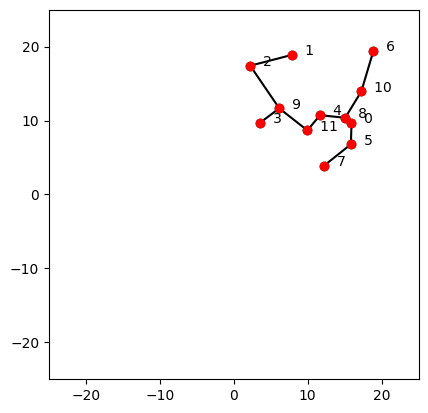

New arc centre
[0.8246717069517869, 0.44031795472054175]
New pseudo
[0.9281278375528892, 0.4626279791706239]
New arc radius
0.1058343429606647
New angles
[2.830388556618443, 3.877586107815041, 2.3067897810201443, 4.40118488341334]

Start bottleneck prune!
No need to do anything for P as min dist is 2.8578084126803267 and current distances is 0.18331045919354075
No need to do anything for Q as min dist is 2.8578084126803267 and current distances is 0.18331045919354078
Bottleneck angles
[2.830388556618443, 3.8775861078150404, 2.3067897810201443, 4.401184883413339]

Begin lune prune
Initial max opening pre lune test of 2.0943951023931944
Look at moving p_i
No further lune violations, stopping!
Look at moving q_i
No further lune violations, stopping!

Begin lune prune
Initial max opening pre lune test of 0.8698237743999053
Look at moving p_i
No further lune violations, stopping!
Look at moving q_i
No further lune violations, stopping!


In [29]:
# Debugging
# terminals = [[4.15, -7.71], [5.57, -1.37], [7.7, 11.81], [14.98, -12.06], [-12.39, -14.86], [9.45, 12.04], [2.45, 13.48], [-0.49, 13.24], [-8.04, 14.36], [-8.22, 11.23], [-9.91, 14.95], [6.99, 0.01], [-12.54, -3.93], [2.93, 12.66]]
# labels = [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
terminals = [[0.7963178498944239, 0.4824002292949805], [0.39502971668407527, 0.9446591745895792], [0.111298307135692, 0.870994465769593], [0.17676394856786704, 0.4844911179239806], [0.5832285336584604, 0.5364588144668552], [0.7922646895840589, 0.3395673052177055], [0.9441261235402427, 0.9701614060530691], [0.6094061016148473, 0.19374716961959104], [0.7536225937184127, 0.5187585797732959], [0.30781217250197845, 0.5826935689460324], [0.862890110148794, 0.6972217584319098], [0.498046186794162, 0.433252112878024]]
# terminals = [[13.32, 7.99], [5.14, 10.95], [-10.57, 12.19], [5.3, -1.55], [8.52, -0.04], [8.45, -12.68]]
# labels = [2, 2, 2, 2, 2, 0]

for terminal in terminals:
    terminal[0] = 20 * terminal[0]
    terminal[1] = 20 * terminal[1]
    

branches = [[[[terminals[t][0], terminals[t][1], t, -1]], [terminals[t][0], terminals[t][1]], [terminals[t][0], terminals[t][1], 0, 0, 0, 0, 0], [t], 0, False] for t in range(len(terminals))]
savedEdges = kruskalMST(terminals)
bst = bottleneckSteinerDistance(terminals, savedEdges)
plot_tree([terminals, savedEdges], terminals)

# first_merge = double_merge(branches[3], branches[2], useBottleneckPrune = True, bst = bst)
# for branch in first_merge:
#     plot_branch(branch)
#     print(branch)

# b1 = first_merge[0]

# b2 = double_merge(b1, branches[1], useBottleneckPrune = True, bst = bst)
# plot_branch(b2)
# print(b2)


b1 = [[[0.7536225937184127, 0.5187585797732959, 8, -1]], [0.7536225937184127, 0.5187585797732959], [0.7536225937184127, 0.5187585797732959, 0, 0, 0, 0, 0], [8], 0, False]
b2 = [[[0.7922646895840589, 0.3395673052177055, 5, -1]], [0.7922646895840589, 0.3395673052177055], [0.7922646895840589, 0.3395673052177055, 0, 0, 0, 0, 0], [5], 0, False]

double_merge(b1, b2, pruningVersion = 1, bst = bst, terminals = terminals)





b1 = [[[0.7536225937184127, 0.5187585797732959, 8, -1]], [0.7536225937184127, 0.5187585797732959], [0.7536225937184127, 0.5187585797732959, 0, 0, 0, 0, 0], [8], 0]
b2 = [[[0.7922646895840589, 0.3395673052177055, 5, -1]], [0.7922646895840589, 0.3395673052177055], [0.7922646895840589, 0.3395673052177055, 0, 0, 0, 0, 0], [5], 0]
new_pseudo = [0.9281278375528892, 0.4626279791706239]
new_pseudo = [0.9281278375528892, 0.4626279791706239]
new_arc_centre = [0.8246717069517869, 0.44031795472054175]
new_arc_centre = [0.8246717069517869, 0.44031795472054175]
new_arc_radius = 0.1058343429606647
new_arc_radius = 0.1058343429606647
prunedAngles = [3.1365313886167656, 3.5714432758167183, 2.9190754450167895, 3.788899219416695]
prunedAngles = [3.1365313886167656, 3.5714432758167183, 2.9190754450167895, 3.788899219416695]
prunedAngles = lune_prune(b1, b2, new_pseudo, new_arc_centre, new_arc_radius, prunedAngles, terminals)


# [intersectPrune, costPrune] = find_two_trees(terminals, labels, useBottleneckPrune = True)
# [intersectNonePrune, costNonePrune] = find_two_trees(terminals, labels)


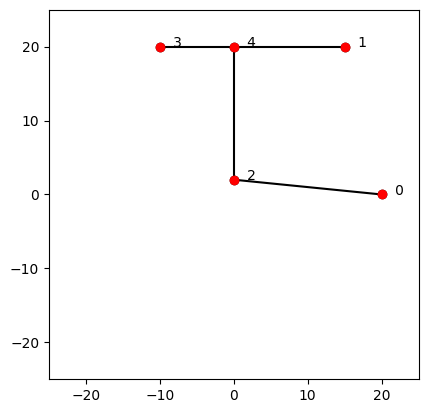

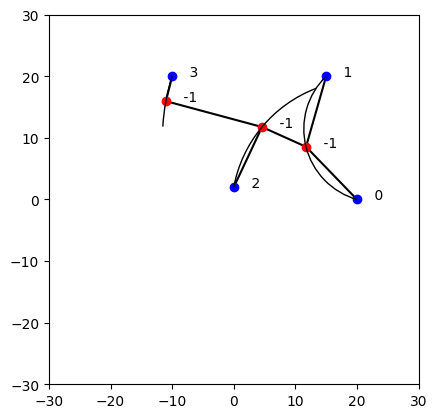

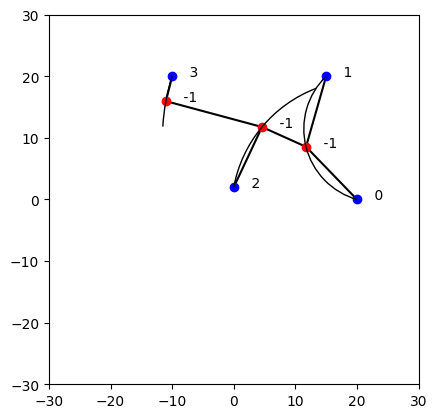

Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5


In [7]:
terminals = [[20, 0], [15, 20], [0, 2], [-10, 20], [0, 20]]
branches = [[[[terminals[t][0], terminals[t][1], t, -1]], [terminals[t][0], terminals[t][1]], [terminals[t][0], terminals[t][1], 0, 0, 0, 0, 0], [t], 0, False] for t in range(len(terminals))]
savedEdges = kruskalMST(terminals)
plot_tree([terminals, savedEdges], terminals)
bst = bottleneckSteinerDistance(terminals, savedEdges)

plot_branch(double_merge(branches[3], double_merge(double_merge(branches[1], branches[0]), branches[2])))

plot_branch(double_merge(branches[3], double_merge(double_merge(branches[1], branches[0]), branches[2]), useBottleneckPrune = True, bst = bst))


# plot_branch(double_merge(double_merge(branches[3], double_merge(branches[4], branches[1])), branches[0], useBottleneckPrune = True, bst = bst))


# plot_branch(double_merge(double_merge(branches[1], branches[0]), branches[3], useBottleneckPrune = True, bst = bst))


# plot_branch(double_merge(double_merge(branches[3], branches[4]), double_merge(branches[1], branches[0]), useBottleneckPrune = True, bst = bst))

# plot_branch(double_merge(double_merge(double_merge(branches[4], branches[3]), double_merge(branches[1], branches[0]), useBottleneckPrune = True, bst = bst))
# plot_branch(double_merge(double_merge(branches[3], branches[4]), double_merge(branches[1], branches[0])))

trees = find_full_steiner_trees(terminals, useTripleMerge = False, showOutput = True, allowSameTerminals = False, useBottleneckPrune = True)
# for tree in trees:
#     plot_tree(tree, terminals)

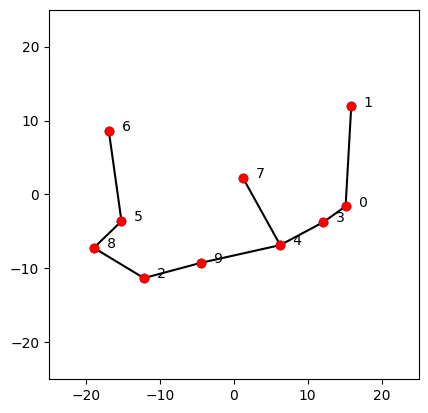

Done!


In [3]:
# Small aside, will implement bottleneck prune
# This means need to construct Minimum Spanning Tree, and then find paths for every pair of vertices
# Going to do my own implmenetation of Kruskal's algorithm
# Note that this is not done super efficiently, but for the sizes we are dealing with it should be very
def kruskalMST(terminals):
    # First want to add all potential edges, based on the distance, to a list
    potentialEdges = [[i, j, dist(terminals[i], terminals[j])] for i in range(len(terminals)) for j in range(i)]
    sorted_list= sorted(potentialEdges, key=lambda x: x[2])
    potentialEdges = sorted_list
    # Now want a list of trees which will be merging when adding edges
    groups = [i for i in range(len(terminals))]
    nGroups = len(terminals)
    savedEdges = []
    while nGroups > 1:
        edge = potentialEdges[0]
        potentialEdges.pop(0)
        if groups[edge[0]] == groups[edge[1]]:
            continue
        # Edge is good, save it, change groups
        nGroups = nGroups - 1
        savedEdges.append(edge)
        oldGroup = groups[edge[0]]
        newGroup = groups[edge[1]]
        for i in range(len(groups)):
            if groups[i] == oldGroup:
                groups[i] = newGroup
    return savedEdges

def bsdDepthSearch(terminals, startTerminal, currentTerminal, visited, adjacency, bst, longestDist):
    # First store the longest dist to this terminal
    bst[startTerminal][currentTerminal] = longestDist
    visited[currentTerminal] = True
    # Look at all the neighbours that have not yet been visited
    for j in adjacency[currentTerminal]:
        if visited[j]:
            continue
        # Will want to go to this terminal next, check if the distance is longer than current longest
        localDist = dist(terminals[currentTerminal], terminals[j])
        if localDist > longestDist:
            bsdDepthSearch(terminals, startTerminal, j, visited, adjacency, bst, localDist)
        else:
            bsdDepthSearch(terminals, startTerminal, j, visited, adjacency, bst, longestDist)
    
def bottleneckSteinerDistance(terminals, edges):
    # First of all, define adjacency list in the form of neighbours
    adjacency = [[] for i in range(len(terminals))]
    for edge in edges:
        adjacency[edge[0]].append(edge[1])
        adjacency[edge[1]].append(edge[0])
    # For each starting vertex, do a depth first search where the longest edge is stored
    bst = [ [0]*len(terminals) for i in range(len(terminals))]
    for i in range(len(terminals)):
        visited = [False for j in range(len(terminals))]
        visited[i] = True
        for j in adjacency[i]:
            longestDist = dist(terminals[i], terminals[j])
            bsdDepthSearch(terminals, i, j, visited, adjacency, bst, longestDist)
    # for i in range(len(terminals)):
    #     for j in range(len(terminals)):
    #         print(i, ",", j, ":", bst[i][j])
    return bst
            

n = 10
terminals = [[round(random.uniform(-20, 20), 2),round(random.uniform(-15, 15), 2)] for t in range(n)]
savedEdges = kruskalMST(terminals)
plot_tree([terminals, savedEdges], terminals)

# Ok so now have the edges, now want to find the bottleneck distance for every pair of terminals
bst = bottleneckSteinerDistance(terminals, savedEdges)
print("Done!")

Working on 2 terminals, 1 sinks, 1 sources and rep 0
[[13.94, -10.8], [4.61, -14.3]]
[2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Have 0 pairs of trees (i.e. hyperedges) which intersect!
Set parameter LazyConstraints to value 1
Found heuristic solution of cost 9.964883341013078 in 0.0 s, by adding edge to MStT solution


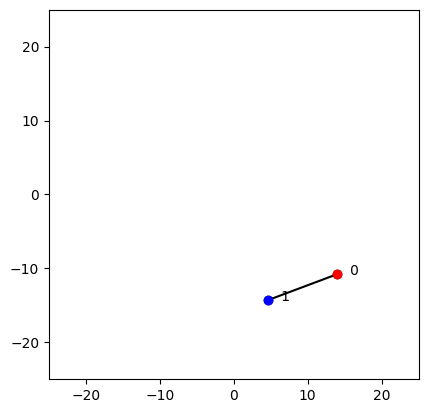

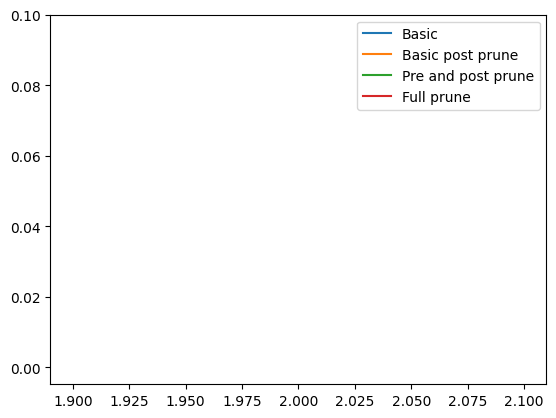

Working on 3 terminals, 1 sinks, 2 sources and rep 0
[[-13.86, 1.72], [-2.42, -4.93], [9.23, -0.33]]
[2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Have 0 pairs of trees (i.e. hyperedges) which intersect!
Set parameter LazyConstraints to value 1
Found heuristic solution of cost 25.757662743481916 in 0.003803253173828125 s, by adding edge to MStT solution


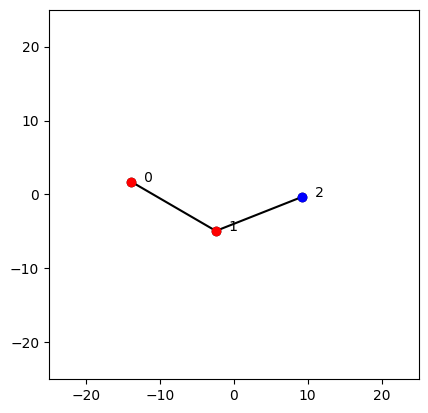

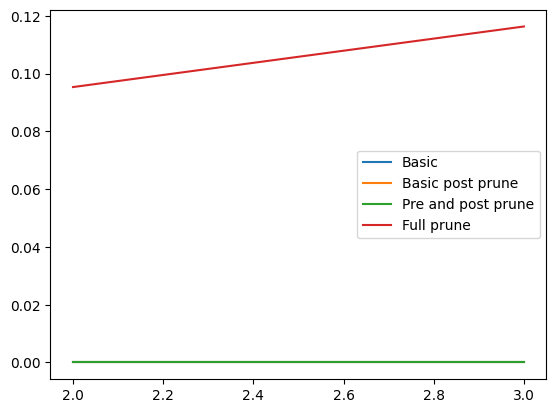

Working on 4 terminals, 1 sinks, 3 sources and rep 0
[[-3.03, -10.65], [1.68, -6.6], [-13.84, -5.51], [15.0, -1.04]]
[2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.004174709320068359 s
Have 0 pairs of trees (i.e. hyperedges) which intersect!
Set parameter LazyConstraints to value 1
Found heuristic solution of cost 32.59210786566463 in 0.0009965896606445312 s, by adding edge to MStT solution


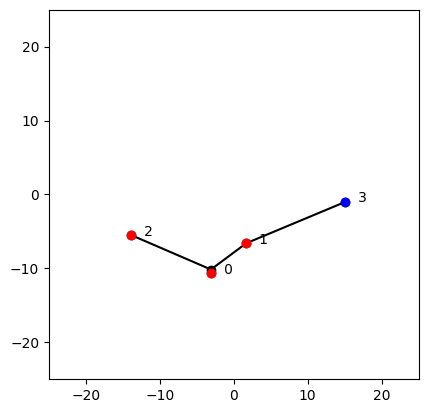



Working on 4 terminals, 2 sinks, 2 sources and rep 0
[[-12.3, -0.41], [1.55, 1.68], [-13.24, 7.29], [-0.83, 13.64]]
[2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.000997781753540039 s
Have 0 pairs of trees (i.e. hyperedges) which intersect!
Set parameter LazyConstraints to value 1
Found heuristic solution of cost 35.7042209929237 in 0.001804351806640625 s, by adding edge to MStT solution


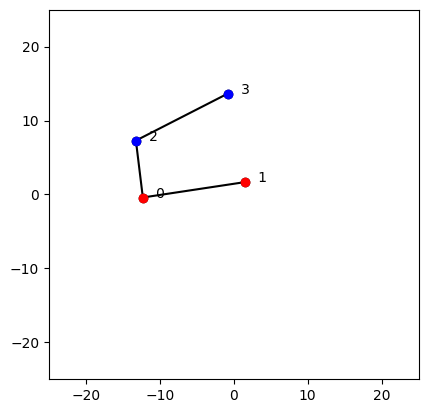

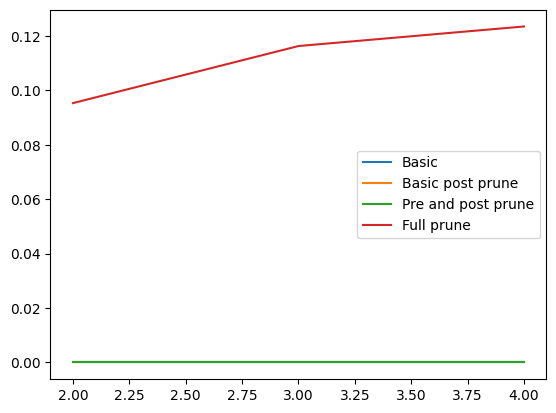

Working on 5 terminals, 1 sinks, 4 sources and rep 0
[[0.42, -11.78], [-0.92, 0.51], [-11.22, 13.67], [10.57, 8.26], [2.81, -14.32]]
[2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 9 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 9 trees, pruned in 0.014371871948242188 s
Have 0 pairs of trees (i.e. hyperedges) which intersect!
Set parameter LazyConstraints to value 1
Found heuristic solution of cost 45.647746475423794 in 0.0019936561584472656 s, by add

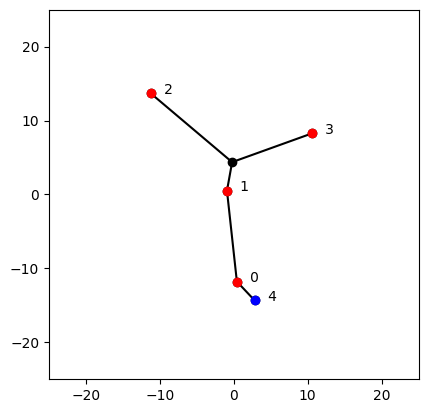



Working on 5 terminals, 2 sinks, 3 sources and rep 0
[[-0.92, -14.93], [12.76, 7.45], [-14.4, 0.53], [2.1, -4.19], [-12.37, 2.44]]
[2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.006739616394042969 s
Have 2 pairs of trees (i.e. hyperedges) which intersect!
Set parameter LazyConstraints to value 1
Found heuristic solution of cost 58.764995097086874 in 0.002096891403198242 s, by forcing 

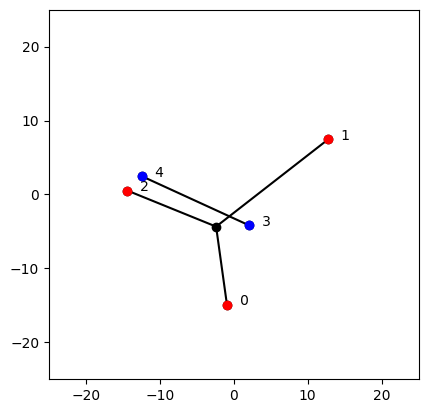

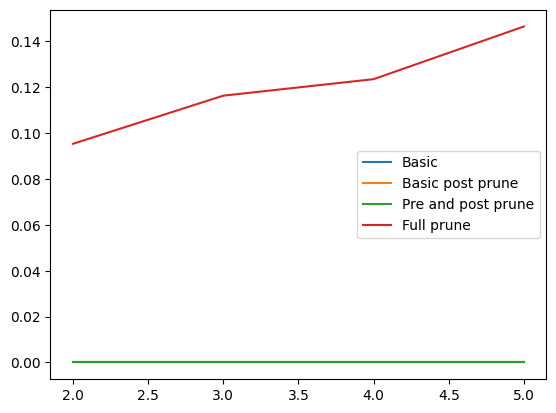

Working on 6 terminals, 1 sinks, 5 sources and rep 0
[[-12.21, 4.85], [-9.3, 10.48], [3.8, -8.51], [5.22, -4.55], [-0.18, 10.78], [4.68, 6.93]]
[2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Pre prune have 24 trees, found in 0.061463356018066406 s
Removed  0.0 % of trees due to self intersections
Removed further  4.166666666666667 % of trees due

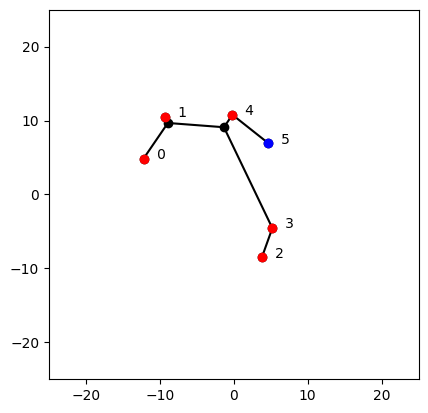



Working on 6 terminals, 2 sinks, 4 sources and rep 0
[[10.33, 2.82], [-4.68, 1.06], [-8.05, -2.36], [-7.41, -9.67], [10.28, -9.98], [2.64, 9.28]]
[2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 8 trees, found in 0.022806644439697266 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have

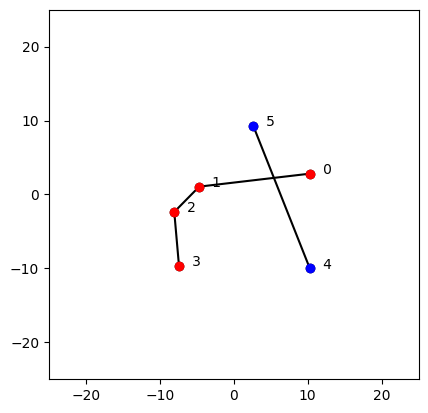



Working on 6 terminals, 3 sinks, 3 sources and rep 0
[[10.69, -14.58], [11.04, 5.88], [10.76, 6.03], [-10.47, -3.71], [2.6, -4.49], [11.93, -3.64]]
[2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 3 trees, found in 0.0009975433349609375 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 3 trees, pruned in 0.0014111995697021484 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 3 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 3 trees, pruned in 0.003917217254638672 

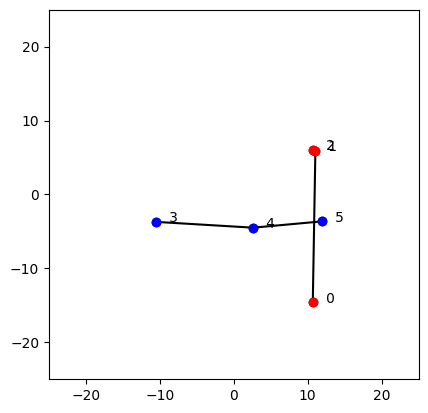

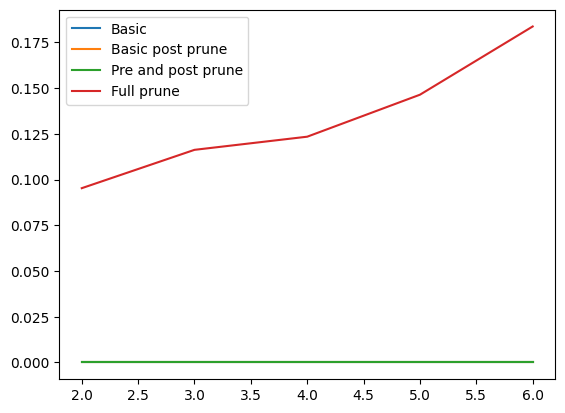

Working on 7 terminals, 1 sinks, 6 sources and rep 0
[[7.22, 8.36], [-6.93, -1.03], [-6.82, -11.06], [7.57, 9.15], [-7.76, 14.94], [-13.29, -13.66], [7.79, 10.62]]
[2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )
Joining branches of size  1  (index  0 )  and  4  (index  3 )
Joining branches of size  2

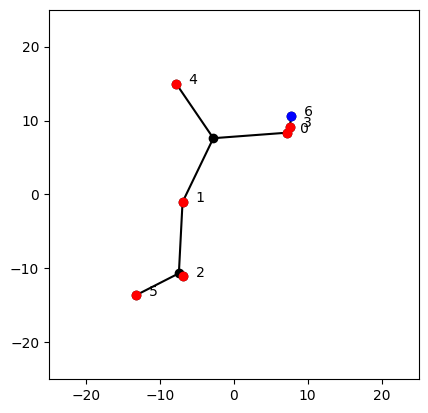



Working on 7 terminals, 2 sinks, 5 sources and rep 0
[[-12.04, 9.55], [4.74, 14.17], [13.38, -7.65], [2.88, -5.77], [-6.81, 5.93], [14.75, -12.27], [0.86, -2.65]]
[2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0009970664978027344 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining bran

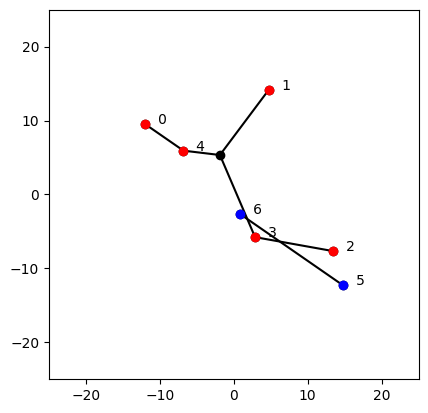



Working on 7 terminals, 3 sinks, 4 sources and rep 0
[[1.44, 11.23], [1.42, -1.09], [-2.62, 14.72], [13.57, 12.56], [7.87, -0.48], [12.0, 7.19], [8.25, -9.71]]
[2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 3 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 3 trees, pruned in 0.015623331069946289 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 8 trees, found in 0.009301185607910

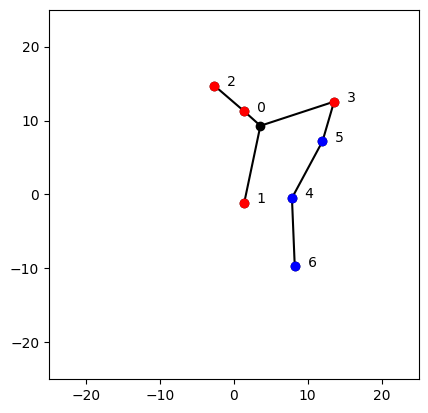

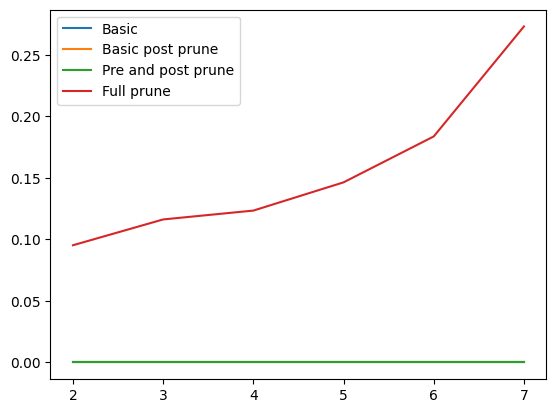

Working on 8 terminals, 1 sinks, 7 sources and rep 0
[[-2.04, -10.74], [-1.27, -8.77], [8.32, -14.13], [13.57, 6.33], [13.66, 9.26], [-9.15, 9.86], [-14.68, 14.69], [-2.92, 12.32]]
[2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )
Joining branches of size  1  (index  0 )  and  4  (index  3 )
Joining

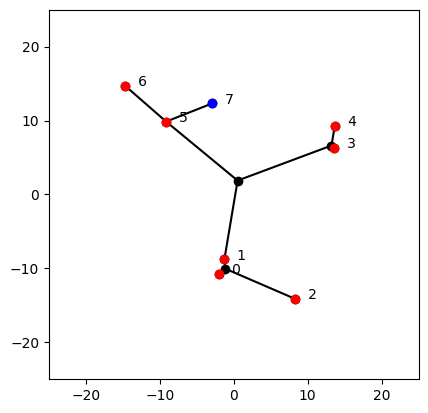



Working on 8 terminals, 2 sinks, 6 sources and rep 0
[[5.69, -8.63], [14.37, 7.31], [-9.89, 2.83], [-2.49, -9.98], [13.52, 9.16], [3.06, -0.58], [9.79, 0.66], [-7.51, 11.27]]
[2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branche

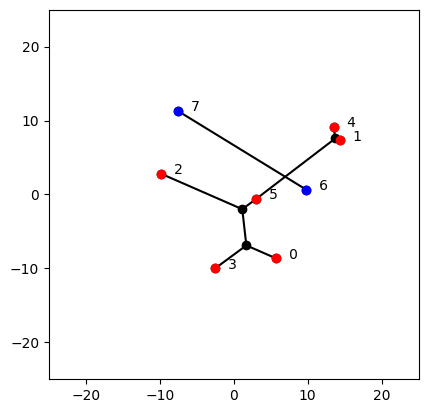



Working on 8 terminals, 3 sinks, 5 sources and rep 0
[[-2.34, -7.17], [9.72, 9.68], [10.91, -13.73], [8.23, 5.62], [2.47, 11.86], [8.69, -13.49], [-13.11, 9.59], [-12.1, -4.17]]
[2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Jo

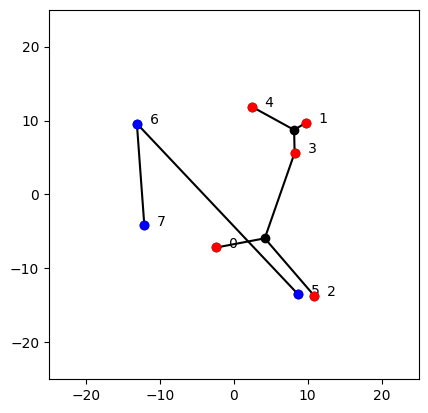



Working on 8 terminals, 4 sinks, 4 sources and rep 0
[[3.6, -1.52], [10.69, 6.33], [-7.1, 2.02], [-1.11, -11.54], [2.08, 14.58], [14.5, 5.64], [-7.2, -13.2], [-4.75, 7.4]]
[2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 10 trees, found in 0.010148763656616211 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 10 trees, pruned in 0.008607864379882812 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branc

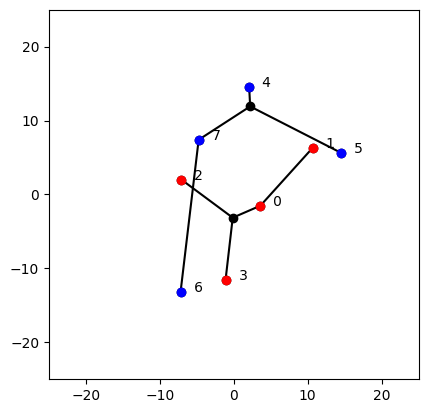

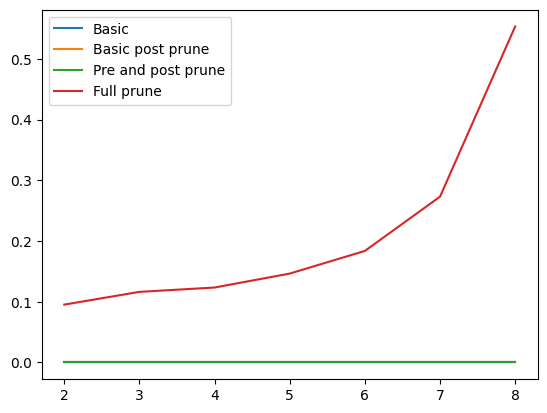

Working on 9 terminals, 1 sinks, 8 sources and rep 0
[[8.59, 13.06], [6.16, 8.76], [-1.03, -9.85], [10.64, -7.04], [-2.59, 0.51], [5.37, 2.06], [11.53, -11.39], [2.95, -9.75], [-12.98, 12.47]]
[2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )
Joining branches of size  1  (index  0 )  and  4  (ind

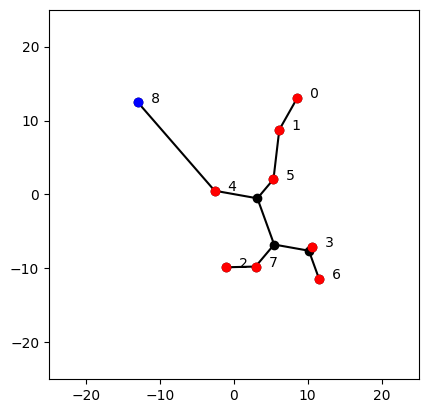



Working on 9 terminals, 2 sinks, 7 sources and rep 0
[[1.51, 3.45], [9.18, 13.06], [-7.04, 13.39], [-10.93, -0.95], [-9.13, -1.62], [-0.01, 8.93], [10.63, 4.48], [-14.48, 6.05], [7.4, 8.45]]
[2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  

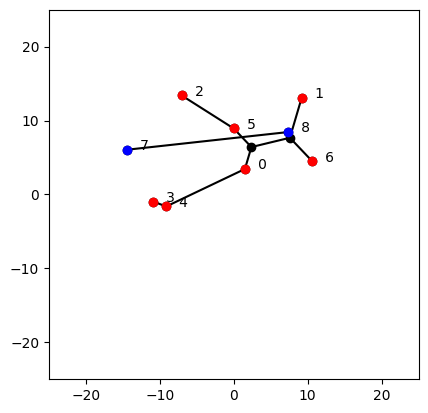



Working on 9 terminals, 3 sinks, 6 sources and rep 0
[[14.18, -4.78], [7.92, -6.16], [12.15, -2.14], [11.79, 13.75], [-13.45, -1.16], [12.95, 11.47], [9.8, 9.37], [7.07, -13.32], [-2.72, 0.13]]
[2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.007217884063720703 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating

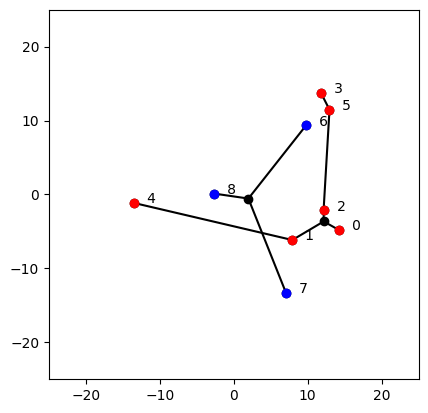



Working on 9 terminals, 4 sinks, 5 sources and rep 0
[[-0.22, -10.69], [-3.66, -7.43], [-7.42, 14.74], [-7.11, 5.5], [9.93, -11.49], [-0.92, 9.94], [9.57, 11.44], [14.14, 12.44], [-5.99, -4.18]]
[2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 8 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 8 trees, pruned in 0.01695990562438965 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating

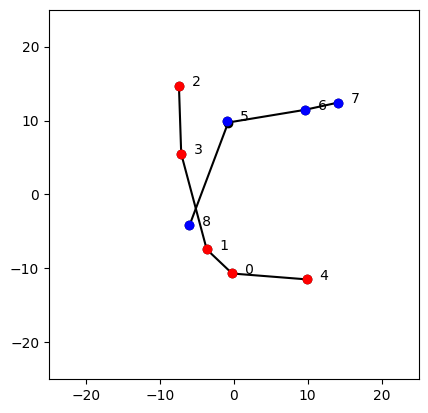

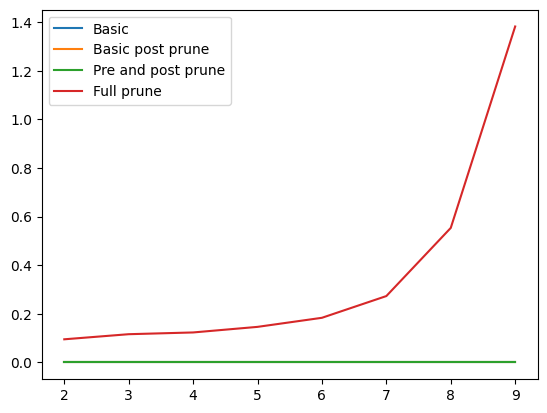

Working on 10 terminals, 1 sinks, 9 sources and rep 0
[[13.13, -13.72], [-5.21, -13.14], [-9.46, -0.88], [-14.64, 10.31], [8.94, 5.3], [12.4, -6.0], [8.03, 7.3], [-4.45, 7.97], [2.78, -6.21], [4.32, 8.35]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )
Joining branches of size  1  (index  0

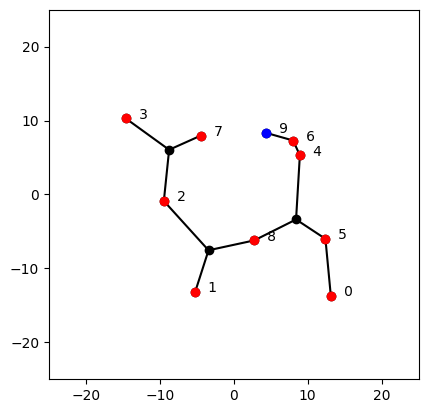



Working on 10 terminals, 2 sinks, 8 sources and rep 0
[[-11.95, 13.84], [5.3, 2.78], [-4.72, 13.09], [-11.46, -1.05], [2.32, -3.42], [7.32, 0.62], [-14.46, 7.88], [-10.25, -3.87], [13.08, 11.7], [6.23, -12.98]]
[2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index

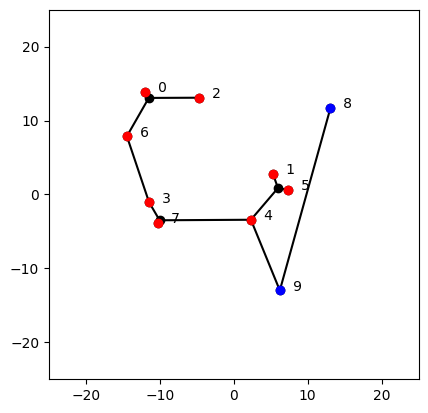



Working on 10 terminals, 3 sinks, 7 sources and rep 0
[[11.65, -13.08], [7.93, 2.57], [-1.44, -12.34], [-3.97, 6.68], [8.61, 0.43], [-9.82, -10.72], [10.55, -3.26], [5.46, -7.94], [7.38, -7.23], [-3.86, 2.58]]
[2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generati

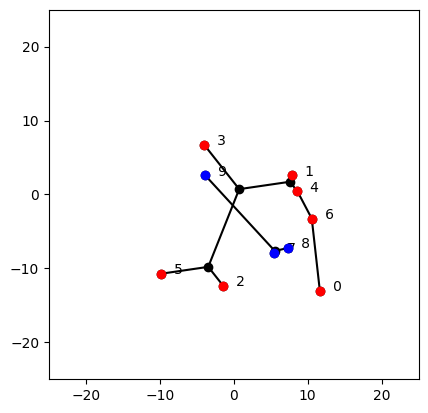



Working on 10 terminals, 4 sinks, 6 sources and rep 0
[[-0.05, -12.91], [-12.3, -14.78], [0.87, -11.36], [-4.05, -7.94], [-9.53, 5.34], [-10.9, 0.26], [13.97, 5.14], [-10.04, -6.48], [-0.55, -11.01], [-0.31, -4.2]]
[2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 8 trees, found in 0.007893562316894531 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 8 trees, pruned in 0.0057375431060791016 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  

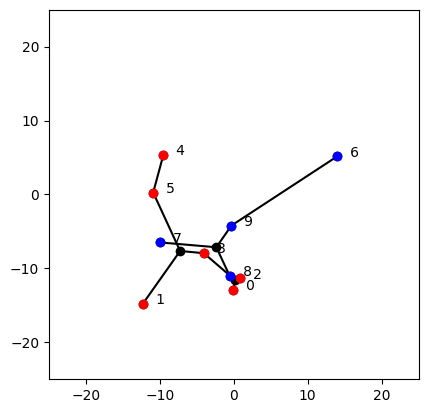



Working on 10 terminals, 5 sinks, 5 sources and rep 0
[[-6.65, -11.37], [9.85, 8.7], [-14.5, 8.91], [-12.37, -1.78], [-8.66, 10.0], [3.21, -2.42], [-2.91, 0.41], [-11.28, 8.97], [3.97, -5.85], [5.24, -12.53]]
[2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Pre prune have 10 trees, found in 0.03021717071533203 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees du

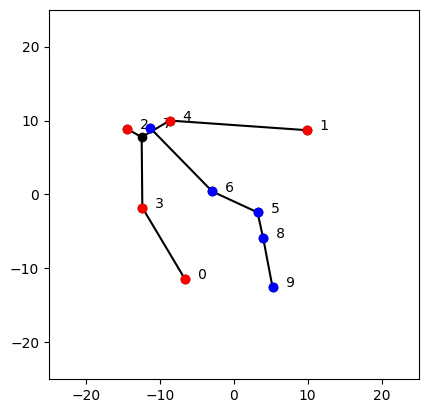

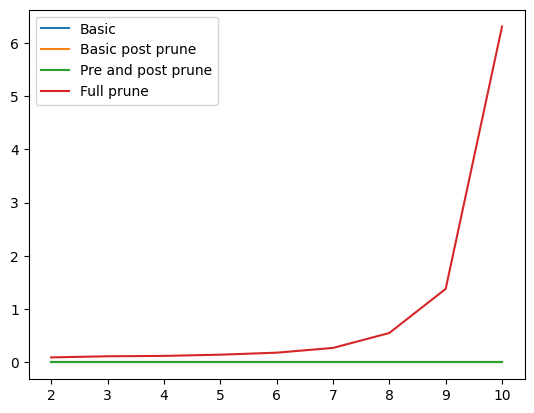

Working on 11 terminals, 1 sinks, 10 sources and rep 0
[[-10.86, 1.83], [-1.13, -12.66], [-3.96, 10.64], [-2.46, -14.94], [7.74, -12.22], [-1.43, 5.0], [13.62, 11.85], [-13.21, -11.31], [-12.41, 2.28], [-8.97, 10.35], [14.63, 10.99]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )
Joining

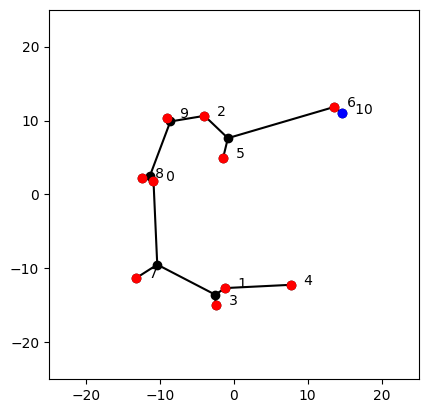



Working on 11 terminals, 2 sinks, 9 sources and rep 0
[[-4.9, 8.27], [-10.42, 7.72], [-11.05, -1.26], [8.52, 9.51], [13.84, 8.14], [-4.39, -3.76], [6.22, 1.12], [6.47, 1.32], [-9.81, -8.25], [1.07, -8.36], [7.23, -13.27]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of s

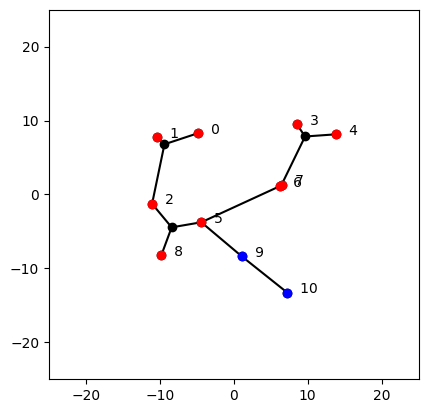



Working on 11 terminals, 3 sinks, 8 sources and rep 0
[[7.19, 11.27], [-13.96, -4.42], [13.76, 13.62], [11.39, -0.8], [-10.8, -14.03], [3.49, 0.74], [11.19, -3.39], [8.63, 5.97], [3.23, -9.25], [-2.56, 9.39], [-6.56, 12.95]]
[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 3 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 3 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees o

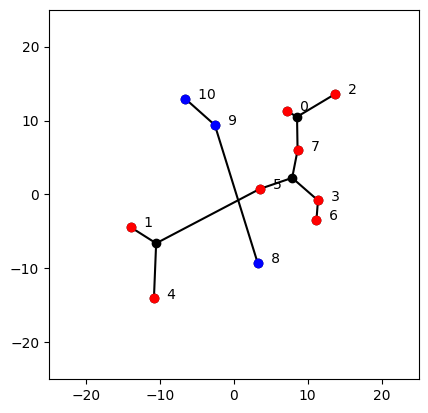



Working on 11 terminals, 4 sinks, 7 sources and rep 0
[[-4.04, -14.5], [9.5, 2.56], [-5.22, 4.12], [14.78, 9.63], [14.54, -3.33], [10.02, 11.12], [6.44, -14.69], [6.62, 0.41], [13.45, -6.82], [13.77, -6.69], [14.63, 4.19]]
[2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 9 trees, found in 0.009582757949829102 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 9 trees, pruned in 0.004924774169921875 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1

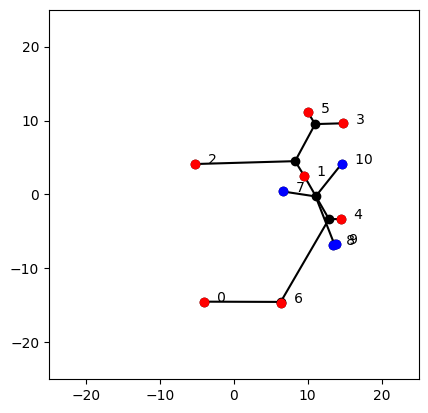



Working on 11 terminals, 5 sinks, 6 sources and rep 0
[[3.37, 8.11], [-5.73, -14.13], [6.2, -10.38], [-14.49, -9.95], [12.69, 14.42], [2.21, -3.39], [11.87, 3.11], [5.29, 14.37], [-14.24, 4.54], [-14.1, 14.4], [2.45, 11.77]]
[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Pre prune have 17 trees, found in 0.03405284881591797 s
Removed  0.0 % of trees due to self intersections
Removed further

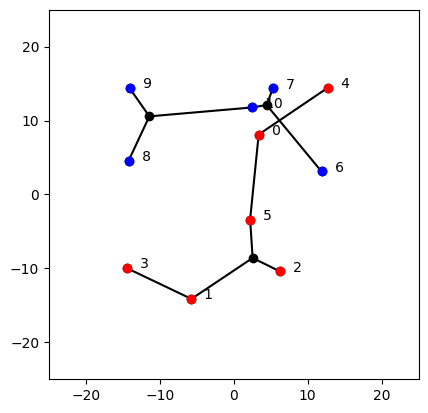

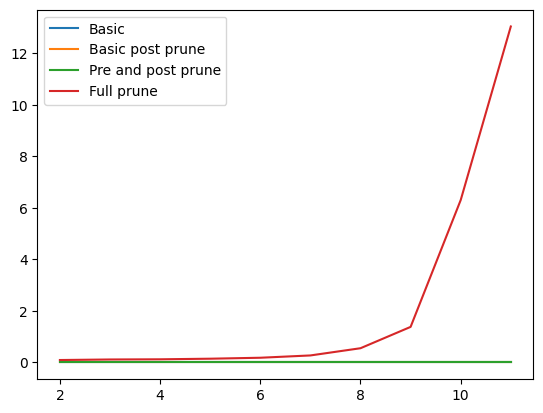

Working on 12 terminals, 1 sinks, 11 sources and rep 0
[[9.31, 3.94], [11.4, 14.25], [12.38, 14.11], [3.45, 8.9], [8.65, 0.83], [8.39, 6.2], [-7.19, -5.0], [-4.28, 7.72], [14.35, -14.16], [-12.35, 8.13], [12.9, -13.63], [-8.92, -2.72]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )
Jo

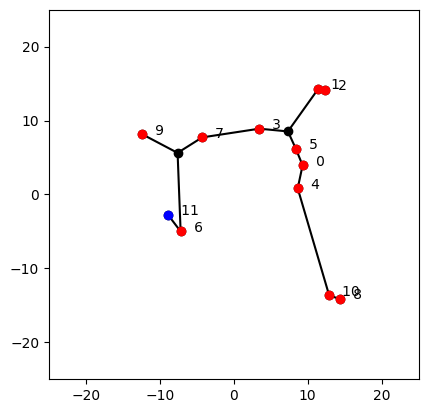



Working on 12 terminals, 2 sinks, 10 sources and rep 0
[[-1.31, 7.08], [9.42, 9.18], [4.44, -1.21], [-14.62, 13.13], [-3.2, -2.23], [6.05, -7.81], [2.33, -0.47], [-2.5, -5.05], [-1.75, -10.61], [4.37, -3.46], [10.14, -4.74], [8.49, 6.19]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
J

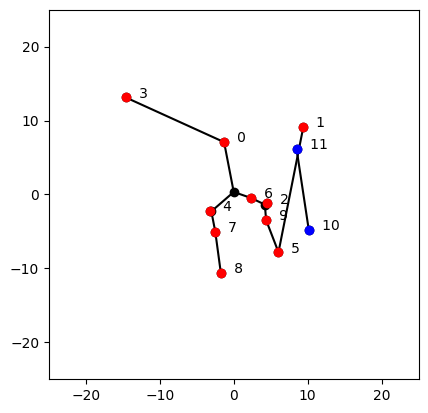



Working on 12 terminals, 3 sinks, 9 sources and rep 0
[[-1.08, 13.41], [-4.77, 14.73], [8.86, 13.83], [-9.37, -13.82], [-14.98, -13.92], [14.1, -2.0], [-7.08, 12.81], [-12.87, -0.48], [9.25, 14.39], [14.63, 0.43], [-9.88, 13.34], [2.78, -2.97]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index 

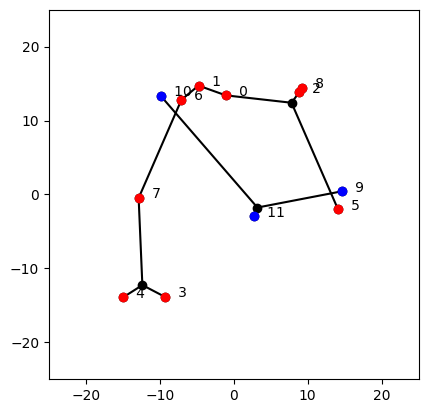



Working on 12 terminals, 4 sinks, 8 sources and rep 0
[[-4.51, 12.27], [-11.49, 2.65], [11.67, -7.46], [-3.86, -4.5], [12.9, 2.16], [3.58, -4.96], [14.44, -10.33], [-9.4, -6.53], [-7.56, 0.6], [8.03, -14.86], [9.7, 6.41], [-1.48, -3.56]]
[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 9 trees, found in 0.013939142227172852 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 9 trees, pruned in 0.007158517837524414 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (

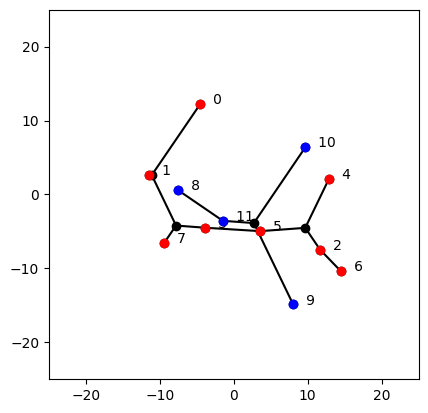



Working on 12 terminals, 5 sinks, 7 sources and rep 0
[[-1.51, 7.24], [10.73, 3.24], [0.27, -4.03], [-5.21, -2.0], [-5.07, 12.85], [0.84, -2.37], [-11.96, 11.6], [-2.22, 7.41], [-14.27, 1.81], [14.66, -8.03], [12.22, 8.05], [5.75, 9.95]]
[2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Pre prune have 18 trees, found in 0.030354976654052734 s
Removed  0.0 % of trees due to self intersection

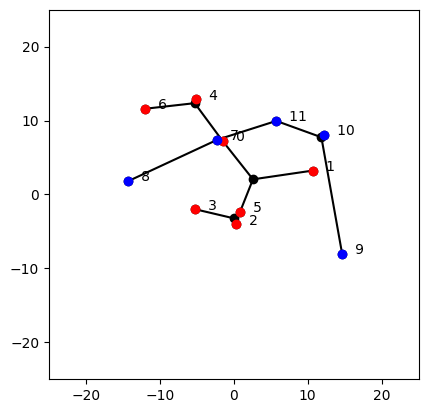



Working on 12 terminals, 6 sinks, 6 sources and rep 0
[[-2.14, 9.11], [-14.83, 1.04], [0.3, 2.65], [-8.68, -5.26], [9.39, -11.2], [10.73, -5.83], [-10.87, -14.29], [7.17, -2.59], [-4.79, -1.51], [-2.46, -5.53], [-10.11, -12.6], [7.38, 0.65]]
[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )
Joining branches of size  1  (index  0 )  and  4  (index 

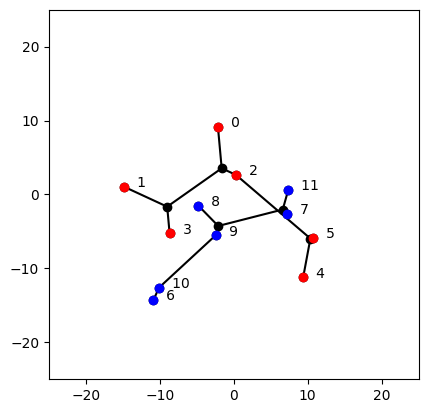

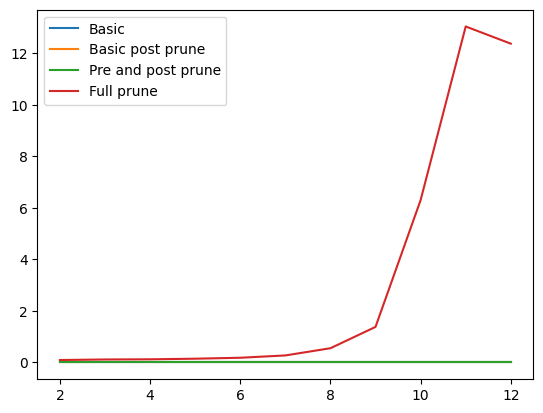

Working on 13 terminals, 1 sinks, 12 sources and rep 0
[[8.58, 4.84], [12.94, 6.05], [-3.45, -2.89], [8.1, 4.88], [-7.29, -13.67], [13.23, -11.53], [14.41, 12.75], [-0.59, 0.27], [-8.09, -1.47], [-10.51, -6.1], [-9.91, 3.87], [5.58, -5.44], [6.09, -12.89]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of

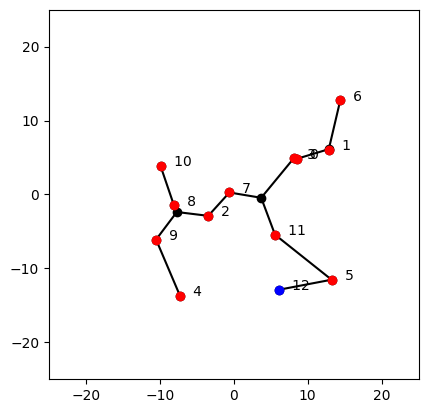



Working on 13 terminals, 2 sinks, 11 sources and rep 0
[[2.52, -4.68], [-2.99, -3.34], [12.27, -11.33], [10.09, 4.01], [13.22, -9.89], [4.01, -3.93], [6.1, -4.62], [-2.69, -1.22], [-10.68, -0.71], [-14.83, 11.33], [12.26, -3.22], [-12.9, 12.71], [-7.12, 14.76]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  

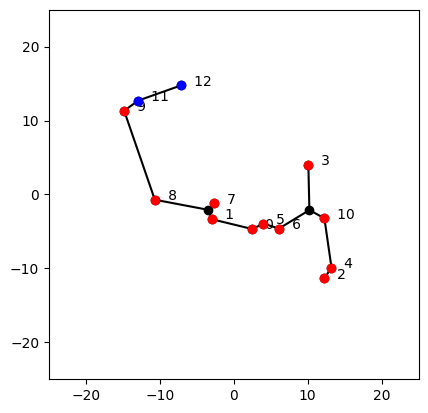



Working on 13 terminals, 3 sinks, 10 sources and rep 0
[[8.21, 7.78], [3.68, 9.98], [-12.52, 4.9], [-11.69, -1.82], [-12.94, -0.58], [11.94, -9.98], [10.89, -4.97], [11.27, 1.69], [-3.51, 1.42], [10.03, -7.66], [9.59, 6.51], [-5.5, 13.56], [11.55, 5.63]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 3 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 3 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  an

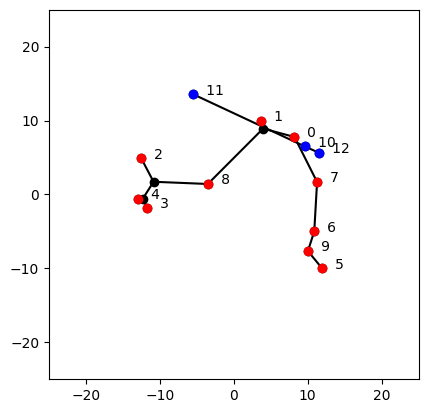



Working on 13 terminals, 4 sinks, 9 sources and rep 0
[[-12.22, 2.91], [-1.45, 14.33], [-10.52, 7.34], [5.86, -5.23], [-10.83, 4.78], [6.22, 11.58], [-13.44, -11.31], [-5.69, -7.13], [-9.2, -1.58], [0.08, 0.16], [11.27, -4.52], [3.47, 7.9], [13.01, -5.89]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 8 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 8 trees, pruned in 0.016643285751342773 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size 

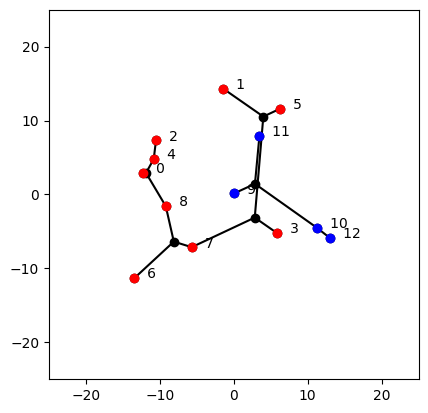



Working on 13 terminals, 5 sinks, 8 sources and rep 0
[[4.45, -4.81], [7.51, 4.72], [-5.03, -1.66], [11.14, -2.43], [-1.19, 3.23], [4.02, 4.33], [0.74, 7.15], [5.4, -1.25], [2.82, 11.8], [-10.87, 13.26], [8.74, 5.22], [-3.03, -10.57], [10.62, 5.6]]
[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Pre prune have 17 trees, found in 0.046898603439331055 s
Removed  0.0 % of trees due to sel

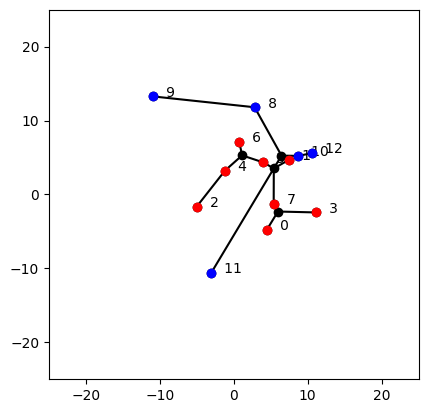



Working on 13 terminals, 6 sinks, 7 sources and rep 0
[[0.05, -3.03], [-13.81, 1.46], [-9.62, 10.79], [-0.95, -9.69], [13.92, -6.62], [-9.99, -2.43], [4.79, -3.46], [-9.45, 10.84], [7.27, 3.58], [-10.05, -11.21], [-13.81, -4.17], [-10.61, -1.21], [-10.57, -2.04]]
[2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )
Joining branches of size  1  (in

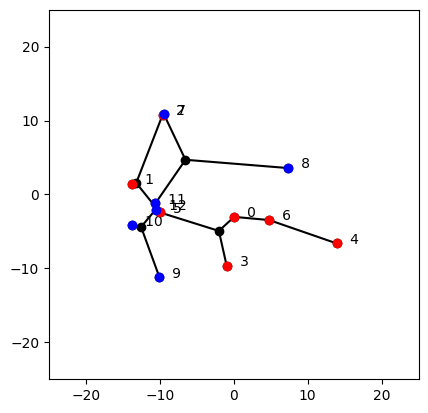

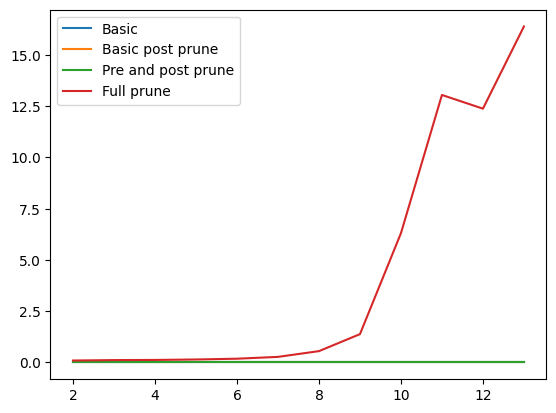

Working on 14 terminals, 1 sinks, 13 sources and rep 0
[[10.87, -2.07], [-8.55, -2.09], [9.7, 8.35], [5.61, -8.4], [9.67, -12.84], [-2.76, 0.01], [12.45, -4.34], [-6.72, 3.57], [-10.82, -12.48], [2.71, 10.01], [-3.18, 5.76], [14.94, 10.65], [9.21, -14.24], [-7.0, -1.22]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Gene

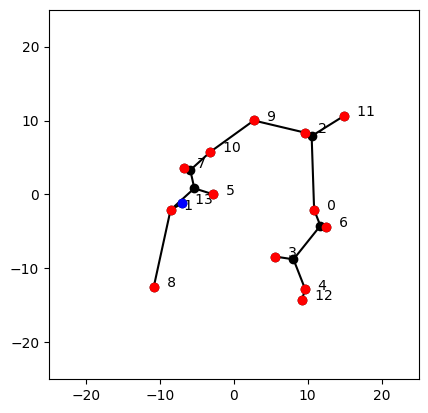



Working on 14 terminals, 2 sinks, 12 sources and rep 0
[[11.97, 0.14], [5.24, 9.15], [-0.32, 0.5], [3.35, 3.71], [2.6, 14.31], [-0.5, -3.28], [-7.47, 1.45], [12.25, 11.25], [-6.78, 5.33], [-14.76, -6.24], [-12.36, -11.25], [-7.32, -9.64], [-8.87, 0.73], [5.27, 0.72]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1 

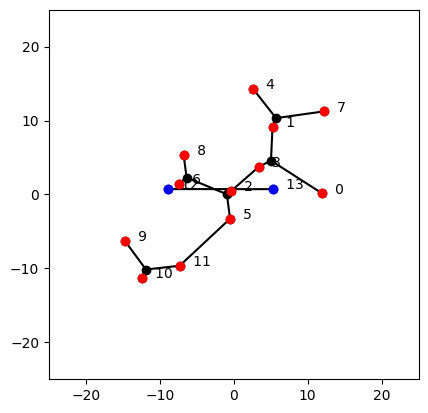



Working on 14 terminals, 3 sinks, 11 sources and rep 0
[[2.47, 10.34], [6.5, 11.18], [7.95, 11.72], [-8.41, -12.67], [-14.96, 11.99], [1.85, -8.57], [-7.19, 4.63], [3.94, -4.74], [-14.55, -1.69], [3.21, -8.55], [6.89, 2.36], [10.45, -0.84], [4.35, -4.87], [13.18, -9.49]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size

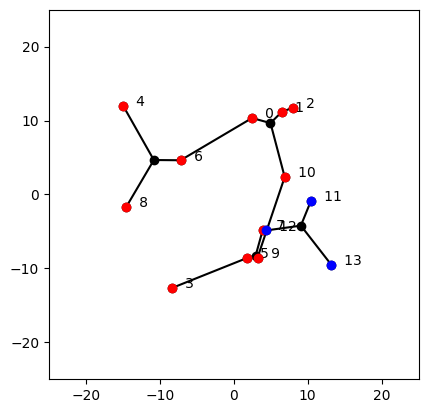



Working on 14 terminals, 4 sinks, 10 sources and rep 0
[[-1.48, -13.53], [0.99, 6.77], [5.29, -14.65], [4.58, -10.72], [-10.66, 8.57], [3.59, -12.48], [2.32, 4.9], [3.03, 5.89], [2.11, 11.02], [6.67, 6.28], [2.83, -12.17], [8.88, -4.82], [10.32, 13.89], [7.15, 12.01]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 7 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 7 trees, pruned in 0.014242172241210938 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining br

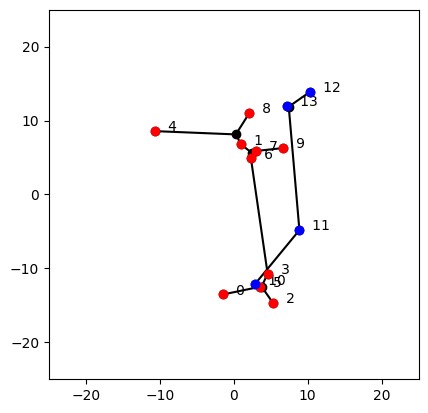



Working on 14 terminals, 5 sinks, 9 sources and rep 0
[[7.32, 1.08], [-2.86, -4.59], [1.63, 7.11], [-0.02, -4.19], [5.63, -0.19], [1.3, 12.16], [-3.24, -10.78], [-7.18, 11.92], [-5.9, -8.32], [11.46, 9.6], [12.83, 0.79], [-3.15, 1.71], [-8.56, -11.17], [7.85, -11.18]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Pre prune have 26 trees, found in 0.07719683647155762 s
Removed  0.0

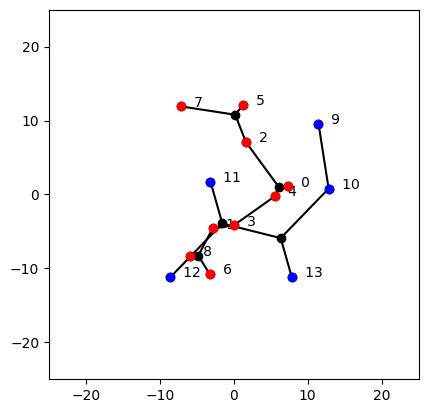



Working on 14 terminals, 6 sinks, 8 sources and rep 0
[[7.29, -0.17], [-11.02, 12.76], [14.5, -14.35], [8.01, 2.24], [11.46, -13.82], [-12.31, 14.05], [6.09, -3.51], [-11.94, -8.71], [-6.43, 14.98], [-5.28, 0.08], [-11.34, 7.53], [-13.96, 6.0], [-13.96, 7.18], [-12.33, 3.21]]
[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )
Joining branches

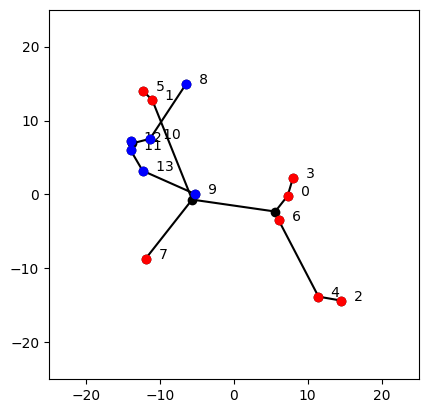



Working on 14 terminals, 7 sinks, 7 sources and rep 0
[[-5.26, -10.92], [-6.59, -11.74], [14.37, 2.82], [-9.56, -13.37], [13.15, 10.03], [3.67, 13.79], [14.74, -9.14], [1.21, 14.75], [1.29, 6.48], [-1.54, -9.49], [7.83, 2.68], [-6.02, 7.25], [-4.36, -11.76], [-11.07, 1.76]]
[2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )
Joining branches o

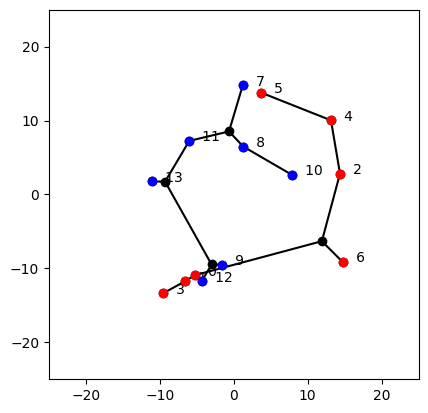

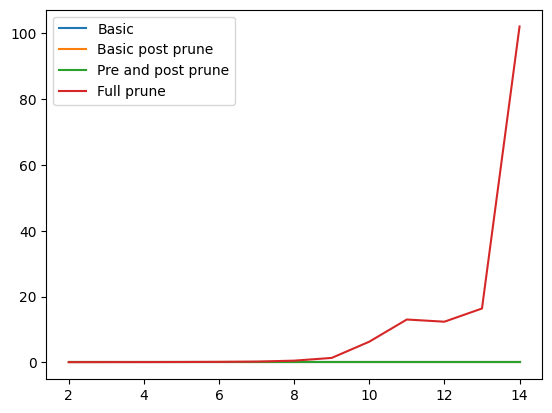

Working on 15 terminals, 1 sinks, 14 sources and rep 0
[[11.86, 1.03], [0.05, -11.78], [8.95, -0.26], [0.28, -11.82], [4.24, 7.26], [-1.56, 4.27], [0.93, -5.99], [13.88, -11.46], [6.66, -12.57], [7.92, 9.29], [3.57, 1.79], [3.78, -3.95], [-14.47, 6.78], [-7.69, 3.43], [9.7, 1.89]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of

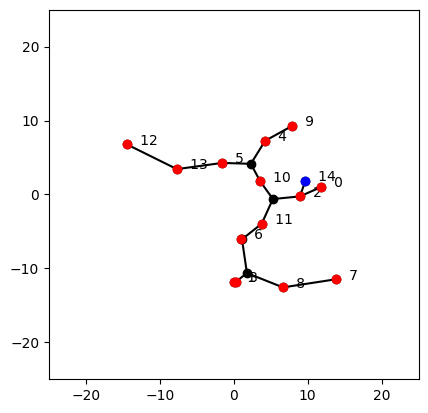



Working on 15 terminals, 2 sinks, 13 sources and rep 0
[[7.44, -7.27], [-9.73, -10.85], [12.65, -0.06], [14.72, -6.69], [-3.66, 10.47], [10.77, -14.29], [3.09, 11.38], [8.54, 7.52], [-5.35, -0.38], [14.77, 4.69], [11.39, 10.2], [8.85, 10.4], [-7.77, -0.73], [-14.33, 12.73], [9.53, 0.02]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Join

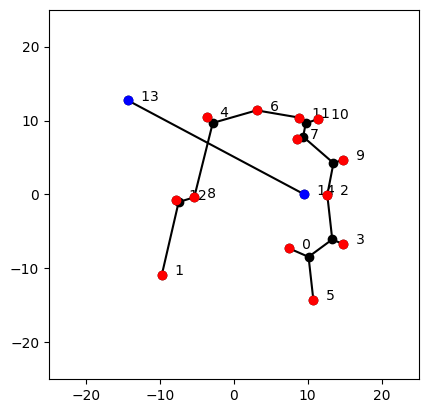



Working on 15 terminals, 3 sinks, 12 sources and rep 0
[[2.34, -11.14], [5.82, 7.21], [-12.3, -11.65], [-2.07, -7.61], [-14.39, -4.16], [13.15, -12.34], [-4.3, -8.44], [-14.17, 13.22], [11.79, -5.23], [-14.51, -10.29], [5.39, -1.1], [-5.07, 5.22], [7.54, -1.37], [-3.5, 2.47], [9.91, 2.1]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joi

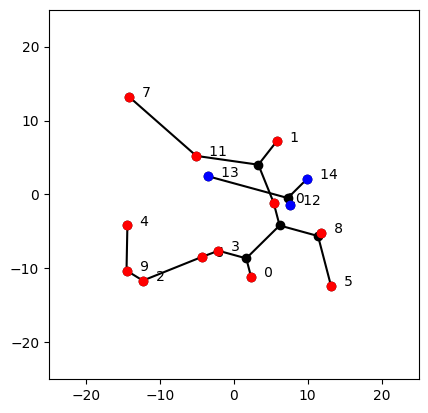



Working on 15 terminals, 4 sinks, 11 sources and rep 0
[[-7.69, 12.34], [-12.05, 14.89], [-11.93, 10.93], [1.62, 5.57], [3.5, -1.18], [-6.63, -13.15], [-3.92, 12.32], [13.47, -5.39], [-12.1, -9.79], [14.95, -1.16], [-1.96, -12.09], [5.27, -11.8], [-14.09, 4.26], [11.53, 12.94], [9.13, 4.95]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 9 trees, found in 0.5374763011932373 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 9 trees, pruned in 0.015590667724609375 s
Find trees related to sinks
Generating b

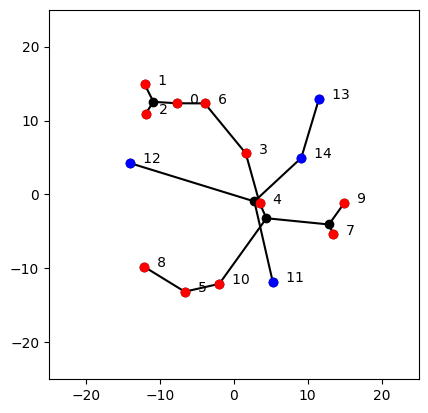



Working on 15 terminals, 5 sinks, 10 sources and rep 0
[[-13.13, 13.97], [-0.79, 11.98], [-1.73, -1.7], [12.8, -8.99], [-11.88, 4.52], [9.53, 12.8], [1.42, 6.92], [3.56, -3.43], [1.47, 7.6], [5.62, -11.67], [-10.78, 8.35], [14.73, -3.73], [7.75, -11.66], [-3.42, 1.97], [-9.16, -0.45]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Pre prune have 17 trees, found in 0.051312446594

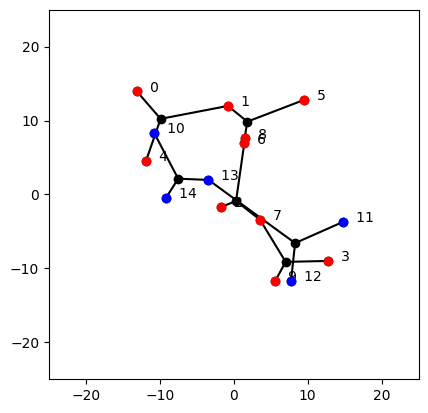



Working on 15 terminals, 6 sinks, 9 sources and rep 0
[[10.97, 0.42], [-6.78, 11.62], [3.04, 4.62], [-13.99, 12.9], [13.19, -9.48], [-6.78, -13.61], [-9.3, 1.68], [-3.36, 0.67], [-11.96, 10.7], [-4.31, -2.97], [0.79, 11.94], [-13.39, 12.05], [-3.2, -12.99], [-10.19, -9.62], [11.42, -6.7]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )


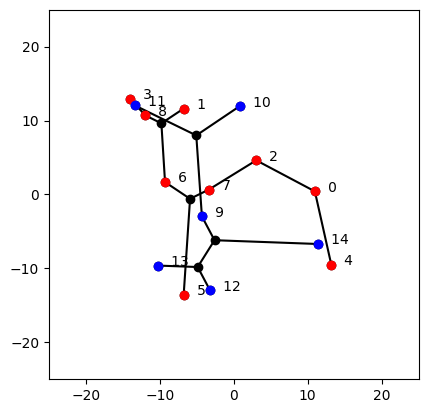



Working on 15 terminals, 7 sinks, 8 sources and rep 0
[[5.71, 7.74], [-14.89, -6.52], [-0.46, 2.92], [-9.06, -7.98], [4.3, 10.1], [-0.91, -13.13], [11.02, -0.76], [-14.72, 10.04], [11.82, 3.61], [2.91, -1.9], [-5.46, -4.34], [-3.04, 12.31], [-11.94, 9.99], [13.88, 8.29], [5.01, -7.04]]
[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size  5  (index  4 )
Joi

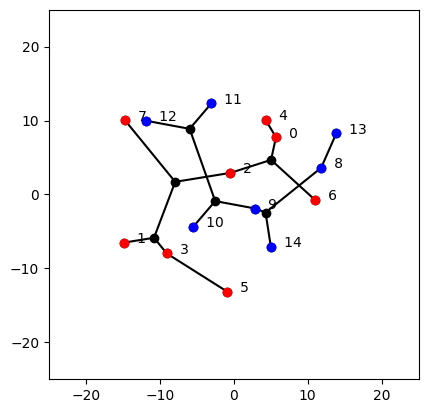

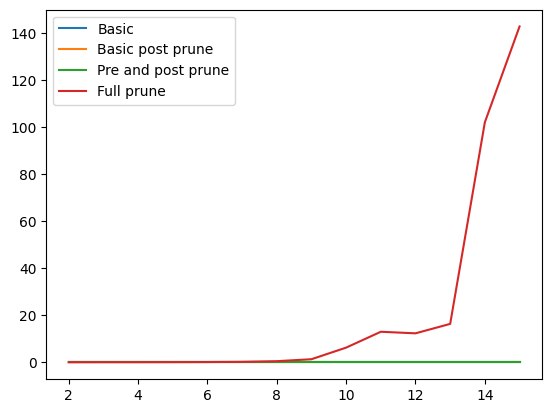

Working on 16 terminals, 1 sinks, 15 sources and rep 0
[[12.9, 5.8], [4.26, 1.73], [-13.78, 2.05], [-14.75, 9.74], [4.64, 7.66], [8.88, 7.68], [-11.49, -9.18], [4.96, 2.51], [11.25, 7.26], [-2.41, -9.86], [-10.5, -7.44], [-0.73, -0.35], [1.58, 13.32], [-2.63, 6.79], [13.41, -12.87], [-7.94, 11.58]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 

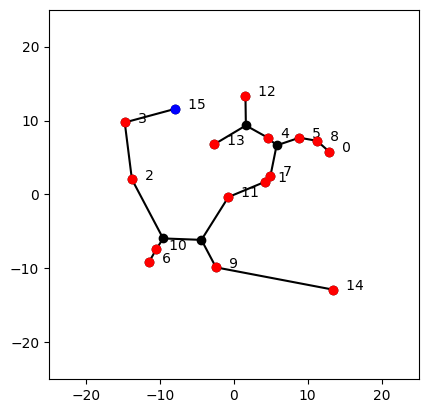



Working on 16 terminals, 2 sinks, 14 sources and rep 0
[[-1.72, 10.48], [4.9, 1.22], [14.3, -5.83], [6.74, 6.88], [11.37, 5.35], [-9.11, 4.91], [-13.09, 1.95], [-5.68, 6.99], [-13.21, 5.14], [10.34, -9.51], [-4.83, 10.53], [-14.53, 0.53], [-8.19, 0.54], [-13.15, -8.22], [0.17, 4.07], [-0.2, 4.69]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (in

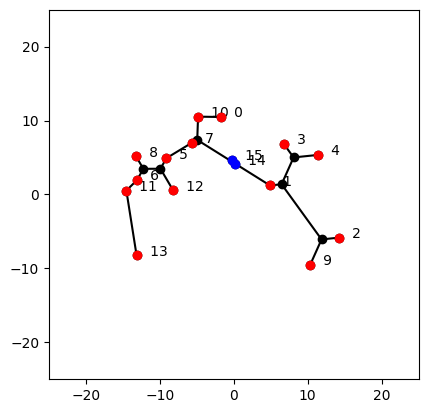



Working on 16 terminals, 3 sinks, 13 sources and rep 0
[[-6.93, 10.51], [-9.54, 5.2], [-8.47, -3.04], [0.8, -5.94], [7.7, 11.47], [1.16, -0.9], [-10.46, -11.81], [0.16, -7.16], [-3.7, 4.24], [12.06, 10.89], [12.02, 0.43], [2.16, 10.05], [14.39, -10.43], [-11.82, -11.68], [-11.41, -7.05], [5.4, -9.28]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2 

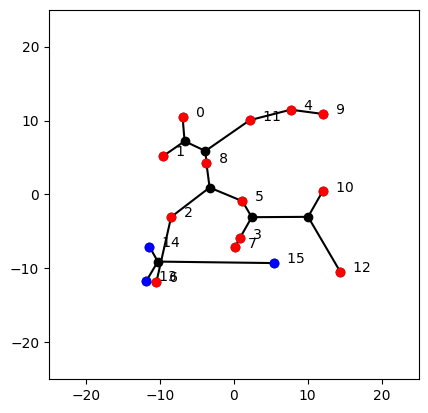



Working on 16 terminals, 4 sinks, 12 sources and rep 0
[[10.1, -5.45], [8.54, 10.75], [-5.25, 8.45], [13.61, 1.99], [-2.29, -9.15], [-6.94, 0.44], [-2.31, -4.48], [3.11, -4.56], [-9.08, -1.95], [12.6, 7.98], [13.82, 14.03], [-14.26, -0.28], [-3.47, -2.77], [-12.28, 4.05], [1.64, -8.67], [11.68, 3.72]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 9 trees, found in 0.015622854232788086 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 9 trees, pruned in 0.01007843017578125 s
Find trees related to sink

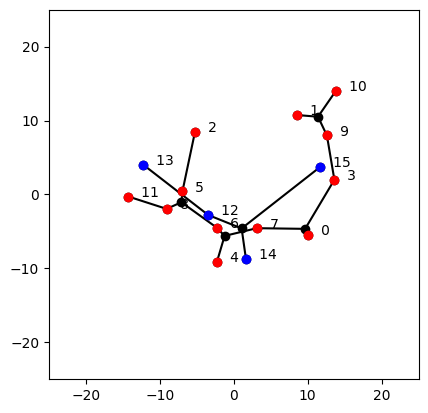



Working on 16 terminals, 5 sinks, 11 sources and rep 0
[[5.59, 5.9], [11.7, 3.77], [2.0, -13.19], [-5.96, 2.09], [-5.46, 2.27], [12.31, 4.52], [11.23, -3.47], [14.12, -1.85], [-3.14, 14.34], [-6.8, -3.59], [-3.81, 8.3], [6.85, 11.85], [7.82, -6.15], [-9.52, -1.09], [-8.93, 1.86], [-7.63, 6.17]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Pre prune have 23 trees, found in 0

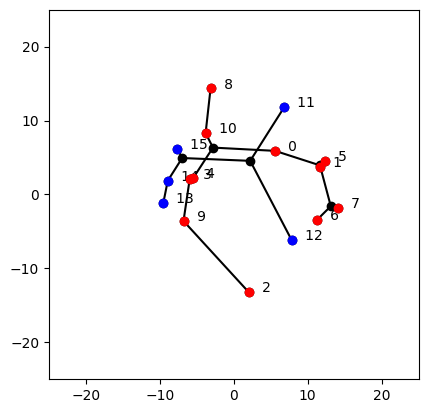



Working on 16 terminals, 6 sinks, 10 sources and rep 0
[[11.22, 7.82], [-10.86, -9.52], [-6.41, 4.85], [-11.91, 13.26], [3.29, 1.05], [1.03, -5.33], [7.82, -11.02], [-13.56, 6.84], [13.32, -7.12], [11.64, 12.85], [-1.88, -9.55], [-0.29, 9.1], [0.47, -2.71], [13.16, 8.43], [-0.92, -14.17], [6.75, 13.81]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of siz

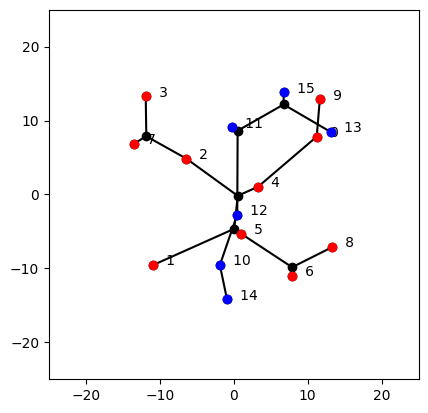



Working on 16 terminals, 7 sinks, 9 sources and rep 0
[[-1.71, 9.86], [9.24, 6.41], [-6.83, -5.83], [-1.82, 10.86], [-1.68, -14.45], [-1.87, -9.37], [-10.37, 0.63], [-5.09, -14.59], [0.22, -14.66], [9.95, -12.06], [1.03, -11.84], [-10.3, -7.56], [-4.02, 6.89], [-12.35, -1.78], [8.26, -11.78], [8.39, -5.3]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of 

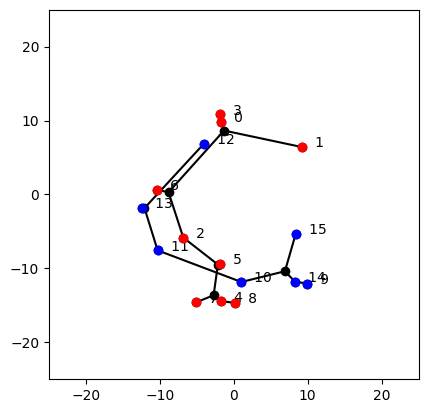



Working on 16 terminals, 8 sinks, 8 sources and rep 0
[[-7.86, 1.58], [-1.38, 11.88], [-14.94, 13.11], [-13.09, -7.94], [-6.47, 8.6], [-1.03, -7.64], [5.48, 10.85], [-3.69, -14.64], [7.46, -2.7], [7.9, 6.64], [-14.73, 8.98], [14.08, -5.2], [-13.38, -0.23], [2.75, -12.9], [-12.75, 0.09], [-4.01, -2.39]]
[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating branches of size

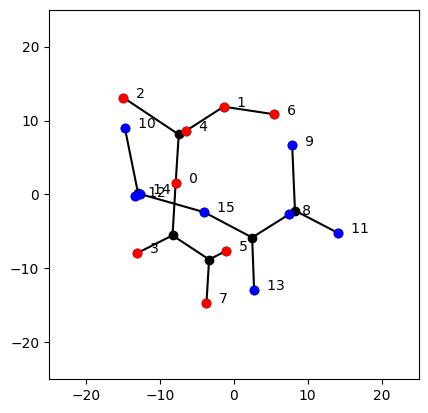

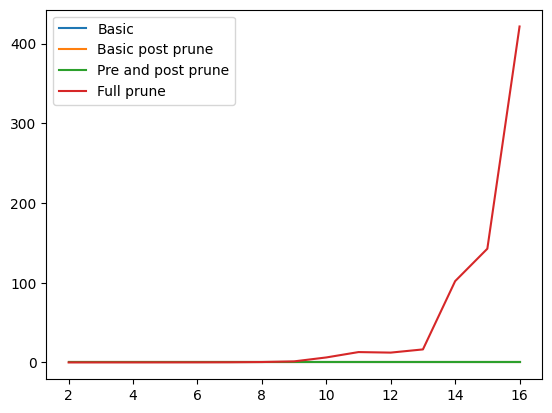

Working on 17 terminals, 1 sinks, 16 sources and rep 0
[[-14.69, -8.26], [-7.75, 14.2], [3.43, 0.56], [-13.55, -5.59], [-13.94, 7.29], [5.91, -8.09], [-11.55, -13.34], [-5.6, -7.36], [-4.38, 9.66], [7.49, -10.2], [-10.53, 4.7], [1.85, -6.51], [5.16, 3.81], [0.35, -8.82], [14.56, 14.49], [1.68, -13.23], [11.86, 8.24]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2

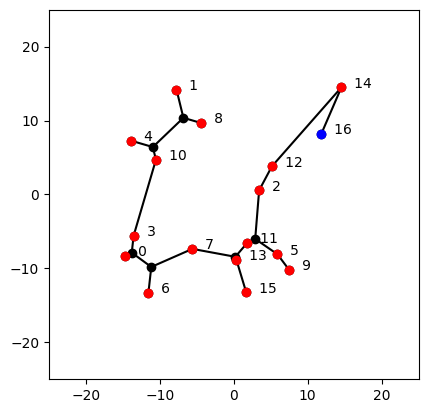



Working on 17 terminals, 2 sinks, 15 sources and rep 0
[[-8.86, -5.61], [-12.63, -4.68], [-7.94, -13.19], [5.05, 6.46], [13.75, 10.08], [-4.11, -4.5], [13.08, -7.71], [8.66, -14.97], [7.78, -12.81], [-3.6, -7.81], [10.93, 2.44], [12.65, -3.77], [6.02, 2.38], [14.15, 10.0], [0.34, -0.89], [12.32, -7.1], [14.72, 14.8]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating b

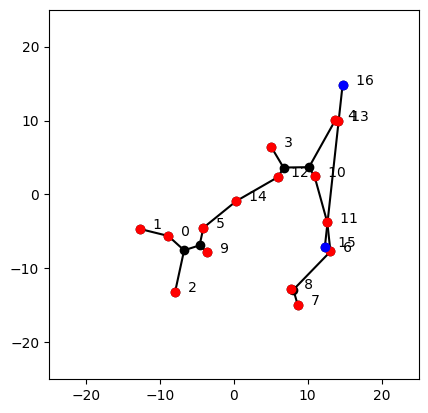



Working on 17 terminals, 3 sinks, 14 sources and rep 0
[[9.32, -7.53], [-10.32, 14.28], [-10.77, 11.66], [13.42, 8.44], [11.32, -7.71], [5.9, 9.64], [-11.8, -6.6], [-9.25, 11.02], [-12.52, 6.62], [6.94, -5.68], [7.81, 4.87], [0.09, -5.19], [3.19, 7.41], [-3.52, -11.67], [9.32, -9.4], [-12.14, 13.64], [0.6, -9.5]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.004489421844482422 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches 

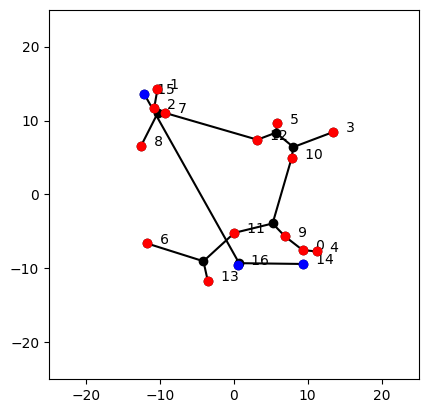



Working on 17 terminals, 4 sinks, 13 sources and rep 0
[[-14.26, -3.85], [10.3, 5.26], [-14.84, -11.74], [-3.92, -1.61], [-9.49, 2.74], [-8.26, 14.15], [-5.27, 9.14], [-2.07, -8.09], [-6.62, -5.29], [7.31, -6.34], [11.03, -8.66], [12.29, 10.71], [7.29, 13.17], [13.27, 6.98], [7.19, -2.02], [10.94, 1.83], [10.94, -7.99]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 8 trees, found in 0.0065767765045166016 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 8 trees, pruned in 0.005327701568603516 s
Fi

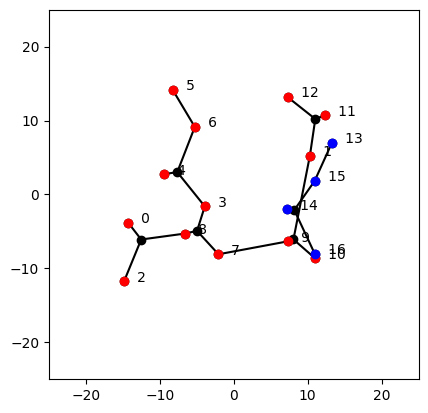



Working on 17 terminals, 5 sinks, 12 sources and rep 0
[[-12.61, 6.02], [-2.67, 3.51], [-3.71, 3.5], [-4.18, 9.96], [-3.22, -2.06], [-8.26, 11.43], [1.89, 14.21], [2.92, 14.66], [10.96, -4.38], [-4.84, 9.61], [11.96, -8.3], [-5.15, 8.07], [10.64, -1.4], [-13.18, -4.11], [11.45, -10.07], [14.26, -0.3], [12.6, -12.88]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Pre prune

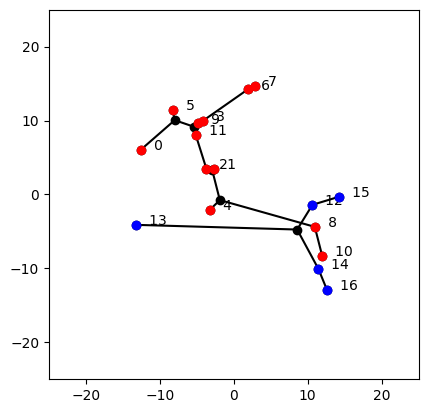



Working on 17 terminals, 6 sinks, 11 sources and rep 0
[[-13.74, -8.45], [4.47, -4.56], [-10.06, 5.98], [11.42, -9.49], [-10.89, 0.94], [-14.02, 3.4], [1.8, 2.99], [-4.91, 3.86], [-0.44, 0.23], [-5.38, 12.39], [-11.33, -11.34], [-3.82, 8.82], [3.57, -1.28], [-11.11, 0.3], [8.38, 0.26], [-12.94, 1.5], [13.75, 7.33]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating 

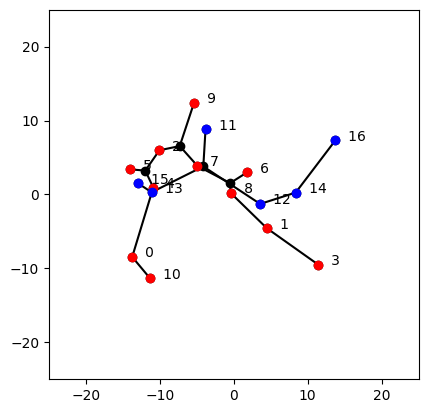



Working on 17 terminals, 7 sinks, 10 sources and rep 0
[[-12.19, -9.7], [7.58, -8.29], [-9.6, 3.73], [-7.79, -6.61], [-3.94, 3.39], [5.75, -7.16], [8.7, 7.44], [-12.28, 6.83], [-11.2, -3.65], [-6.03, -9.65], [12.82, -6.47], [3.11, 8.26], [9.88, 12.45], [14.08, 1.86], [9.61, -14.67], [7.12, -4.77], [10.29, -4.91]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating br

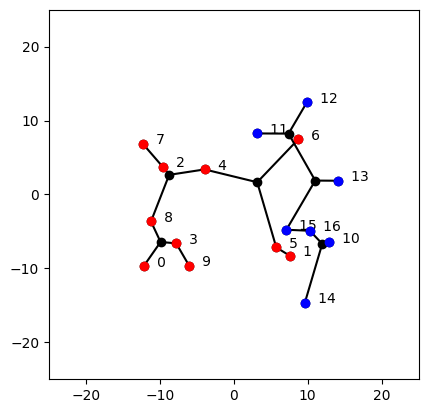



Working on 17 terminals, 8 sinks, 9 sources and rep 0
[[12.26, -3.09], [-8.83, -10.18], [1.74, 13.24], [5.49, -14.35], [11.68, -4.17], [3.94, 2.38], [2.1, -7.96], [-13.95, 1.15], [-8.96, -2.05], [5.91, 2.87], [0.15, -1.91], [-12.03, 8.94], [6.21, 9.49], [-11.9, 0.22], [12.74, -0.31], [9.55, -13.48], [0.58, -4.08]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5
Generating b

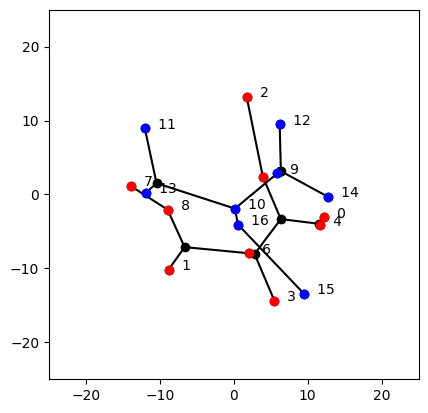

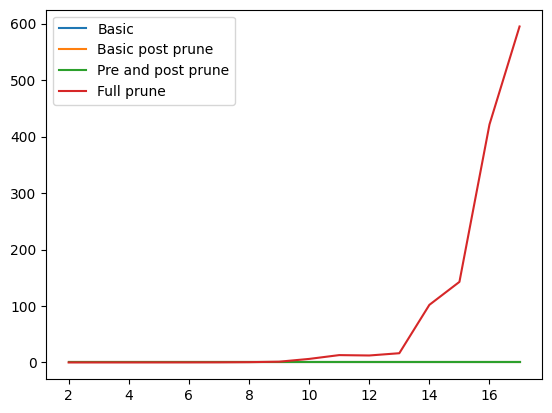

Working on 18 terminals, 1 sinks, 17 sources and rep 0
[[0.21, 9.68], [5.36, -2.21], [14.59, 11.45], [-2.28, 10.46], [-12.77, -3.84], [-10.53, -5.78], [-8.5, 11.1], [-3.64, 11.69], [9.53, 0.25], [-1.17, 8.4], [8.0, -7.76], [9.14, 11.59], [8.94, -7.42], [13.64, -9.9], [-2.39, 4.22], [-13.1, -12.58], [12.71, 14.37], [-8.54, -8.8]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of siz

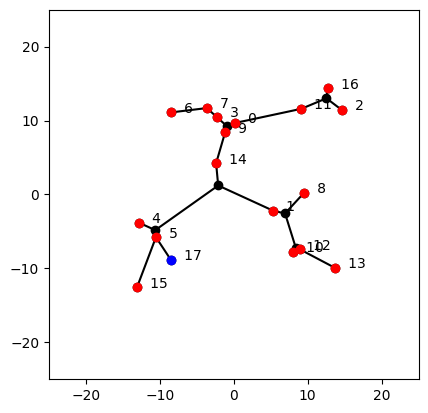



Working on 18 terminals, 2 sinks, 16 sources and rep 0
[[7.13, 10.96], [2.03, -11.4], [-2.02, 7.1], [-10.23, -3.96], [9.74, 4.78], [4.9, 7.76], [11.06, -12.16], [14.62, -1.61], [6.41, 9.82], [-4.81, -9.95], [11.34, -1.38], [1.24, 14.83], [-13.41, 13.12], [8.49, 9.85], [1.42, 3.73], [9.11, -3.03], [0.14, 4.67], [-3.03, -13.84]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4

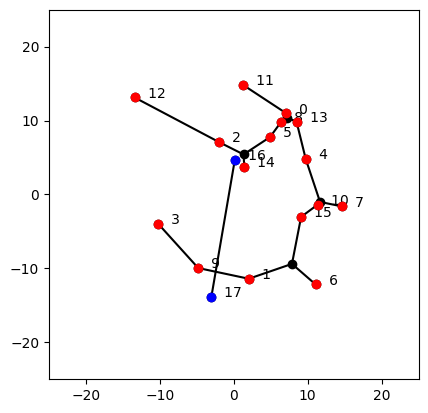



Working on 18 terminals, 3 sinks, 15 sources and rep 0
[[-12.13, -0.08], [13.93, -7.69], [3.56, 8.71], [-11.77, -5.97], [13.82, 9.66], [-14.02, -13.29], [14.31, 4.3], [-12.41, 9.79], [-8.91, 13.29], [-1.3, 3.49], [-6.26, -12.92], [14.77, -9.43], [-14.58, -1.36], [-8.83, -7.13], [-4.29, 3.74], [4.65, -8.38], [9.1, 8.4], [-12.61, 11.49]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining 

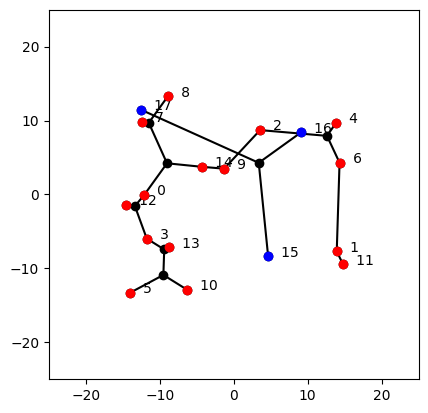



Working on 18 terminals, 4 sinks, 14 sources and rep 0
[[-7.1, -1.87], [8.61, -3.98], [10.46, 5.2], [-7.3, -4.87], [9.58, -10.95], [-11.32, 8.94], [-10.1, -13.78], [-1.28, -5.82], [1.86, -12.8], [2.18, -11.95], [-4.57, 11.89], [-4.35, 9.51], [-13.12, -14.78], [-10.6, 13.45], [14.43, 4.85], [5.51, 1.06], [-2.29, 5.36], [-11.17, 7.06]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 6 trees, found in 0.015588045120239258 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 6 trees, pruned in 0.0 s
Fin

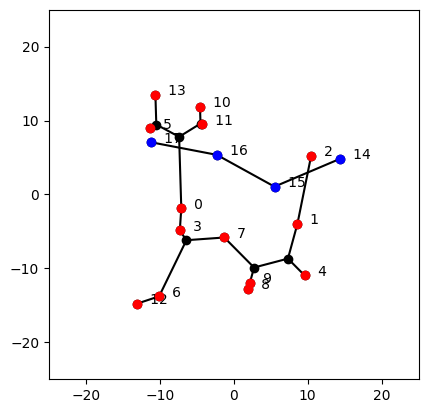



Working on 18 terminals, 5 sinks, 13 sources and rep 0
[[5.4, 2.24], [-10.7, 3.78], [9.54, 6.81], [0.68, -3.39], [9.93, 2.0], [-1.82, -2.03], [4.85, 7.13], [8.41, 1.84], [-10.66, -1.41], [-0.8, 12.8], [8.39, -11.98], [9.16, -9.13], [-9.61, 14.08], [0.54, -3.7], [10.69, 10.95], [-9.4, 1.92], [-14.9, 12.21], [-14.64, 12.82]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of size  5


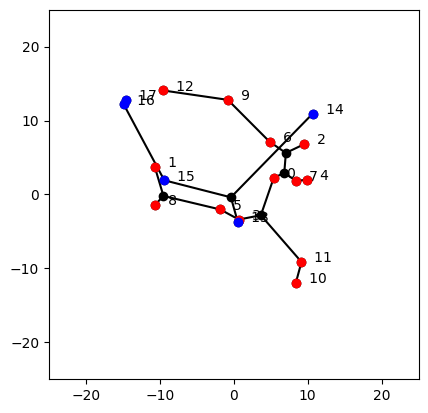



Working on 18 terminals, 6 sinks, 12 sources and rep 0
[[-5.83, 1.24], [3.95, 11.66], [-11.8, 5.62], [7.45, -2.72], [14.64, 14.25], [-13.42, -11.72], [7.25, 9.4], [3.38, 9.72], [-13.76, -10.45], [13.44, 5.01], [-1.88, -9.62], [-3.46, -3.94], [13.49, -10.42], [-6.94, -1.11], [0.38, -10.68], [11.66, -10.31], [-5.55, 4.66], [-9.77, 0.77]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating tree

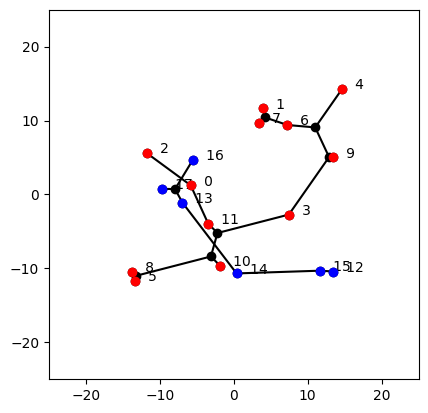



Working on 18 terminals, 7 sinks, 11 sources and rep 0
[[11.5, -12.44], [-7.16, -10.36], [-1.49, -5.68], [8.01, -13.41], [10.3, 8.7], [-12.72, -10.07], [7.92, 1.44], [4.81, 7.48], [-0.17, -5.79], [-10.79, 3.57], [9.41, -5.03], [-9.87, 3.94], [-12.33, 6.41], [14.42, 0.21], [10.49, -4.1], [1.25, -14.92], [2.5, 5.68], [-4.01, 7.34]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of s

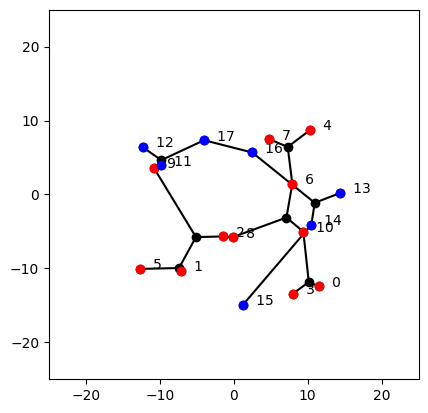



Working on 18 terminals, 8 sinks, 10 sources and rep 0
[[1.4, 7.65], [-0.57, 2.58], [-12.53, 0.9], [1.35, -2.95], [-11.96, -2.15], [-4.3, 3.89], [-3.52, 5.25], [9.36, 2.47], [6.4, -6.68], [-14.35, 0.11], [6.81, -13.45], [-6.89, -5.62], [1.41, -14.24], [-12.84, -2.28], [-11.49, 6.94], [2.09, 14.3], [1.56, -5.13], [-3.25, -0.36]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating trees of siz

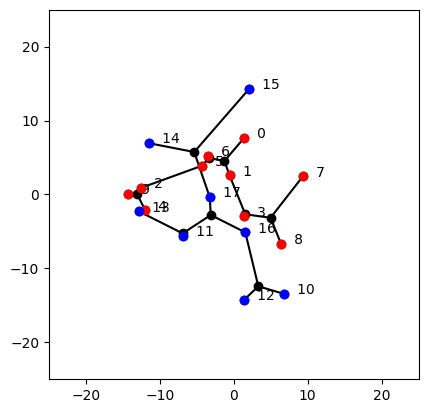



Working on 18 terminals, 9 sinks, 9 sources and rep 0
[[-12.35, -3.22], [-3.28, 2.3], [-11.23, -12.64], [-9.85, 12.1], [4.8, -4.7], [12.96, -5.67], [-1.13, -11.76], [1.62, -13.0], [-13.05, 10.76], [-4.37, 4.59], [-8.43, 12.29], [3.89, 3.75], [-6.77, 2.93], [-6.13, 4.97], [-11.11, 7.28], [-6.51, -3.45], [-3.28, -11.23], [-14.52, -5.01]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
Generating tree

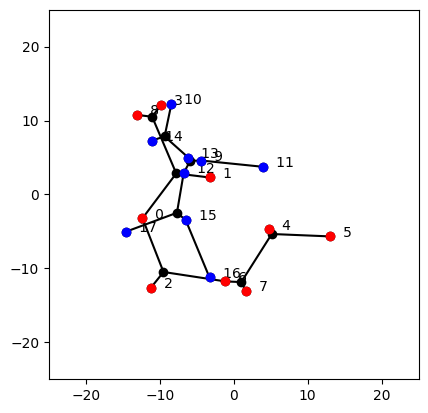

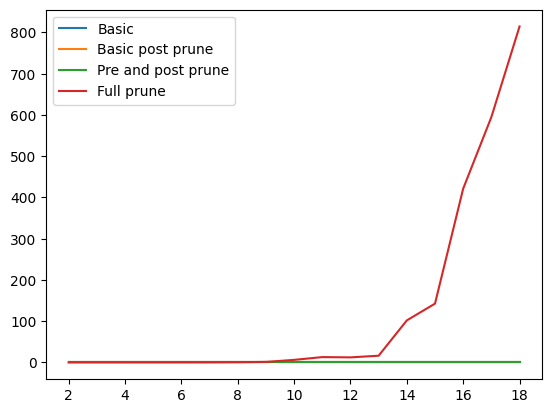

Working on 19 terminals, 1 sinks, 18 sources and rep 0
[[4.51, -9.42], [2.92, 12.24], [-13.53, -2.44], [1.56, -1.77], [-13.75, 8.35], [2.16, -6.84], [1.31, 7.75], [12.24, -10.81], [6.63, 8.82], [8.31, -11.23], [8.87, 2.21], [-2.05, 3.82], [-3.54, -13.53], [-14.98, 11.92], [7.16, 10.98], [-5.44, 2.1], [3.62, 10.59], [-14.11, -8.21], [-11.88, 1.11]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
J

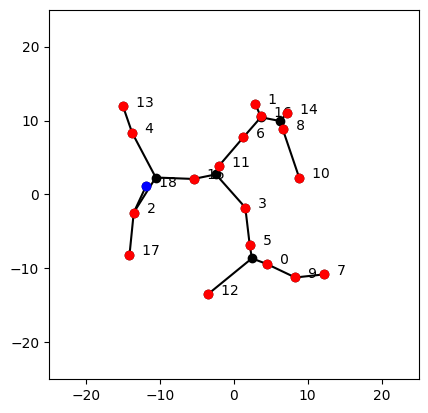



Working on 19 terminals, 2 sinks, 17 sources and rep 0
[[-2.76, -3.79], [3.8, -2.74], [-12.27, 8.58], [7.3, 2.52], [-2.65, -1.91], [9.24, 14.56], [-0.83, 1.23], [11.05, 5.02], [12.41, 1.3], [12.36, -6.63], [-10.4, 9.18], [12.62, 6.0], [-1.44, -8.37], [-7.64, -6.42], [-14.33, -2.4], [-2.04, -1.35], [-6.34, -5.0], [2.24, 5.4], [-3.33, -10.22]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generatin

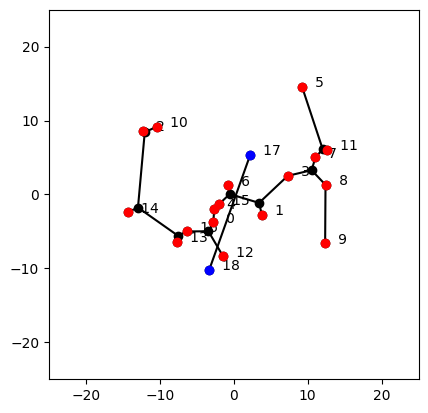



Working on 19 terminals, 3 sinks, 16 sources and rep 0
[[-6.28, 5.9], [-4.03, 0.72], [7.86, 2.93], [-6.21, -5.81], [11.63, 11.33], [-12.73, -5.56], [-8.08, 13.09], [11.71, -3.32], [1.34, -10.67], [4.69, 14.42], [0.31, -8.29], [-8.41, 7.37], [10.73, -3.04], [-9.0, -7.49], [13.99, -8.24], [9.85, 13.36], [13.47, 1.56], [-11.65, 5.08], [11.7, -7.43]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 4 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 4 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index

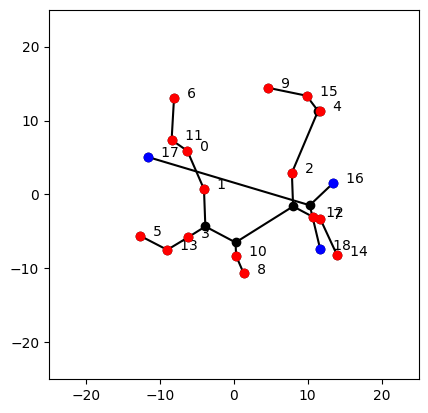



Working on 19 terminals, 4 sinks, 15 sources and rep 0
[[11.5, 4.75], [13.21, 8.45], [3.33, 11.44], [12.12, -13.35], [6.41, 10.98], [13.96, -11.26], [-13.44, 12.43], [5.93, -7.23], [0.33, 12.72], [3.18, -6.99], [4.43, 7.19], [-8.85, -12.91], [1.57, -9.89], [13.83, -10.85], [-12.26, -6.83], [-9.7, -13.37], [-11.18, 11.03], [11.42, 13.37], [-4.99, 2.68]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 8 trees, found in 0.015590429306030273 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 8 tree

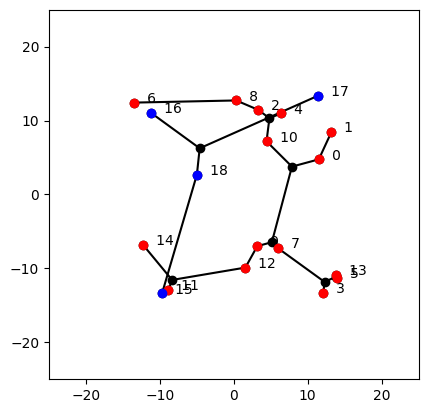



Working on 19 terminals, 5 sinks, 14 sources and rep 0
[[1.26, -12.0], [-13.19, 14.45], [-14.81, -11.91], [-0.94, 12.56], [-14.96, 10.25], [0.58, 7.33], [-13.77, 0.1], [13.13, -14.02], [8.96, -10.29], [3.9, -6.32], [1.37, -0.07], [5.65, -1.63], [-1.54, -9.6], [-10.24, 14.01], [-6.05, 6.92], [-12.31, 8.88], [10.1, -9.44], [9.5, -9.25], [3.94, -13.7]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 

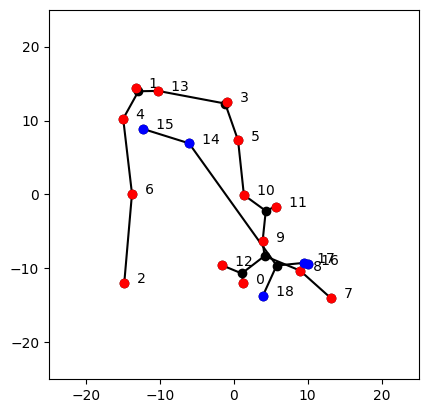



Working on 19 terminals, 6 sinks, 13 sources and rep 0
[[-2.08, -5.13], [0.07, 7.25], [7.63, 1.97], [14.22, -2.05], [-0.6, 3.62], [13.97, -8.66], [-11.13, 10.27], [-11.3, 5.47], [-4.75, -10.21], [3.23, -0.38], [-9.55, 13.72], [3.53, -3.95], [-4.99, -8.28], [-1.98, -7.19], [12.69, 7.4], [-6.48, -7.86], [-1.71, 10.55], [-1.85, 9.22], [-3.43, 6.64]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
G

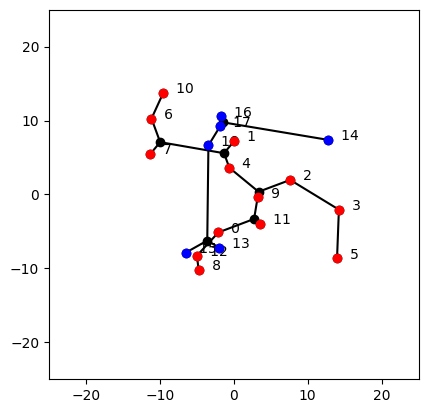



Working on 19 terminals, 7 sinks, 12 sources and rep 0
[[-0.38, -0.42], [-3.32, 5.53], [-14.48, -10.61], [-8.3, -4.25], [-0.48, 3.24], [-3.42, 10.68], [-12.42, 13.45], [-6.24, -4.84], [9.14, -3.9], [-1.38, 5.17], [12.7, -1.47], [-7.26, 8.11], [-10.42, -3.84], [12.9, -12.89], [10.32, 0.78], [10.32, 11.66], [1.71, 6.94], [1.56, 5.91], [-3.26, 14.61]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )

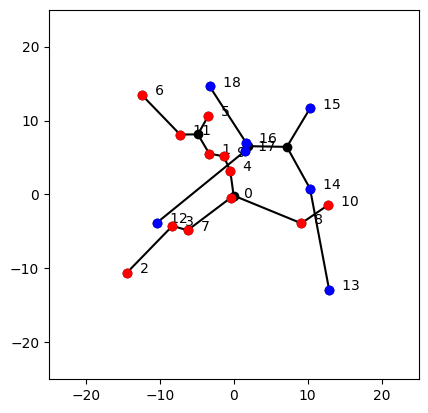



Working on 19 terminals, 8 sinks, 11 sources and rep 0
[[-9.38, -5.1], [-2.74, -9.86], [-9.36, 10.65], [8.58, 8.49], [-12.0, -8.85], [6.58, 4.81], [-0.46, 4.58], [-12.05, 7.31], [-9.28, 13.44], [10.8, 8.7], [-4.22, 14.2], [8.79, 12.66], [14.75, -10.09], [-12.62, 2.25], [-9.72, -5.91], [14.64, 4.67], [-5.47, -13.46], [8.48, -2.0], [-14.56, -11.97]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )


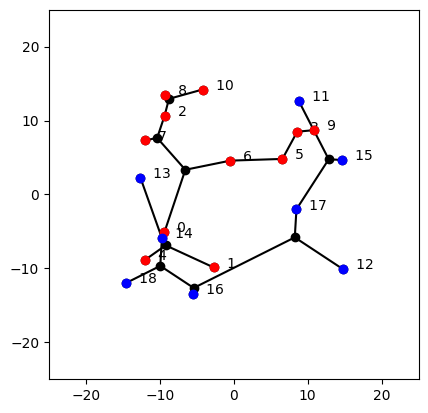



Working on 19 terminals, 9 sinks, 10 sources and rep 0
[[-6.87, 12.32], [-5.89, -8.32], [9.86, -6.33], [-5.66, -0.15], [-1.73, -8.62], [-14.89, -12.94], [4.04, -6.92], [12.58, 11.86], [4.68, -10.15], [4.21, 8.88], [4.45, -14.68], [12.85, 7.06], [4.84, -8.75], [14.81, 9.41], [13.65, 5.97], [-6.26, -5.2], [6.64, -0.42], [-4.8, 7.62], [-8.97, 2.87]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  2  (index  1 )
Joining branches of size  3  (index  2 )  and  1  (index  0 )
G

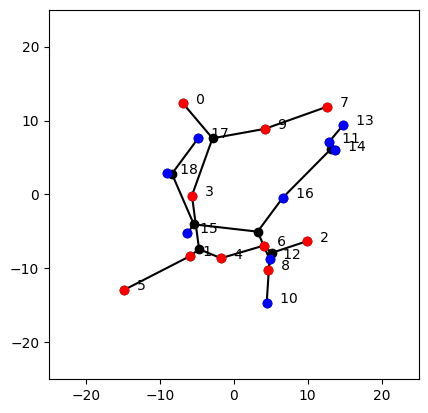

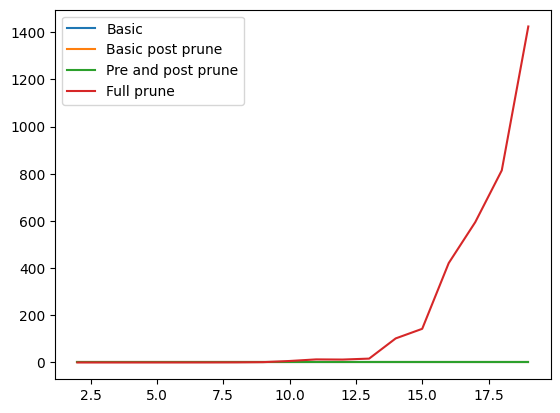

Working on 20 terminals, 1 sinks, 19 sources and rep 0
[[5.17, 12.78], [4.48, -2.26], [-9.83, -7.44], [-9.97, -5.56], [-13.6, 3.77], [3.7, 1.28], [-13.22, -6.38], [14.45, 12.94], [-5.55, -9.58], [-1.15, -12.59], [4.86, -4.51], [-7.26, 2.5], [-12.01, 5.63], [-5.25, -8.68], [12.42, 9.5], [-4.03, -3.33], [13.46, 3.79], [-0.76, 11.28], [11.68, 3.95], [5.63, 11.6]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
Find trees related to sources
Have a single terminal, do nothing
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Generating branches of size  4  (index  3 )
Joining branches of size  1  (index  0 )  and  3  (index  2 )
Joining branches of size  2  (index  1 )  and  

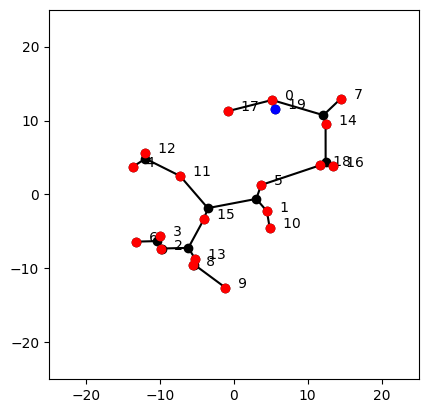



Working on 20 terminals, 2 sinks, 18 sources and rep 0
[[7.3, -14.9], [-1.44, 0.55], [7.36, -5.95], [12.49, -13.87], [13.78, 12.73], [7.36, -7.48], [5.31, 4.65], [12.79, 7.46], [-1.39, -8.87], [7.58, 1.4], [-14.91, 3.47], [2.71, -7.05], [-4.4, 1.23], [6.89, -6.16], [-5.04, 7.53], [8.72, -12.15], [9.56, -3.29], [-11.72, 14.7], [4.72, 3.75], [5.3, 0.24]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
Find trees related to sources
Pre prune have 1 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 1 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index 

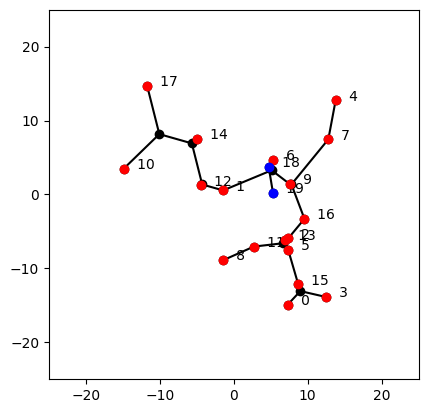



Working on 20 terminals, 3 sinks, 17 sources and rep 0
[[-6.17, -3.24], [-10.66, -13.29], [7.72, 12.42], [-9.74, 4.76], [-3.63, 4.66], [-4.3, 1.69], [10.81, 11.77], [-14.36, -6.16], [11.92, -5.15], [14.89, -13.86], [-11.12, 13.49], [-1.47, 2.49], [3.03, -5.66], [13.98, 6.2], [-14.97, 6.32], [-12.42, -10.21], [14.73, 13.83], [-6.8, -5.63], [2.41, 7.21], [-10.54, -10.14]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Pre prune have 3 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have 3 trees, pruned in 0.0 s
Find trees related to sinks
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating 

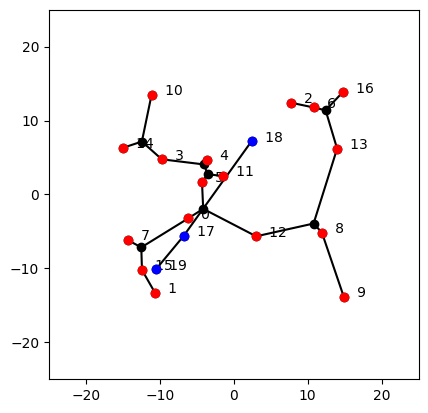



Working on 20 terminals, 4 sinks, 16 sources and rep 0
[[2.75, 6.57], [-9.78, 14.99], [-10.26, -13.59], [12.92, -14.28], [-7.79, 13.41], [-12.52, 9.67], [12.73, -3.81], [-6.91, -0.75], [-5.95, 5.68], [0.86, -7.68], [-11.13, -4.16], [14.11, 11.73], [-9.55, 0.47], [-12.63, -14.14], [4.88, -14.64], [-12.16, -10.17], [-10.52, 6.78], [0.02, 7.42], [13.66, -5.08], [-3.17, 8.08]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0]
Find trees related to sources
Generating branches of size  2  (index  1 )
Joining branches of size  1  (index  0 )  and  1  (index  0 )
Generating trees of size  3
Generating branches of size  3  (index  2 )
Joining branches of size  1  (index  0 )  and  2  (index  1 )
Joining branches of size  2  (index  1 )  and  1  (index  0 )
Generating trees of size  4
Pre prune have 6 trees, found in 0.0 s
Removed  0.0 % of trees due to self intersections
Removed further  0.0 % of trees due to lune test
Removed further  0.0 % of trees due to TSP test
Post prune have

KeyboardInterrupt: 

In [10]:
import pandas as pd
import time
# Degree 5 Analysis

# Prune tree if they self intersect
def intersection_prune(tree):
    for i in range(len(tree[1]) - 1):
        for j in range(i + 1, len(tree[1])):
            intersection = edge_intersect(tree, i, j)
            if intersection != 0:
                return True
    return False

# Prune tree based on double lune prunning
def post_lune_prune(tree, additionalVertices):
    numFails = 0
    for edge in tree[1]:
        # Check whether any point in this tree and any other specified terminals lie in the lune
        # print(tree[0] + additionalVertices)
        # for vertex in (tree[0] + additionalVertices):
        for vertex in (additionalVertices):
        
            # print(vertex)
            # Should check whether this is an endpoint of the edge, but since I am checking that
            # it is strictly inside, this can be skipped
            dist1 = dist(vertex, tree[0][edge[0]])
            dist2 = dist(vertex, tree[0][edge[1]])
            dist3 = dist(tree[0][edge[0]], tree[0][edge[1]])
            
            if abs(dist1 - dist3) > EPS2 and abs(dist2 - dist3) > EPS2 and dist1 < dist3 and dist2 < dist3:
                numFails = numFails + 1
                if numFails == 2:
                    return True
                # This edge failed, don't want to look for other vertices
                break
    return False
# Prune based on TSP           
def tsp_prune(tree):
    terminals = [terminal for terminal in tree[0] if terminal[2] >= 0]
    tspCost = tsp_cost(terminals)
    # Now need to calculate the cost of the current tree
    treeCost = 0
    for i in range(len(tree[0]) - 1):
        treeCost = treeCost + dist(tree[0][i], tree[0][tree[0][i][3]])
    if treeCost >= tspCost:
        return True
    return False

# def post_bottleneck_prune(tree, bst):
#     # Cycle through each edge in the tree
#     numFails = 0
#     for edge in tree[1]:
#         # Need to figure out which terminals lie on each side of this edge
        
#      # First thing to do is find the pair of terminals with the shortest bst
#     minDist = np.inf
#     for t1 in b1[3]:
#         for t2 in b2[3]:
#             if bst[t1][t2] < minDist:
#                 minDist = bst[t1][t2]

def prune_trees(trees, sameKindTerminals):
    removeIntersection = [False for tree in trees]
    for treeIndex in range(len(trees)):
        removeIntersection[treeIndex] = intersection_prune(trees[treeIndex])
    print("Removed ", 100*sum(removeIntersection) / len(removeIntersection), "% of trees due to self intersections")
    trees = [trees[treeIndex] for treeIndex in range(len(trees)) if removeIntersection[treeIndex] == False]
    
    removeLune = [False for tree in trees]
    for treeIndex in range(len(trees)):
        removeLune[treeIndex] = post_lune_prune(trees[treeIndex], sameKindTerminals)
    print("Removed further ", 100*sum(removeLune) / len(removeLune), "% of trees due to lune test")
    trees = [trees[treeIndex] for treeIndex in range(len(trees)) if removeLune[treeIndex] == False]

    removeTSPbound = [False for tree in trees]
    for treeIndex in range(len(trees)):
        removeTSPbound[treeIndex] = tsp_prune(trees[treeIndex])
    print("Removed further ", 100*sum(removeTSPbound) / len(removeTSPbound), "% of trees due to TSP test")
    trees = [trees[treeIndex] for treeIndex in range(len(trees)) if removeTSPbound[treeIndex] == False]

    return trees

def find_heuristic_solution_hypergraph(terminals, labels, source_trees, sink_trees):
    t0 = time.time()
    intersectionPairs = []
    # Rather than having intersection edges, want intersection trees
    for source_index in range(len(source_trees)):
        for sink_index in range(len(sink_trees)):
            # Compare pairs of edges and check if they intersect
            source_tree = source_trees[source_index]
            sink_tree = sink_trees[sink_index]
            
            for edge_source_index in range(len(source_tree[1])):
                for edge_sink_index in range(len(sink_tree[1])):
                    # Get the endpoints
                    endpoint_source_1 = source_tree[0][source_tree[1][edge_source_index][0]]
                    endpoint_source_2 = source_tree[0][source_tree[1][edge_source_index][1]]
                    endpoint_sink_1 = sink_tree[0][sink_tree[1][edge_sink_index][0]]
                    endpoint_sink_2 = sink_tree[0][sink_tree[1][edge_sink_index][1]]
        
                    # Check if the endpoints are the same; then check if they intersect
                    if (dist(endpoint_source_1, endpoint_sink_1) < EPS or
                        dist(endpoint_source_1, endpoint_sink_1) < EPS or
                        dist(endpoint_source_2, endpoint_sink_2) < EPS or
                        dist(endpoint_source_2, endpoint_sink_2) < EPS):
                        
                        intersectionPairs.append([source_index, sink_index])
                        continue
                    elif line_intersection([endpoint_source_1,
                                            endpoint_source_2],
                                            [endpoint_sink_1,
                                            endpoint_sink_2], 0, 0) != 0:
                        intersectionPairs.append([source_index, sink_index])
        
    print("Have", len(intersectionPairs), "pairs of trees (i.e. hyperedges) which intersect!")

    # Now want to think of each tree as a hyperedge, and want to keep track of which terminals it contains
    # I think all I care about is the sum of the lengths of the edges, and the terminals in each tree
    
    trueSourceTerminals = [i for i in range(len(labels)) if labels[i] <= 1]
    trueSinkTerminals = [i for i in range(len(labels)) if labels[i] >= 1]
    sourceTerminals = range(len(trueSourceTerminals))
    sinkTerminals = range(len(trueSinkTerminals))
    
    # Going to need the cost of each tree, and the terminals contained in each tree
    costSources = []
    costSinks = []
    terminalsSources = []
    terminalsSinks = []
    for tree in source_trees:
        localTerminals = [vertex[2] for vertex in tree[0] if vertex[2] >= 0]
        terminalsSources.append(localTerminals)
        cost = 0
        for edge in tree[1]:
            cost = cost + dist(tree[0][edge[0]], tree[0][edge[1]])
        costSources.append(cost)
    for tree in sink_trees:
        localTerminals = [vertex[2] for vertex in tree[0] if vertex[2] >= 0]
        terminalsSinks.append(localTerminals)
        cost = 0
        for edge in tree[1]:
            cost = cost + dist(tree[0][edge[0]], tree[0][edge[1]])
        costSinks.append(cost)

    # print(sourceTerminals)
    # print(sinkTerminals)
    # print(costSources)
    # print(costSinks)
    # print(terminalsSources)
    # print(terminalsSinks)
    # print("Source trees")
    # for tree in source_trees:
    #     print(tree)
    # print("Sink trees")
    # for tree in sink_trees:
    #     print(tree)
    
    # Have two functions for the subtour elimination
    # First focus on sources, then on sinks
    def subtourelim(model, where):
        if where == GRB.Callback.MIPSOL:
            # print("\n\n ADD \n\n")
            
            vals = model.cbGetSolution(model._sources)
            hyperedges = [terminalsSources[i] for i in range(len(terminalsSources)) if vals[i] > 0.5]
            group = violation(hyperedges, len(sourceTerminals))
            if len(group) < len(trueSourceTerminals) and len(group) > 1:
                # print("Found for sources group")
                # print(group)
                model.cbLazy(gp.quicksum((len(list(set(terminalsSources[i]) & set(group))) - 1) * model._sources[i] for i in range(len(terminalsSources)) if len(list(set(terminalsSources[i]) & set(group))) > 0) <= len(group) - 1)
                
            vals = model.cbGetSolution(model._sinks)
            hyperedges = [terminalsSinks[i] for i in range(len(terminalsSinks)) if vals[i] > 0.5]
            # print("Current solution has edges")
            # for edge in hyperedges:
            #     print(edge)
            # print("All edges")
            # for edge in terminalsSinks:
            #     print(edge)
            group = violation(hyperedges, len(sinkTerminals))
            if len(group) < len(trueSinkTerminals) and len(group) > 1:
                # print("Found for sinks group")
                # print(group)
                model.cbLazy(gp.quicksum((len(list(set(terminalsSinks[i]) & set(group))) - 1) * model._sinks[i] for i in range(len(terminalsSinks)) if len(list(set(terminalsSinks[i]) & set(group))) > 0) <= len(group) - 1)
    
    # Want the smallest tour (any tour would do), don't want tour of length 1 though       
    def violation(hyperedges, n):
        unvisited = list(range(n))
        cycle = range(n+1)
        # Should go through every vertex and find which vertices are reachable
        adjacency = []
        for v in range(n):
            adjacent = []
            for edge in hyperedges:
                if not(v in edge):
                    continue
                adjacent = list(set(adjacent + edge))
            adjacency.append(adjacent)
        
        while unvisited:  
            thiscycle = []
            to_visit = [unvisited[0]]
            while to_visit:
                current = to_visit[0]
                thiscycle.append(current)
                unvisited.remove(current)
                to_visit.remove(current)
                # Add all the nodes than can be seen that have not yet been visited
                for i in adjacency[current]:
                    if i in unvisited and not i in to_visit:
                        to_visit.append(i)
            if len(cycle) > len(thiscycle):
                # Check whether this group violates the constraint
                sum = 0
                for edge in hyperedges:
                    intersection = len(list(set(edge) & set(thiscycle)))
                    if intersection > 0:
                        sum = sum + intersection - 1
                if sum > len(thiscycle) - 1:
                    cycle = thiscycle
        return cycle        
    
    
    # I think I can start the model
    m = gp.Model()
    eSources = m.addVars(range(len(source_trees)), vtype=GRB.BINARY, name='sources')
    eSinks = m.addVars(range(len(sink_trees)), vtype=GRB.BINARY, name='sources')

    m.setObjective(gp.quicksum(eSources[i] * costSources[i] for i in range(len(source_trees))) + gp.quicksum(eSinks[i] * costSinks[i] for i in range(len(sink_trees))), GRB.MINIMIZE)
    # Only start with two constraints, the overall tree constraint
    m.addConstr(gp.quicksum((len(terminalsSources[i]) - 1) * eSources[i] for i in range(len(source_trees))) == (len(sourceTerminals) - 1))
    m.addConstr(gp.quicksum((len(terminalsSinks[i]) - 1) * eSinks[i] for i in range(len(sink_trees))) == (len(sinkTerminals) - 1))

    # Variable for using intersections
    # Only do this if intersections actually exist
    if(len(intersectionPairs) > 0):
        intersectionVars = m.addVars(range(len(intersectionPairs)), vtype = GRB.BINARY, name = 'w')
        # Must have at least one intersection
        m.addConstr(gp.quicksum(intersectionVars[i] for i in range(len(intersectionPairs))) >= 1)
        # If using an intersection, must use the trees corresponding to that intersection
        for i in range(len(intersectionPairs)):
            m.addConstr(eSources[intersectionPairs[i][0]] + eSinks[intersectionPairs[i][1]] >= 2 * intersectionVars[i])

    
    # Solve with lazy contraints; break local loops whenever they appear.
    m._sources = eSources
    m._sinks = eSinks
    m.Params.LazyConstraints = 1
    m.Params.OutputFlag = False
    m.optimize(subtourelim)

    solverValue = m.objVal
    # Extract information; I think it is just a matter of storing all used trees, and then asking the function to turn it into a graph
    # Need to replace the terminal index with the correct one
    
    finalTrees = []
    index = -1
    for val in eSources.values():
        index = index + 1
        if val.X > EPS:
            tree = copy.deepcopy(source_trees[index])
            for v in tree[0]:
                if v[2] >= 0:
                    v[2] = trueSourceTerminals[v[2]]
            finalTrees.append(tree)
    index = -1
    for val in eSinks.values():
        index = index + 1
        if val.X > EPS:
            tree = copy.deepcopy(sink_trees[index])
            for v in tree[0]:
                if v[2] >= 0:
                    v[2] = trueSinkTerminals[v[2]]
            finalTrees.append(tree)
    
    # Have the trees, just combine!
    finalGraph = generate_basic_input_graph(terminals, finalTrees)
    # If the edges do not intersect, add a shortest edge between a sink and a source
    shortestDist = float("inf")
    sources = [terminals[i] for i in range(len(terminals)) if labels[i] <= 1]
    sinks = [terminals[i] for i in range(len(terminals)) if labels[i] >= 1]
    for i in trueSourceTerminals:
        for j in trueSinkTerminals:
            if dist(terminals[i], terminals[j]) < shortestDist:
                shortestDist = dist(terminals[i], terminals[j])
                joinEdge = [i, j]
                # print(joinEdge)
    t1 = time.time()
    
    if len(intersectionPairs) == 0:
        solverValue = solverValue + shortestDist
        print("Found heuristic solution of cost", solverValue, "in", t1 - t0, "s, by adding edge to MStT solution")
        plot_tree([finalGraph[0], finalGraph[1] + [joinEdge]], terminals, labels)
        return [False, solverValue]
    
    print("Found heuristic solution of cost", solverValue, "in", t1 - t0, "s, by forcing overlap of edges in MStT solution") 
    plot_tree(finalGraph, terminals, labels)
    return [True, solverValue]    


def find_heuristic_solution(terminals, labels, sources_tree, sinks_tree):
    t0 = time.time()
    # The first thing to do is to go through each pair of edges and check if they intersect; keep track of those that do.
    intersectionPairs = []
    for edge_source_index in range(len(sources_tree[1])):
        for edge_sink_index in range(len(sinks_tree[1])):
            # Get the endpoints
            endpoint_source_1 = sources_tree[0][sources_tree[1][edge_source_index][0]]
            endpoint_source_2 = sources_tree[0][sources_tree[1][edge_source_index][1]]
            endpoint_sink_1 = sinks_tree[0][sinks_tree[1][edge_sink_index][0]]
            endpoint_sink_2 = sinks_tree[0][sinks_tree[1][edge_sink_index][1]]

            # Check if the endpoints are the same; then check if they intersect
            if (dist(endpoint_source_1, endpoint_sink_1) < EPS or
                dist(endpoint_source_1, endpoint_sink_1) < EPS or
                dist(endpoint_source_2, endpoint_sink_2) < EPS or
                dist(endpoint_source_2, endpoint_sink_2) < EPS):
                
                intersectionPairs.append([edge_source_index, edge_sink_index])
                continue
            elif line_intersection([endpoint_source_1,
                                    endpoint_source_2],
                                    [endpoint_sink_1,
                                    endpoint_sink_2], 0, 0) != 0:
                intersectionPairs.append([edge_source_index, edge_sink_index])

    print("Have", len(intersectionPairs), "pairs of edges which intersect!")
    
    # Here generate the MIP and solve
    arcsSinks = [elem for i in range(len(sinks_tree[1])) for elem in [[sinks_tree[1][i][0], sinks_tree[1][i][1]], [sinks_tree[1][i][1], sinks_tree[1][i][0]]]]
    arcsSources = [elem for i in range(len(sources_tree[1])) for elem in [[sources_tree[1][i][0], sources_tree[1][i][1]], [sources_tree[1][i][1], sources_tree[1][i][0]]]]
    weightsSinks = [dist(sinks_tree[0][arcsSinks[i][0]], sinks_tree[0][arcsSinks[i][1]]) for i in range(len(arcsSinks))]
    weightsSources = [dist(sources_tree[0][arcsSources[i][0]], sources_tree[0][arcsSources[i][1]]) for i in range(len(arcsSources))]
    # For each vertex, get the index of the in arcs and out arcs
    vertexArcsSinks = [[[j for j in range(len(arcsSinks)) if arcsSinks[j][1] == i], [j for j in range(len(arcsSinks)) if arcsSinks[j][0] == i]] for i in range(len(sinks_tree[0]))]
    vertexArcsSources = [[[j for j in range(len(arcsSources)) if arcsSources[j][1] == i], [j for j in range(len(arcsSources)) if arcsSources[j][0] == i]] for i in range(len(sources_tree[0]))]
    
    # The first n vertices in both graphs should be the terminals
    nSources = len([label for label in labels if label <= 1])
    nSinks = len([label for label in labels if label >= 1])
             
    m = gp.Model('AB Network')
    m.Params.OutputFlag = False
    # Create variables on whether an arc is used
    useArcSinks = m.addVars(range(len(arcsSinks)),vtype=GRB.BINARY, name = 'w')
    useArcSources = m.addVars(range(len(arcsSources)),vtype=GRB.BINARY, name = 'w')
    # Choose flow on each arc
    flowArcSinks = m.addVars(range(len(arcsSinks)), name = 'w')
    flowArcSources = m.addVars(range(len(arcsSources)), name = 'w')

    # Variable for using intersections
    # Only do this if intersections actually exist
    if(len(intersectionPairs) > 0):
        intersectionVars = m.addVars(range(len(intersectionPairs)), vtype = GRB.BINARY, name = 'w')
        # Must have at least one intersection
        m.addConstr(gp.quicksum(intersectionVars[i] for i in range(len(intersectionPairs))) >= 1)
        # If using an intersection, must use an arc corresponding to that edge
        for i in range(len(intersectionPairs)):
            # Note indexes have changed when doubling every edge to generate all the arcs
            m.addConstr(useArcSources[2 * intersectionPairs[i][0]] + useArcSources[2 * intersectionPairs[i][0] + 1] >= intersectionVars[i])
            m.addConstr(useArcSinks[2 * intersectionPairs[i][1]] + useArcSinks[2 * intersectionPairs[i][1] + 1] >= intersectionVars[i])
        
    
    # Restrict the flow on arcs which are not used
    for i in range(len(arcsSinks)):
        m.addConstr(flowArcSinks[i] <= (nSinks - 1) * useArcSinks[i])
    for i in range(len(arcsSources)):
        m.addConstr(flowArcSources[i] <= (nSources - 1) * useArcSources[i])
    # Specify the in and out flow
    for i in range(len(sinks_tree[0])):
        if i == 0:
            flow = nSinks - 1
        elif i < nSinks:
            flow = -1
        else:
            flow = 0
        m.addConstr(gp.quicksum(flowArcSinks[arcIndex] for arcIndex in vertexArcsSinks[i][0]) - gp.quicksum(flowArcSinks[arcIndex] for arcIndex in vertexArcsSinks[i][1]) == flow)
    for i in range(len(sources_tree[0])):
        if i == 0:
            flow = - nSources + 1
        elif i < nSources:
            flow = 1
        else:
            flow = 0
        m.addConstr(gp.quicksum(flowArcSources[arcIndex] for arcIndex in vertexArcsSources[i][0]) - gp.quicksum(flowArcSources[arcIndex] for arcIndex in vertexArcsSources[i][1]) == flow)
    # Add constraint to force intersection
    # Objective function is to minimise cost of using edges
    m.setObjective(gp.quicksum(weightsSinks[i]*useArcSinks[i] for i in range(len(arcsSinks))) + gp.quicksum(weightsSources[i]*useArcSources[i] for i in range(len(arcsSources))), GRB.MINIMIZE)
    
    m.optimize()
    solverValue = m.objVal

    finalArcsSinks = []
    index = -1
    for val in useArcSinks.values():
        index = index + 1
        if val.X > EPS:
            finalArcsSinks.append(arcsSinks[index])
    finalArcsSources = []
    index = -1
    for val in useArcSources.values():
        index = index + 1
        if val.X > EPS:
            finalArcsSources.append(arcsSources[index])

    
    newVerticesSinks = copy.deepcopy(sinks_tree[0])
    # Don't want to remove vertices which are terminals
    i = nSinks - 1
    while True:
        i = i + 1
        if i >= len(newVerticesSinks):
            break
        # Cycle through arcs and see if this point is used exists
        arcsIncident = []
        for j in range(len(finalArcsSinks)):
            if finalArcsSinks[j][0] == i or finalArcsSinks[j][1] == i:
                arcsIncident.append(j)
        if len(arcsIncident) == 0:
            # This vertex does not exist, have to remove it
            newVerticesSinks.pop(i)
            # Cycle through arcs and decrease index if larger than i
            for arc in finalArcsSinks:
                if arc[0] > i:
                    arc[0] = arc[0] - 1
                if arc[1] > i:
                    arc[1] = arc[1] - 1
            # Want to repeat index
            i = i - 1

    newVerticesSources = copy.deepcopy(sources_tree[0])
    # Don't want to remove vertices which are terminals
    i = nSources - 1
    while True:
        i = i + 1
        if i >= len(newVerticesSources):
            break
        # Cycle through arcs and see if this point is used exists
        arcsIncident = []
        for j in range(len(finalArcsSources)):
            if finalArcsSources[j][0] == i or finalArcsSources[j][1] == i:
                arcsIncident.append(j)
        if len(arcsIncident) == 0:
            # This vertex does not exist, have to remove it
            newVerticesSources.pop(i)
            # Cycle through arcs and decrease index if larger than i
            for arc in finalArcsSources:
                if arc[0] > i:
                    arc[0] = arc[0] - 1
                if arc[1] > i:
                    arc[1] = arc[1] - 1
            # Want to repeat index
            i = i - 1
    # Looks like plotting should be fine even though the two are not "properly" combined
    for edge in finalArcsSources:
        edge[0] = edge[0] + len(newVerticesSinks)
        edge[1] = edge[1] + len(newVerticesSinks)

    # If the edges do not intersect, add a shortest edge between a sink and a source
    shortestDist = float("inf")
    sources = [terminals[i] for i in range(len(terminals)) if labels[i] <= 1]
    sinks = [terminals[i] for i in range(len(terminals)) if labels[i] >= 1]
    for i in range(len(sources)):
        for j in range(len(sinks)):
            if dist(sources[i], sinks[j]) < shortestDist:
                shortestDist = dist(sources[i], sinks[j])
                joinEdge = [i + len(newVerticesSinks), j]
    t1 = time.time()
    
    if len(intersectionPairs) == 0:
        solverValue = solverValue + shortestDist
        print("Found heuristic solution of cost", solverValue, "in", t1 - t0, "s, by adding edge to MStT solution")
        plot_tree([newVerticesSinks + newVerticesSources, finalArcsSinks + finalArcsSources + [joinEdge]], terminals, labels)
        return [False, solverValue]
    
    print("Found heuristic solution of cost", solverValue, "in", t1 - t0, "s, by forcing overlap of edges in MStT solution") 
    plot_tree([newVerticesSinks + newVerticesSources, finalArcsSinks + finalArcsSources], terminals, labels)
    return [True, solverValue]    
    
    # plot_tree([newVerticesSinks, finalArcsSinks], terminals, labels, network = True)
    # plot_tree([newVerticesSources, finalArcsSources], terminals, labels, network = True)


            


def find_two_trees(terminals, labels, pruningVersion = 0, useHypergraphFormulation = True):
    # Separate terminals into sinks and sources
    sources = [terminals[i] for i in range(len(terminals)) if labels[i] <= 1]
    sinks = [terminals[i] for i in range(len(terminals)) if labels[i] >= 1]
    print("Find trees related to sources")
    if len(sources) == 1:
        print("Have a single terminal, do nothing")
        basicSourceGraph = [sources, []]
        sourceTrees = []
    else:
        t0 = time.time()
        if pruningVersion == 0.5:
            sourceTrees = find_full_steiner_trees(sources, useTripleMerge = False, showOutput = True, pruningVersion = 0)
        else:
            sourceTrees = find_full_steiner_trees(sources, useTripleMerge = False, showOutput = True, pruningVersion = pruningVersion)
        t1 = time.time()
        print("Pre prune have", len(sourceTrees), "trees, found in", t1 - t0, "s")
        t0 = time.time()
        if pruningVersion > 0:
            sourceTrees = prune_trees(sourceTrees, sources)
        t1 = time.time()
        # for tree in sourceTrees:
        #     if useBottleneckPrune and len(tree[0]) > 2:
        #         plot_tree(tree, terminals)
        print("Post prune have", len(sourceTrees), "trees, pruned in", t1 - t0, "s")
        basicSourceGraph = generate_basic_input_graph(sources, sourceTrees)
        # fakeLabels = [0 for i in range(len(sources) - 1)]
        # fakeLabels.append(2)
        # t0 = time.time()
        # out = find_AB_network(basicSourceGraph, fakeLabels, showOutput = 0)
        # t1 = time.time()
        # print("Found network in", t1 - t0, "seconds")
        # networkSource = out[0]
        # sourceVal = out[1]

    # plot_tree(networkSource, sources, [labels[i] for i in range(len(labels)) if labels[i] <= 1])
    
    print("Find trees related to sinks")
    if len(sinks) == 1:
        # print("Have a single terminal, do nothing")
        basicSinkGraph = [sinks, []]
        sinkTrees = []
    else:
        t0 = time.time()
        if pruningVersion == 0.5:
            sinkTrees = find_full_steiner_trees(sinks, useTripleMerge = False, showOutput = True, pruningVersion = 0)
        else:
            sinkTrees = find_full_steiner_trees(sinks, useTripleMerge = False, showOutput = True, pruningVersion = pruningVersion)    
        t1 = time.time()
        print("Pre prune have", len(sinkTrees), "trees, found in", t1 - t0, "s")
        t0 = time.time()
        if pruningVersion > 0:
            sinkTrees = prune_trees(sinkTrees, sinks)
        t1 = time.time()
        # for tree in sinkTrees:
        #     if useBottleneckPrune and len(tree[0]) > 2:
        #         plot_tree(tree, terminals)
        print("Post prune have", len(sinkTrees), "trees, pruned in", t1 - t0, "s")
        basicSinkGraph = generate_basic_input_graph(sinks, sinkTrees)
        # fakeLabels = [0 for i in range(len(sinks) - 1)]
        # fakeLabels.append(2)
        # t0 = time.time()
        # out = find_AB_network(basicSinkGraph, fakeLabels, showOutput = 0)
        # t1 = time.time()
        # print("Found network in", t1 - t0, "seconds")
        # networkSink = out[0]
        # sinkVal = out[1]
    if useHypergraphFormulation:
        out = find_heuristic_solution_hypergraph(terminals, labels, sourceTrees, sinkTrees)
    else: 
        out = find_heuristic_solution(terminals, labels, basicSourceGraph, basicSinkGraph)

    print("\n")

    return out
    # return [networkSink, networkSource]

# def check_intersection(terminals, labels, networkSink, networkSource):
#     if len([label for label in labels if label == 1]) >= 1:
#         return True
#     for sinkEdge in networkSink[1]:
#         for sourceEdge in networkSource[1]:
#             # First check the endpoints 
#             if (dist(networkSink[0][sinkEdge[0]], networkSource[0][sourceEdge[0]]) < EPS or
#                 dist(networkSink[0][sinkEdge[0]], networkSource[0][sourceEdge[1]]) < EPS or
#                 dist(networkSink[0][sinkEdge[1]], networkSource[0][sourceEdge[0]]) < EPS or
#                 dist(networkSink[0][sinkEdge[1]], networkSource[0][sourceEdge[1]]) < EPS):
#                 return True
#             elif line_intersection([networkSink[0][sinkEdge[0]],
#                                     networkSink[0][sinkEdge[1]]],
#                                     [networkSource[0][sourceEdge[0]],
#                                     networkSource[0][sourceEdge[1]]], 0, 0) != 0:
#                 return True
#     return False


def deg5_analysis(nTerminals, reps):
    df = pd.DataFrame(columns=["n", "rep", "ratio", "timeBasic", "timeBasicPrune", "timePrune1", "timePrune2"])
    for n in range(2, nTerminals+1):
        for sinks in range(1, math.floor(n / 2)+1):
            sources = n - sinks
            for r in range(reps):
                print("Working on", n, "terminals,", sinks, "sinks,", sources, "sources and rep", r)
                # Create graph
                terminals = [[round(random.uniform(-15, 15), 2),round(random.uniform(-15, 15), 2)] for t in range(n)]
                labels = [2 for i in range(sources)] + [0 for i in range(sinks)]
                print(terminals)
                print(labels)
                
                t0 = time.time()
                # [intersect, cost] = find_two_trees(terminals, labels, pruningVersion = 0, useHypergraphFormulation = True)
                tbasic = time.time() - t0
                
                t0 = time.time()
                # [intersectBasicPrune, costBasicPrune] = find_two_trees(terminals, labels, pruningVersion = 0.5, useHypergraphFormulation = True)
                tbasicPrune = time.time() - t0
                
                t0 = time.time()
                # [intersectPrune, costPrune] = find_two_trees(terminals, labels, pruningVersion = 1, useHypergraphFormulation = True)
                tprune = time.time() - t0
                
                t0 = time.time()
                [intersectPruneFast, costPruneFast] = find_two_trees(terminals, labels, pruningVersion = 2, useHypergraphFormulation = True)
                tprune2 = time.time() - t0
                # if abs(costPrune - costPruneFast) > EPS2:
                #     print("Different solutions!")
                #     sys.exit(0)
                # intersect = check_intersection(terminals, labels, networkSink, networkSource)
                t1 = time.time()
                df.loc[len(df)] = [n, r, sources / sinks, tbasic, tbasicPrune, tprune, tprune2]
        # Print current times
        timesBasic = []
        timesBasicPrune = []
        timesPrune = []
        timesPrune2 = []
        ns = []
        for n in set(df['n']):
            temp = df.loc[df['n'] == n]
            timesBasic.append(sum(temp['timeBasic']) / len(temp.index))
            timesBasicPrune.append(sum(temp['timeBasicPrune']) / len(temp.index))
            timesPrune.append(sum(temp['timePrune1']) / len(temp.index))
            timesPrune2.append(sum(temp['timePrune2']) / len(temp.index))
            ns.append(n)
        plt.plot(ns, timesBasic, label = "Basic")
        plt.plot(ns, timesBasicPrune, label = "Basic post prune")
        plt.plot(ns, timesPrune, label = "Pre and post prune")
        plt.plot(ns, timesPrune2, label = "Full prune")
        plt.legend()
        plt.show()
    return df
df = deg5_analysis(20, 1)
plt.scatter('n', 'intersectCheckTime', c='ratio', data=df, cmap = "Blues")
plt.show()
vals = []
ns = []
for n in set(df['n']):
    temp = df.loc[df['n'] == n]
    vals.append(sum(temp['intersect']) / len(temp.index))
    ns.append(n)
plt.plot(ns, vals)
# # print(df)
# # df.plot(kind = 'scatter', x = 'n', y = 'intersectCheckTime')

In [5]:
# Basic adaptation of a bunch of trees into a single graph
def generate_basic_input_graph(inputTerminals, inputTrees):
    terminals = copy.deepcopy(inputTerminals)
    trees = copy.deepcopy(inputTrees)
    vertices = [terminal for terminal in terminals]
    edges = []
    # Need to add all the steiner vertices in the trees, give them an index based on the current number of vertices
    for tree in trees:
        for vertex in tree[0]:
            # If this is not a terminal (i.e. steiner point), change, and append. Keep index information
            if vertex[2] < 0:
                vertex[2] = len(vertices)
                vertices.append([vertex[0], vertex[1], vertex[2]])
        for edge in tree[1]:
            edges.append([tree[0][edge[0]][2], tree[0][edge[1]][2]])
    return [vertices, edges]
# Ok, want to come up with model given a set of trees, terminals and sink / source label    
def generate_alex_input_graph(inputTerminals, labels, inputTrees):
    terminals = copy.deepcopy(inputTerminals)
    trees = copy.deepcopy(inputTrees)
    
    vertices = [terminal for terminal in terminals]
    edges = []
    # Need to add all the steiner vertices in the trees, give them an index based on the current number of vertices
    for tree in trees:
        for vertex in tree[0]:
            # If this is not a terminal (i.e. steiner point), change
            if vertex[2] < 0:
                vertex[2] = len(vertices)
                vertices.append([vertex[0], vertex[1]])
        for edge in tree[1]:
            edges.append([tree[0][edge[0]][2], tree[0][edge[1]][2]])

    # Now have all the vertices and all of the edges, next want to find edge intersections and add steiner points
    for i in range(len(edges) - 1):
        for j in range(i + 1, len(edges)):
            # First check that the two edges do not share any vertices; otherwise they trivially intersect
            if edges[i][0] == edges[j][0] or edges[i][0] == edges[j][1] or edges[i][1] == edges[j][0] or edges[i][1] == edges[j][1]:
                continue
            # If some of the endpoints are extremely close, will merge those endpoints later, ignore
            if(dist(vertices[edges[i][0]], vertices[edges[j][0]]) < EPS or
               dist(vertices[edges[i][0]], vertices[edges[j][1]]) < EPS or
               dist(vertices[edges[i][1]], vertices[edges[j][0]]) < EPS or
               dist(vertices[edges[i][1]], vertices[edges[j][1]]) < EPS):
                continue
            # Edges do not share a node, check whether they intersect
            intersection = line_intersection([vertices[edges[i][0]], vertices[edges[i][1]]],
                                             [vertices[edges[j][0]], vertices[edges[j][1]]],
                                             0, 0)
            if intersection == 0:
                continue

            # "Shorten" the edges we are working with. Generate a new vertex
            newIndex = len(vertices)
            vertices.append([intersection[0], intersection[1]])
            edges.append([edges[i][1], newIndex])
            edges.append([edges[j][1], newIndex])
            edges[i][1] = newIndex
            edges[j][1] = newIndex
    # Need to merge new intersection points in the unlikely event that multiple edges intersect at the same point.
    merged = True
    while merged:
        merged = False
        for i in range(len(vertices) - 1):
            if merged:
                break
            for j in range(i + 1, len(vertices)):
                if dist(vertices[i], vertices[j]) < EPS:
                    # print("Merging vertices")
                    # print(vertices[i])
                    # print(vertices[j])
                    # print("")
                    
                    # Every edge with index j needs to be changed to i, any index higher than j needs to be reduced by one
                    # Go backwards so that if an edge needs to be removed it doesn't break everything else
                    for k in range(len(edges) - 1, -1, -1):
                        if (edges[k][0] == j and edges[k][1] == i) or (edges[k][1] == j and edges[k][0] == i):
                            edges.pop(k)
                            continue
                        if edges[k][0] == j:
                            edges[k][0] = i
                        if edges[k][1] == j:
                            edges[k][1] = i
                        if edges[k][0] > j:
                            edges[k][0] = edges[k][0] - 1
                        if edges[k][1] > j:
                            edges[k][1] = edges[k][1] - 1
                    merged = True
                    vertices.pop(j)
                    break
    
    return [vertices, edges]

# Function which finds a path between two vertices given a tree
# Do so with breadth first search
def find_path(tree, initialVertex, finalVertex):
    previous = [-1 for i in range(len(tree[0]))]
    queue = [initialVertex]
    found = False
    while len(queue) != 0 and found == False:
        currVertex = queue[0]
        queue.pop(0)
        for edge in tree[1]:
            if edge[0] == currVertex:
                nextVertex = edge[1]
            elif edge[1] == currVertex:
                nextVertex = edge[0]
            else:
                continue
            if previous[nextVertex] == -1:
                previous[nextVertex] = currVertex
                queue.append(nextVertex)
                if nextVertex == finalVertex:
                    found = True
    # Have the previous array ready to read off the path
    path = []
    currVertex = finalVertex
    while True:
        path.append(currVertex)
        if currVertex == initialVertex:
            break
        currVertex = previous[currVertex]
    return path
        
            

# I just cannot seem to get concord to work; will just implement my own TSP solver. Problems are so small this should be very fast
def tsp_cost(locations):
    distances = [[dist(loc1, loc2) for loc2 in locations] for loc1 in locations]
    n = len(locations)
    m = gp.Model()
    m.Params.OutputFlag = False
    x = m.addVars(len(locations), len(locations), vtype=GRB.INTEGER, name="x")
    y = m.addVars(len(locations), vtype=GRB.INTEGER, name="y")
    m.setObjective( gp.quicksum( distances[i][j]*x[i,j] for i in range(len(locations)) for j in range(len(locations)) if j!= i), GRB.MINIMIZE )
    
    # constraint : leave each city only once
    m.addConstrs( gp.quicksum(x[i,j] for j in range(len(locations)) if j!= i ) == 1 for i in range(len(locations))  )
    m.addConstrs( gp.quicksum(x[i,j] for i in range(len(locations)) if j!= i ) == 1 for j in range(len(locations))  )
    m.addConstrs(  y[i] - (n+1)*x[i,j] >= y[j]-n for i in range(1,len(locations)) for j in range(1, len(locations)) if i!=j )

    # # If forced order, the first city is the first, and the last city is the last
    # if forcedOrder:
    #     m.addConstr(y[n - 1] == n - 1)
    
    m.optimize()
    # if forcedOrder:
    #     for v in m.getVars():
    #         if v.x > 1e-6:
    #             print(v.varName, v.x)
    return m.objVal
# Function which checks whether a tree can be pruned if the TSP is shorter
def prune_tsp(tree, inputTerminals):
    # Need to figure out which vertices are terminals
    terminalIds = set([vertex[2] for vertex in tree[0] if vertex[2] >= 0])
    if len(terminalIds) <= 3:
        return False
    tspCost = tsp_cost([inputTerminals[i] for i in terminalIds])
    # Now need to calculate the cost of the current tree
    treeCost = 0
    for i in range(len(tree[0]) - 1):
        treeCost = treeCost + dist(tree[0][i], tree[0][tree[0][i][3]])
    if treeCost >= tspCost:
        return True
    return False
# Function which checks whether two segments (given as the indices i and j) in a tree which do not share endpoints intersect
def edge_intersect(tree, i, j):
    # First check that the two edges do not share any vertices; otherwise they trivially intersect
    if tree[1][i][0] == tree[1][j][0] or tree[1][i][0] == tree[1][j][1] or tree[1][i][1] == tree[1][j][0] or tree[1][i][1] == tree[1][j][1]:
        return 0
    # Need to deal with the special case where we have a repeated terminal
    if (tree[0][tree[1][i][0]][2] >= 0 and (tree[0][tree[1][i][0]][2] == tree[0][tree[1][j][0]][2] or tree[0][tree[1][i][0]][2] == tree[0][tree[1][j][1]][2])):
        return 0
    if (tree[0][tree[1][i][1]][2] >= 0 and (tree[0][tree[1][i][1]][2] == tree[0][tree[1][j][0]][2] or tree[0][tree[1][i][1]][2] == tree[0][tree[1][j][1]][2])):
        return 0
    
    if(dist(tree[0][tree[1][i][0]], tree[0][tree[1][j][0]]) < EPS or
       dist(tree[0][tree[1][i][0]], tree[0][tree[1][j][1]]) < EPS or
       dist(tree[0][tree[1][i][1]], tree[0][tree[1][j][0]]) < EPS or
       dist(tree[0][tree[1][i][1]], tree[0][tree[1][j][1]]) < EPS):
        # print("Very weird because not same points, but segments have almost identical end points!")
        # print(tree)
        # print(tree[0][tree[1][i][0]])
        # print(tree[0][tree[1][i][1]])
        # print(tree[0][tree[1][j][0]])
        # print(tree[0][tree[1][j][1]])
        return 0
       
    # Edges do not share a node, return intersection (which is 0 if they do not intersect)
    return line_intersection([tree[0][tree[1][i][0]], tree[0][tree[1][i][1]]],
                             [tree[0][tree[1][j][0]], tree[0][tree[1][j][1]]],
                             0, 0)

# Function which checks whether a tree will lead to a duplicate component based on the position of its 
def prune_repeat_cycle(tree):
    # Cycle through pairs of edges and check if they do not share 
    for i in range(len(tree[1]) - 1):
        for j in range(i + 1, len(tree[1])):
            intersection = edge_intersect(tree, i, j)
            if intersection == 0:
                continue
            # There is definitely an intersection here; look at the cycle that this would create
            path = find_path(tree, tree[1][i][0], tree[1][j][0])
            # Might need to remove initial vertex in the path if they are not actually in the cycle
            if path[1] == tree[1][j][1]:
                path.pop(0)
            if path[-2] == tree[1][i][1]:
                path.pop(-1)    
            # Now need to find degree 4 steiner points in the cycle, if any
            for i in path:
                if tree[0][i][2] == -2:
                    # The one we "removed" (i.e. the crossing) should be to the left of this vertex
                    # If not, it is a duplicate
                    # Also check special case where they have the same x coordinate
                    if (abs(intersection[0] - tree[0][i][0]) < EPS and intersection[1] > tree[0][i][1]) or intersection[0] > tree[0][i][0]:
                        return True
    return False

def prune_deg4_steiner_cycle(tree):
    # Cycle through pairs of edges and check if they do not share 
    for i in range(len(tree[1]) - 1):
        for j in range(i + 1, len(tree[1])):
            intersection = edge_intersect(tree, i, j)
            if intersection == 0:
                continue
            # There is definitely an intersection here; look at the cycle that this would create
            path = find_path(tree, tree[1][i][0], tree[1][j][0])
            # Might need to remove initial vertex in the path if they are not actually in the cycle
            if path[1] == tree[1][j][1]:
                path.pop(0)
            if path[-2] == tree[1][i][1]:
                path.pop(-1)   
            # First check the introduced degree 4
            angle1 = angle(intersection, tree[0][path[0]])
            angle2 = angle(intersection, tree[0][path[-1]])
            # It is possible the intersection is the endpoint of one of the edges; if that's the case skip
            if dist(intersection, tree[0][path[0]]) > EPS and dist(intersection, tree[0][path[0-1]]) > EPS:
                angleTurn = max(angle1 - angle2, angle2 - angle1) * 360 / (2 * np.pi)
                if angleTurn > 60 and angleTurn < 300:
                    return True
            # Now find any additional degree 4 points and check the same thing
            for index in range(len(path)):
                i = path[index]
                if tree[0][i][2] == -2:
                    # If this is first or the last, need a special set of nodes to check the angle
                    if index == 0:
                        angle1 = angle(tree[0][path[0]], intersection)
                        angle2 = angle(tree[0][path[0]], tree[0][path[1]])
                    elif index == (len(path) - 1):
                        angle1 = angle(tree[0][path[-1]], intersection)
                        angle2 = angle(tree[0][path[-1]], tree[0][path[-2]])
                    else:
                        angle1 = angle(tree[0][path[index]], tree[0][path[index-1]])
                        angle2 = angle(tree[0][path[index]], tree[0][path[index+1]])
                    angleTurn = max(angle1 - angle2, angle2 - angle1) * 360 / (2 * np.pi)
                    if angleTurn > 60 and angleTurn < 300:
                        return True
    return False

# Ok, want to come up with model given a set of trees, terminals and sink / source label    
def generate_input_graph(inputTerminals, labels, inputTrees):
    terminals = copy.deepcopy(inputTerminals)
    trees = copy.deepcopy(inputTrees)
    # Going to remove some of the trees, going to keep the reason why to see how many were removed
    removeDuplicateCycle = [False for tree in trees]
    # Do a pass through the trees to remove any duplicates in terms of degree 4 crossings
    removeIndex = -1
    for treeIndex in range(len(trees)):
        removeDuplicateCycle[treeIndex] = prune_repeat_cycle(trees[treeIndex])
    print("Removed ", 100*sum(removeDuplicateCycle) / len(removeDuplicateCycle), "% of trees due to cycle duplicates")
    trees = [trees[treeIndex] for treeIndex in range(len(trees)) if removeDuplicateCycle[treeIndex] == False]
    removeDeg4CycleAngle = [False for tree in trees]
    removeTSPbound = [False for tree in trees]
    for treeIndex in range(len(trees)):
        removeDeg4CycleAngle[treeIndex] = prune_deg4_steiner_cycle(trees[treeIndex])
        # Makes no sense to do this for three terminals or less
        removeTSPbound[treeIndex] = prune_tsp(trees[treeIndex], inputTerminals)
    print("Removed ", 100*sum(removeDeg4CycleAngle) / len(removeDeg4CycleAngle), "% of trees due to degree 4 cycle angle constraints")
    print("Removed ", 100*sum(removeTSPbound) / len(removeTSPbound), "% of trees due to TSP constrains")
    trees = [trees[treeIndex] for treeIndex in range(len(trees)) if removeDeg4CycleAngle[treeIndex] == False and removeTSPbound[treeIndex] == False]
    
        
        
    

    
    # Do the crossings; should get only unique ones
    # First of all, do a pass through each of the trees to cross any degree 4 steiner points
    for tree in trees:
        # Actually need to go through every pair of edges and see if they cross; if they do add a steiner point at the intersection
        # Can an edge intersect multiple edges?
        for i in range(len(tree[1]) - 1):
            for j in range(i + 1, len(tree[1])):
                intersection = edge_intersect(tree, i, j)
                if intersection == 0:
                    continue
                # "Shorten" the edges we are working with. Generate a new vertex
                newIndex = len(tree[0])
                tree[0].append([intersection[0], intersection[1], -2])
                tree[1].append([tree[1][i][1], newIndex])
                tree[1].append([tree[1][j][1], newIndex])
                tree[1][i][1] = newIndex
                tree[1][j][1] = newIndex
        # Need to merge new intersection points in the unlikely event that multiple edges intersect at the same point.
        merged = True
        while merged:
            merged = False
            for i in range(len(tree[0]) - 1):
                if merged:
                    break
                for j in range(i + 1, len(tree[0])):
                    # Ignore repeated terminals
                    if tree[0][i][2] >= 0 and tree[0][i][2] == tree[0][j][2]:
                        continue
                    if dist(tree[0][i], tree[0][j]) < EPS:
                        # Every edge with index j needs to be changed to i, any index higher than j needs to be reduced by one
                        # Go backwards so that if an edge needs to be removed it doesn't break everything else
                        for k in range(len(tree[1]) - 1, -1, -1):
                            if (tree[1][k][0] == j and tree[1][k][1] == i) or (tree[1][k][1] == j and tree[1][k][0] == i):
                                tree[1].pop(k)
                                continue
                            if tree[1][k][0] == j:
                                tree[1][k][0] = i
                            if tree[1][k][1] == j:
                                tree[1][k][1] = i
                            if tree[1][k][0] > j:
                                tree[1][k][0] = tree[1][k][0] - 1
                            if tree[1][k][1] > j:
                                tree[1][k][1] = tree[1][k][1] - 1
                        merged = True
                        tree[0].pop(j)
                        break 
                
    vertices = [terminal for terminal in terminals]
    edges = []
    procedence = []
    # Need to add all the steiner vertices in the trees, give them an index based on the current number of vertices
    treeIndex = -1
    for tree in trees:
        treeIndex = treeIndex + 1
        for vertex in tree[0]:
            # If this is not a terminal (i.e. steiner point), change
            if vertex[2] < 0:
                vertex[2] = len(vertices)
                vertices.append([vertex[0], vertex[1]])
        
            
        for edge in tree[1]:
            # Append the tree this edge comes from
            procedence.append(treeIndex)
            edges.append([tree[0][edge[0]][2], tree[0][edge[1]][2]])

    # Now have all the vertices and all of the edges
    
    return [vertices, edges, procedence]




def find_AB_network(graph, labels, showOutput = 1, costBound = None, procedence = []):
    # Sources
    A = [i for i in range(len(labels)) if labels[i] != 2]
    # Sinks
    B = [i for i in range(len(labels)) if labels[i] != 0]
    # Generate list of candidate arcs 
    arcs = [elem for i in range(len(graph[1])) for elem in [[graph[1][i][0], graph[1][i][1]], [graph[1][i][1], graph[1][i][0]]]]
    # Generate list of arc cost
    weights = [dist(graph[0][arcs[i][0]], graph[0][arcs[i][1]]) for i in range(len(arcs))]
    # Will need a list of pairs of source / sink, related to each of the paths which will be needed
    pathPairs = [[a,b] for a in A for b in B if a != b]
    # For each vertex, get the index of the in arcs and out arcs
    vertexArcs = [[[j for j in range(len(arcs)) if arcs[j][1] == i], [j for j in range(len(arcs)) if arcs[j][0] == i]] for i in range(len(graph[0]))]
    
    m = gp.Model('AB Network')
    m.Params.OutputFlag = showOutput
    # Create variables on whether an arc is used
    useArc = m.addVars(range(len(arcs)),vtype=GRB.BINARY, name = 'w')
    # Create variables for whether to use an arc for a particular path
    useArcForPath = m.addVars(range(len(arcs)), range(len(pathPairs)), vtype = GRB.BINARY, name = 'f')

    # If passed procedence list (i.e. where each of the components comes from), add additional decision variable on whether to use an edge
    if procedence != []:
        useTree = m.addVars(range(max(procedence)), vtype = GRB.BINARY, name = 't')
        newProcedence = [p2 for p1 in procedence for p2 in [p1, p1]] 
        m.addConstrs(gp.quicksum(useArc[i] for i in range(len(arcs)) if newProcedence[i] == p) <= len(arcs) * useTree[p] for p in range(max(procedence)))
    
    # Objective function is to minimise cost of using edges
    m.setObjective(gp.quicksum(weights[i]*useArc[i] for i in range(len(arcs))), GRB.MINIMIZE)

    # Might have a bound on the cost, use it if so
    if costBound != None:
        m.addConstr(gp.quicksum(weights[i]*useArc[i] for i in range(len(arcs))) <= costBound)
    
    # Going to use outside for loops when adding constraints; performance should be identical and it makes more sense to me
    # Constraints on the usage of an arc
    for i in range(len(arcs)):
        for j in range(len(pathPairs)):
            m.addConstr(useArcForPath[i,j] <= useArc[i])

    # Constraints for path from source to sink
    # Cycle through every vertex
    for k in range(len(graph[0])):
        # Cycle through every needed path
        for j in range(len(pathPairs)):
            if k == pathPairs[j][0]:
               # Dealing with the source
                val = 1
            elif k == pathPairs[j][1]:
                # Dealing with the sink
                val = -1
            else:
                # Dealing with neither
                val = 0
            m.addConstr(gp.quicksum(useArcForPath[arcIndex,j] for arcIndex in vertexArcs[k][0]) - gp.quicksum(useArcForPath[arcIndex,j] for arcIndex in vertexArcs[k][1]) == val)
    
    m.optimize()
    solverValue = m.objVal

    # Now extract the solution
    # Only care about whether an arc was used
    usedArcs = []
    index = -1
    for val in useArc.values():
        index = index + 1
        if val.X > EPS:
            usedArcs.append(arcs[index])
            # print("Used arc")
            # print(graph[0][arcs[index][0]])
            # print(graph[0][arcs[index][1]])
            

    # Now need to simplify graph by removing vertices which are never used
    # Remove steiner points with only two incident edges which are straight
    newVertices = copy.deepcopy(graph[0])
    # Don't want to remove vertices which are terminals
    i = len(labels) - 1
    while True:
        i = i + 1
        if i >= len(newVertices):
            break
        # Cycle through arcs and see if this point is used exists
        arcsIncident = []
        for j in range(len(usedArcs)):
            if usedArcs[j][0] == i or usedArcs[j][1] == i:
                arcsIncident.append(j)
        if len(arcsIncident) == 0:
            # This vertex does not exist, have to remove it
            newVertices.pop(i)
            # Cycle through arcs and decrease index if larger than i
            for arc in usedArcs:
                if arc[0] > i:
                    arc[0] = arc[0] - 1
                if arc[1] > i:
                    arc[1] = arc[1] - 1
            # Want to repeat index
            i = i - 1
        if len(arcsIncident) == 2:
            # Two edges can may be simplified
            if usedArcs[arcsIncident[0]][0] == i and usedArcs[arcsIncident[1]][0] == i:
                print("Should not happen, steiner point has two out arcs!")
                sys.exit()
            elif usedArcs[arcsIncident[0]][1] == i and usedArcs[arcsIncident[1]][1] == i:
                print("Should not happen, steiner point has two int arcs!")
                sys.exit()
            elif usedArcs[arcsIncident[0]][0] == i and usedArcs[arcsIncident[1]][1] == i:
                p1 = usedArcs[arcsIncident[1]][0]
                p3 = usedArcs[arcsIncident[0]][1]
            elif usedArcs[arcsIncident[0]][1] == i and usedArcs[arcsIncident[1]][0] == i:
                p1 = usedArcs[arcsIncident[0]][0]
                p3 = usedArcs[arcsIncident[1]][1]
            else:
                print("Should not happen, got my cases wrong!")
                sys.exit()
            if turn(newVertices[p1], newVertices[i], newVertices[p3]) == 0:
                usedArcs.pop(arcsIncident[1])
                usedArcs.pop(arcsIncident[0])
                usedArcs.append([p1, p3])
                newVertices.pop(i)
                for arc in usedArcs:
                    if arc[0] > i:
                        arc[0] = arc[0] - 1
                    if arc[1] > i:
                        arc[1] = arc[1] - 1
                # Want to repeat index
                i = i - 1


    # Should be good, return the new graph!
    return [[newVertices, usedArcs], solverValue]
    
    
    
def find_two_tree_solution(terminals, labels):
    # Separate terminals into sinks and sources
    sources = [terminals[i] for i in range(len(terminals)) if labels[i] <= 1]
    sinks = [terminals[i] for i in range(len(terminals)) if labels[i] >= 1]
    print("Find trees related to sources")
    if len(sources) == 1:
        print("Have a single terminal, do nothing")
        networkSource = [sources, []]
        sourceVal = 0
    else:
        sourceTrees = find_full_steiner_trees(sources, useTripleMerge = False, showOutput = False)
        basicSourceGraph = generate_basic_input_graph(sources, sourceTrees)
        fakeLabels = [0 for i in range(len(sources) - 1)]
        fakeLabels.append(2)
        out = find_AB_network(basicSourceGraph, fakeLabels, showOutput = 0)
        networkSource = out[0]
        sourceVal = out[1]

    plot_tree(networkSource, sources, [labels[i] for i in range(len(labels)) if labels[i] <= 1])
    
    print("Find trees related to sinks")
    if len(sinks) == 1:
        print("Have a single terminal, do nothing")
        networkSink = [sinks, []]
        sinkVal = 0
    else:
        sinkTrees = find_full_steiner_trees(sinks, useTripleMerge = False, showOutput = False)
        basicSinkGraph = generate_basic_input_graph(sinks, sinkTrees)
        fakeLabels = [0 for i in range(len(sinks) - 1)]
        fakeLabels.append(2)
        out = find_AB_network(basicSinkGraph, fakeLabels, showOutput = 0)
        networkSink = out[0]
        sinkVal = out[1]

    plot_tree(networkSink, sinks, [labels[i] for i in range(len(labels)) if labels[i] >= 1])
    # Now want to combine the two, but only if it leads to a solution
    # Look at pairs of edges in the two trees to check if they intersect
    intersect = False
    if len([label for label in labels if label == 1]) >= 1:
        intersect = True
    for sinkEdge in networkSink[1]:
        if intersect == True:
            break
        for sourceEdge in networkSource[1]:
            if intersect == True:
                break
            # First check the endpoints 
            if (dist(networkSink[0][sinkEdge[0]], networkSource[0][sourceEdge[0]]) < EPS or
                dist(networkSink[0][sinkEdge[0]], networkSource[0][sourceEdge[1]]) < EPS or
                dist(networkSink[0][sinkEdge[1]], networkSource[0][sourceEdge[0]]) < EPS or
                dist(networkSink[0][sinkEdge[1]], networkSource[0][sourceEdge[1]]) < EPS):
                intersect = True
            elif line_intersection([networkSink[0][sinkEdge[0]],
                                    networkSink[0][sinkEdge[1]]],
                                    [networkSource[0][sourceEdge[0]],
                                    networkSource[0][sourceEdge[1]]], 0, 0) != 0:
                intersect = True

    if intersect == False:
        print("Two trees do not intersect!")
        return None
    else:
        # Combine graphs just so that it can be plotted?
        finalVertices = networkSource[0] + networkSink[0]
        finalLabels = [labels[i] for i in range(len(labels)) if labels[i] <= 1] + [labels[i] for i in range(len(labels)) if labels[i] >= 1]
        sinkEdges = copy.deepcopy(networkSink[1])
        n = len(networkSource[0])
        for i in range(len(sinkEdges)):
            sinkEdges[i][0] = sinkEdges[i][0] + n
            sinkEdges[i][1] = sinkEdges[i][1] + n
        finalEdges = networkSource[1] + sinkEdges
        plot_tree([finalVertices, finalEdges], sources + sinks, finalLabels, showIndices = False)
        return sinkVal + sourceVal


def AB_network_solver(terminals, labels, allowSameTerminals = False):
    # Find the trees
    trees = find_full_steiner_trees(terminals, allowSameTerminals = allowSameTerminals, showOutput = False)
    # Generate the input graph
    graph = generate_input_graph(terminals, [], trees)
    # Find solution
    output = find_AB_network(graph, labels, showOutput = 0)
    return output





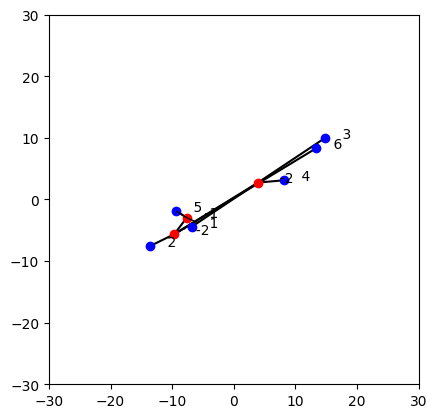

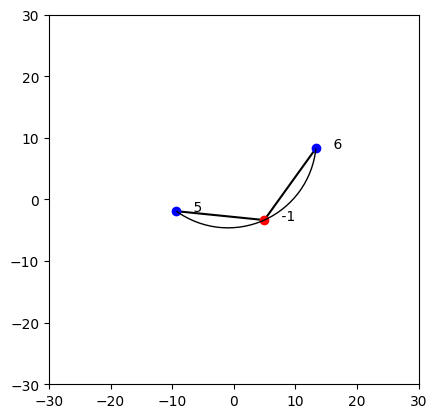

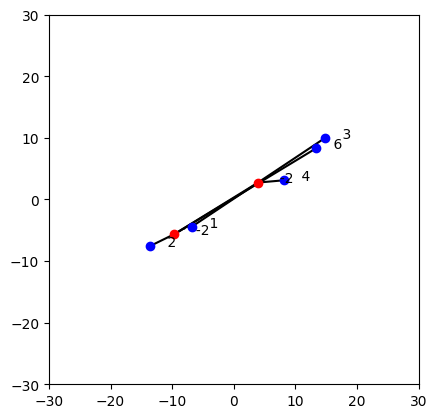

Last merge


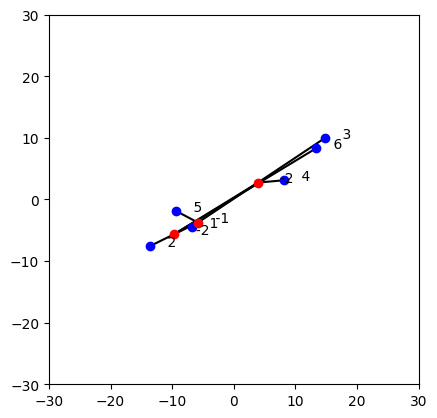

0

In [202]:
b = [[[-9.31, -1.9, 5, 8],
      [-13.55, -7.54, 2, 7],
      [13.33, 8.29, 6, 7],
      [14.74, 9.94, 3, 6],
      [8.18, 3.12, 4, 6],
      [-6.86, -4.45, 1, 6],
      [-1, -1, -2, 7, [8.18, 3.12], [14.74, 9.94, -6.86, -4.45]],
      [-1, -1, -2, 8, [13.33, 8.29], [-13.55, -7.54, -5.767484955488139, -3.7221624309941808]],
      [-1, -1, -1, -1, [-6.8147988645634285, 22.80181514167969], [-0.931599621521143, 9.730605047226563, 14.334174781502655, 4.611717591461705, 4.7500050456057465, 4.088118815863407, 4.36469372415149]]],
     [-6.8147988645634285, 22.80181514167969], [-0.931599621521143, 9.730605047226563, 14.334174781502655, 4.611717591461705, 4.7500050456057465, 4.088118815863407, 4.36469372415149],
     [1, 2, 3, 4, 5, 6], 50.158317829835866]
t = [-6.86, -4.45, 1, -1]
plot_branch(b)
# terminal_merge(b, t)

terminals = [[-12.1, 12.84], [-6.86, -4.45], [-13.55, -7.54], [14.74, 9.94], [8.18, 3.12], [-9.31, -1.9], [13.33, 8.29]]

terminals = [[[[terminals[t][0], terminals[t][1], t, -1]], [terminals[t][0], terminals[t][1]], [terminals[t][0], terminals[t][1], 0, 0, 0, 0, 0], [t], 0] for t in range(len(terminals))]
plot_branch(double_merge(terminals[5], terminals[6]))
plot_branch(triple_merge(terminals[2], terminals[6], triple_merge(terminals[3], terminals[4], terminals[1])))
midBranch = (triple_merge(terminals[2], terminals[6], triple_merge(terminals[3], terminals[4], terminals[1])))
print("Last merge")
plot_branch(double_merge(terminals[5], midBranch))
terminal_merge(double_merge(terminals[5], midBranch), t)
# plot_branch(double_merge(terminals[1],double_merge(terminals[2], terminals[3])))
# plot_branch(double_merge(double_merge(double_merge(terminals[1],double_merge(terminals[2], terminals[3])), terminals[4]), terminals[5]))
# plot_branch(double_merge(double_merge(double_merge(double_merge(terminals[1],double_merge(terminals[2], terminals[3])), terminals[4]), terminals[5]), terminals[6]))
# plot_branch(double_merge(terminals[0],double_merge(double_merge(double_merge(double_merge(terminals[1],double_merge(terminals[2], terminals[3])), terminals[4]), terminals[5]), terminals[6])))
# midBranch = double_merge(terminals[0],double_merge(double_merge(double_merge(double_merge(terminals[1],double_merge(terminals[2], terminals[3])), terminals[4]), terminals[5]), terminals[6]))
# print("Last merge")
# double_merge(midBranch, terminals[7])
# # plot_branch(double_merge(double_merge(terminals[0],double_merge(double_merge(double_merge(double_merge(terminals[1],double_merge(terminals[2], terminals[3])), terminals[4]), terminals[5]), terminals[6])), terminals[7]))

# labels = [1, 2, 0, 0, 2, 2, 0]
# plot_branch(double_merge(terminals[4], terminals[3]), double_merge(terminals[2], terminals[1]), double merge(terminals[6], terminals[0]))
# plot_branch(double_merge(terminals[2], terminals[1]))
# plot_branch(double_merge(double_merge(terminals[4], terminals[3]), double_merge(terminals[2], terminals[1])))
# print(double_merge(double_merge(terminals[4], terminals[3]), double_merge(terminals[2], terminals[1])))
# plot_branch(terminals[5])
# plot_branch(double_merge(double_merge(terminals[4], terminals[3]), double_merge(terminals[2], terminals[1])))
# plot_branch(double_merge(terminals[0], terminals[6]))


# plot_branch(triple_merge(terminals[5], 
#                          double_merge(double_merge(terminals[4], terminals[3]), double_merge(terminals[2], terminals[1])),
#                          double_merge(terminals[0], terminals[6])))

# print(double_merge(terminals[4], double_merge(terminals[6],double_merge(terminals[3], terminals[0]))))


In [49]:
# Testing Code


# n = 5
# trials = 100
# trialNum = -1
# while trialNum < 100:
#     trialNum = trialNum + 1
#     print("Trial", trialNum)
#     terminals = [[round(random.uniform(-15, 15), 2),round(random.uniform(-15, 15), 2)] for t in range(n)]
#     labels = [random.randint(0, 2) for i in range(n)]
#     # If all are sources, change the last one to a sink
#     if len([label for label in labels if label == 0]) == len(labels):
#         labels[-1] = 2
#     # If all are sinks, change the last one to a source
#     if len([label for label in labels if label == 2]) == len(labels):
#         labels[-1] = 0
    
#     noSameTerminals = AB_network_solver(terminals, labels, allowSameTerminals = False)
#     sameTerminals = AB_network_solver(terminals, labels, allowSameTerminals = True)

    # if abs(noSameTerminals[1] - sameTerminals[1]) > EPS:
    #     print("Interesting example!")
    #     print(terminals)
    #     print(labels)
    #    break







n = 7
terminals = [[round(random.uniform(-15, 15), 2),round(random.uniform(-15, 15), 2)] for t in range(n)]
labels = [random.randint(0, 2) for i in range(n)]
# 0 is source, 2 sink, 1 both
# If all are sources, change the last one to a sink
if len([label for label in labels if label == 0]) == len(labels):
    labels[-1] = 2
# If all are sinks, change the last one to a source
if len([label for label in labels if label == 2]) == len(labels):
    labels[-1] = 0

# # # NICO: Adding my own special nodes to test things
# # # HEXAGON
# # # Points (clockwise)
# Classic polygon
# p1 = [10*1,10*0]
# p2 = [10*0.5,10*-0.87]
# p3 = [10*-0.5,10*-0.87]
# p4 = [10*-1,10*0]
# p5 = [7*-0.5,7.5*0.87]
# p6 = [10*0.5,10*0.87]
# One point closer
# p1 = [10*1,10*0]
# p2 = [10*0.5,10*-0.87]
# p3 = [10*-0.5,10*-0.87]
# p4 = [10*-1,10*0]
# p5 = [7*-0.5,7.5*0.87]
# p6 = [10*0.5,10*0.87]

# Special
# p1 = [20*1,7.5*0.87]
# p2 = [10*0.5,10*-0.87]
# p3 = [10*-0.5,10*-0.87]
# p4 = [10*-1,10*0]
# p5 = [7*-0.5,7.5*0.87]
# p6 = [30*0.5,10*0.87]
# Special 2
# p1 = [25*1,11*0.87]
# p2 = [10*0.5,10*-0.87]
# p3 = [10*-0.5,10*-0.87]
# p4 = [10*-1,10*0]
# p5 = [10*-0.5,10*0.87]
# p6 = [50*0.5,15*0.87]
# terminals = [p1, p2, p3, p4, p5, p6]
# # Changing between source and sink
# labels = [0, 2, 0, 2, 0, 2]

# terminals = [[0,0], [2, 15], [-2, 15], [-10, -10], [10, -10], [-5, -20], [5,-20]]
# labels = [1, 2, 0, 0, 2, 2, 0]

# CHECK THIS
terminals = [[-12.1, 12.84], [-6.86, -4.45], [-13.55, -7.54], [14.74, 9.94], [8.18, 3.12], [-9.31, -1.9], [13.33, 8.29]]
labels = [1, 0, 2, 2, 0, 2, 2]

# terminals = [[-13.21, -4.02], [-1.51, -3.92], [-7.56, 1.25], [-14.84, 7.29], [-0.7, -12.02], [-1.91, -8.18], [12.26, 4.96]]
# labels = [1, 2, 2, 0, 2, 0, 0]

import time
print(terminals)
print(labels)
plot_tree([[],[]], terminals, labels)
t0 = time.time()


print("\n\n====== FIND TWO TREES SOLUTION ======\n\n")

print("Here should just call geosteiner twice, would for now find MST of sinks and sources ourselves.")
# Separate terminals into sinks and sources
two_trees_cost = find_two_tree_solution(terminals, labels)
t1 = time.time()
print("Two trees cost of", two_trees_cost)
print("\nElapsed time:", t1-t0, "s")
print("Total running time:", t1-t0, "s")



print("\n\n====== FIND FULL STEINER TREES ======\n\n")

trees = find_full_steiner_trees(terminals, allowSameTerminals = True)
# for tree in trees:
#     if len(tree[0]) <= 10:
#         continue
#     plot_tree(tree, terminals, labels)
# for tree in trees:
#     if len(tree[0]) < 3:
#         continue
#     for ver in tree[0]:
#         for ver2 in tree[0]:
#             if dist(ver, ver2) > EPS and dist(ver, ver2) < EPS2:
#                 print(ver)
#                 print(ver2)

t2 = time.time()
print("\nElapsed time:", t2-t1, "s")
print("Total running time:", t2-t0, "s")

print("\n\n======= GENERATE INPUT GRAPH ========\n\n")
graph = generate_input_graph(terminals, [], trees)
# for ver in graph[0]:
#     for ver2 in graph[0]:
#         if dist(ver, ver2) > EPS and dist(ver, ver2) < EPS2:
#             print(ver)
#             print(ver2)
# plot_tree(graph, terminals, labels)
t3 = time.time()
print("\nElapsed time:", t3-t2, "s")
print("Total running time:", t3-t0, "s")

print("\n\n======== FIND (A,B) NETWORK =========\n\n")
output = find_AB_network(graph, labels)
network = output[0]
solutionValue = output[1]
plot_tree(network, terminals, labels, network = True)
t4 = time.time()
print("\nElapsed time:", t4-t3, "s")
print("Total running time:", t4-t0, "s")
solutionTime = t4 - t1
solverTime = t4 - t3

if two_trees_cost != None:
    print("\n Rerun solver with a bound on solution cost\n")
    output = find_AB_network(graph, labels, costBound = two_trees_cost)
    networkBounded = output[0]
    solutionValueBounded = output[1]
    t4b = time.time()
    timeChangeWithBound = solverTime - (t4b - t4)
    if abs(solutionValueBounded - solutionValue) > EPS:
        print("This should not happen, bound on solution cost leads to different optimal solutions!\n")
        sys.exit()
    print("\nElapsed time:", t4b-t4, "s")
    print("Total running time:", t4b-t0, "s")
    t4 = t4b

# print("\n Rerun solver with additional variables on tree usage\n")
# output = find_AB_network(graph, labels, procedence = graph[2])
# networkWithProcedence = output[0]
# solutionValueWithProcedence = output[1]
# t4b = time.time()
# timeChangeWithProcedence = solverTime - (t4b - t4)
# if abs(solutionValueWithProcedence - solutionValue) > EPS:
#     print("This should not happen, bound on solution cost leads to different optimal solutions!\n")
#     sys.exit()
# print("\nElapsed time:", t4b-t4, "s")
# print("Total running time:", t4b-t0, "s")
# t4 = t4b
    




print("\n\n========= RUN QI HAO'S CODE =========\n\n")
try:
    qihaoValue = qi_hao_approach(terminals, labels)
except:
    print("Got an error in Qi Hao's run")
    qihaoValue = None
t5 = time.time()
print("\nElapsed time:", t5-t4, "s")
print("Total running time:", t5-t0, "s")
qihaoTime = t5 - t4


print("\n\n======== RUN ALEX'S APPROACH ========\n\n")

print("Find trees using only double merge:\n")
trees = find_full_steiner_trees(terminals, useTripleMerge = False)
t6 = time.time()
print("\nElapsed time:", t6-t5, "s")
print("Total running time:", t6-t0, "s")
print("\nGenerate input graph by adding a vertex at all crossing edges\n")
graph = generate_alex_input_graph(terminals, [], trees)
t7 = time.time()
print("\nElapsed time:", t7-t6, "s")
print("Total running time:", t7-t0, "s")
# plot_tree(graph, terminals, labels)
print("\nFind AB network\n")
output = find_AB_network(graph, labels)
network = output[0]
solutionValueAlex = output[1]
t8 = time.time()
print("\nElapsed time:", t8-t7, "s")
print("Total running time:", t8-t0, "s")
solutionTimeAlex = t8 - t5
plot_tree(network, terminals, labels, network = True)




print("\n\n============== SUMMARY ==============\n\n")

print("New solution cost:", solutionValue, "found in time", solutionTime)
if two_trees_cost != None:
    print("Solution time improvement with cost bound:", timeChangeWithBound)
# # # print("Solution time improvement with procedence variable:", timeChangeWithProcedence)

print("Alex solution cost:", solutionValueAlex, "found in time", solutionTimeAlex)
# # print("Qihao solution cost:", qihaoValue, "found in time", qihaoTime)




# print(trees)
# print(terminals)
# print(labels)








16.0


In [2]:
#QiHao's code
import gurobipy as gp
from gurobipy import GRB
import numpy as np
from matplotlib import pyplot as plt
import random
import time
import math
import networkx as nx
from scipy.spatial import distance
from SweepIntersectorLib.SweepIntersector import SweepIntersector

def qi_hao_approach(t, labels):
    def equilateral_triangle(A, B):
        # Extract x and y coordinates from points A and B
        Ax,Ay = A[0],A[1]
        Bx,By = B[0],B[1]
        # Calculate the x and y components of vector AB
        AB_x = Bx - Ax
        AB_y = By - Ay
        # Calculate the length of vector AB
        AB_length = np.sqrt(np.square(AB_x) + np.square(AB_y))
        # Calculate the values of cos(60°) and sin(60°), which are used to rotate vector AB to get vector AC
        cos60 = np.cos(np.pi / 3)
        sin60 = np.sin(np.pi / 3)
         # Rotate vector AB by 60 degrees using a rotation matrix to obtain the x and y components of vector AC
        AC_x = cos60 * AB_x - sin60 * AB_y
        AC_y = sin60 * AB_x + cos60 * AB_y
         # Calculate the coordinates of point C, which is A plus vector AC
        Cx1 = Ax + AC_x
        Cy1 = Ay + AC_y
        return np.array([Cx1,Cy1])
    
    def find_circle_center(point1, point2, point3):
        # Calculate the midpoint between two points
        midpoint12 = (point1 + point2) / 2
        midpoint23 = (point2 + point3) / 2
    
        # Calculate the slopes between the midpoints and the points
        slope12 = -(point2[0] - point1[0]) / ((point2[1] - point1[1]) + 1e-9)
        slope23 = -(point3[0] - point2[0]) / ((point3[1] - point2[1]) + 1e-9)
    
        # Calculate the x-coordinate of the circle center
        center_x = (slope12 * midpoint12[0] - slope23 * midpoint23[0] + midpoint23[1] - midpoint12[1]) / (slope12 - slope23 + 1e-9)
    
        #  Calculate the y-coordinate of the circle center
        center_y = slope12 * (center_x - midpoint12[0]) + midpoint12[1]
    
        # Get the coordinates of the circle center
        center = np.array([center_x, center_y])
    
        return center
    
    def compute_start_end_angle(center, start, end):
        # Extract the x and y coordinates of the center, start, and end points
        center_x, center_y = center
        start_x, start_y = start
        end_x, end_y = end
    
        # Calculate vectors from the center to the start and end points
        start_vector = np.array([start_x - center_x, start_y - center_y])
        end_vector = np.array([end_x - center_x, end_y - center_y])
        
        # Calculate the start and end angles in radians using arctan2
        start_angle = np.arctan2(start_vector[1], start_vector[0])
        end_angle = np.arctan2(end_vector[1], end_vector[0])
        
        # Ensure that the end angle is greater than the start angle
        if start_angle > end_angle:
            # Handle cases where the end angle is negative and the start angle is positive
            if end_angle < 0 and start_angle > 0:
                end_angle += 2*np.pi
        return start_angle, end_angle
    
    def arc_segment_intersection(c, r,start_angle, end_angle,p1, p2):    
        # Extract the center coordinates of the circle
        cx, cy = c
        # Extract the coordinates of points p1 and p2
        x1, y1 = p1
        x2, y2 = p2
         # Calculate the differences between x and y coordinates of p2 and p1
        dx = x2 - x1
        dy = y2 - y1
        
        # Calculate the coefficients of the parametric equation of the line segment
        A = dx**2 + dy**2
        B = 2 * (dx * (x1 - cx) + dy * (y1 - cy))
        C = (x1 - cx)**2 + (y1 - cy)**2 - r**2
        
        # Calculate the discriminant of the quadratic equation
        discriminant = B**2 - 4 * A * C
        
        # Check if there are real solutions (intersection points)
        if discriminant <= 0:
            # No real solutions, the line segment does not intersect the circle
            return None
        else:
            # Two intersection points exist, the line segment intersects the circle
            t1 = (-B + np.sqrt(discriminant)) / (2 * A)
            # Check if the first intersection point lies on the line segment
            if 0 <= t1 <= 1:
                intersection1_x = x1 + t1 * (x2 - x1)
                intersection1_y = y1 + t1 * (y2 - y1)
                # Calculate the angle of the first intersection point relative to the circle center
                angle1 = np.arctan2(intersection1_y - cy, intersection1_x - cx)
                
                # Check if the angle lies within the specified start and end angles of the arc
                if (angle1 > start_angle and angle1 < end_angle) or (angle1+2*np.pi > start_angle and angle1+2*np.pi < end_angle):
                    return np.array([intersection1_x, intersection1_y])
    
    def on_segment(p, p1, p2):
        # Check if a point 'p' lies on the line segment defined by 'p1' and 'p2'
        # Calculate the cross product of vectors (p2-p1) and (p-p1)
        
        cross_product = np.cross(p2-p1, p-p1)
        
        # Check if the cross product is significantly non-zero (not colinear)
        if abs(cross_product) > 1e-10:
            return False
        
        # Calculate the dot product of vectors (p-p1) and (p2-p1)
        dot_product = np.dot(p-p1, p2-p1)
        
        # Check if 'p' is between the two endpoints (p1 and p2)
        if dot_product < 0:
            return False
    
        squared_length = np.dot(p2-p1, p2-p1)
        if dot_product > squared_length:
            return False
    
        return True
    
    def arc_ray_intersection(c, r,start_angle, end_angle,p1, p2):
        # Extract the center coordinates of the circle
        cx, cy = c
        
        # Extract the coordinates of points p1 and p2
        x1, y1 = p1
        x2, y2 = p2
        
        # Calculate the differences between x and y coordinates of p2 and p1
        dx = x2 - x1
        dy = y2 - y1
        
        # Calculate the coefficients of the parametric equation of the line segment
        A = dx**2 + dy**2
        B = 2 * (dx * (x1 - cx) + dy * (y1 - cy))
        C = (x1 - cx)**2 + (y1 - cy)**2 - r**2
        
         # Calculate the discriminant of the quadratic equation
        discriminant = B**2 - 4 * A * C
        
        # Check if there are real solutions (intersection points)
        if discriminant <= 0:
            # No real solutions, the line segment does not intersect the circle
            return None
    
        else:
             # Two intersection points exist, the line segment intersects the circle
            t1 = (-B + np.sqrt(discriminant)) / (2 * A)
                    
            if t1 >= 0:
                intersection1_x = x1 + t1 * (x2 - x1)
                intersection1_y = y1 + t1 * (y2 - y1)
                angle1 = np.arctan2(intersection1_y - cy, intersection1_x - cx)
                
                if (angle1 > start_angle and angle1 < end_angle) or (angle1+2*np.pi > start_angle and angle1+2*np.pi < end_angle):
                    return np.array([intersection1_x, intersection1_y])
    
    def find_circle_intersection(center1, radius1, center2, radius2):
        # Calculate the distance between the two circle centers
        distance = np.linalg.norm(center2 - center1)
        
        # Check for cases where circles are disjoint or one is contained within the other
        if distance > radius1 + radius2 or distance < np.abs(radius1 - radius2):
            return None  # No intersection
        
        # Check for the case where circles are concentric (infinite intersection points)
        if distance == 0 and radius1 == radius2:
            return None   # Infinite intersection points, circles overlap
        
        # Calculate intersection points
        direction = (center2 - center1) / distance
        cos_angle = (radius1**2 + distance**2 - radius2**2) / (2 * radius1 * distance)
        sin_angle = np.sqrt(1 - cos_angle**2)
        
        intersection1 = center1 + radius1 * cos_angle * direction + radius1 * sin_angle * np.array([-direction[1], direction[0]])
        intersection2 = center1 + radius1 * cos_angle * direction - radius1 * sin_angle * np.array([-direction[1], direction[0]])
        
        return intersection1, intersection2
    
    def find_arc_intersection(center1, radius1, start_angle1, end_angle1, center2, radius2, start_angle2, end_angle2):
        
        # Use the circle intersection method to find the intersections of the two circles
        intersections = find_circle_intersection(center1, radius1, center2, radius2)
        valid_intersections = None
        if intersections:
            for intersection in intersections:
                 # Calculate the angles of the intersection points relative to the circle centers
                angle1 = np.arctan2(intersection[1] - center1[1], intersection[0] - center1[0])
                angle2 = np.arctan2(intersection[1] - center2[1], intersection[0] - center2[0])
    
                # Check if the angles are within the specified arc angle ranges
                if start_angle1 <= angle1 <= end_angle1 or  start_angle1 <= angle1+2*np.pi <= end_angle1:
                    if start_angle2 <= angle2 <= end_angle2 or start_angle2 <= angle2+2*np.pi <= end_angle2:
                        valid_intersections = intersection
        
        return valid_intersections
    
    def ray_intersection(p1, v_1, p2, v_2):
        # Calculate the direction vectors v1 and v2 from points p1 and p2
        v1 = v_1 - p1
        v2 = v_2 - p2
        
        # Convert vectors to NumPy arrays
        dp = p2-p1
        dp = np.squeeze(np.asarray(dp))
        v1 = np.squeeze(np.asarray(v1))
        v2 = np.squeeze(np.asarray(v2))
        
        # Calculate the cross product dp x v2
        dp_x_v2 = dp[0]*v2[1] - dp[1]*v2[0]
        # Calculate the cross product v1 x v2
        v1_x_v2 = v1[0]*v2[1] - v1[1]*v2[0]
        if v1_x_v2 != 0:
            # Calculate the parameter t1 for the intersection
            t1 = dp_x_v2 / v1_x_v2
            if t1 > 0:
                # Calculate the intersection point using parameter t1
                intersection = p1 + t1*v1
                return intersection
            else:
                return None
        else:
            return None
    
    def segments_intersect(a,b):
        # Extract the endpoints of segments 'a' and 'b'
        a1, a2 = a[0], a[1]
        b1, b2 = b[0], b[1]
        
        # Calculate the direction vectors 'da' and 'db' for segments 'a' and 'b'
        da = a2-a1
        db = b2-b1
        # Calculate the vector 'dp' from the start of segment 'a' to the start of segment 'b'
        dp = a1-b1
        # Calculate the perpendicular vector 'dap' to 'da' (used in the cross product)
        dap = np.array([-da[1], da[0]])
        
        denom = np.dot( dap, db)
        num = np.dot( dap, dp )
        
        if denom.astype(float)==0:
             # Segments are parallel, no intersection
            return None
        
        # Calculate the parameter 't1' for the intersection
        t1 = (num / denom.astype(float))
        if 0 <= t1 <= 1: 
            # Calculate the intersection point 'p' using parameter 't1'
            p = (num / denom.astype(float))*db + b1
            if on_segment(p,a1,a2) and on_segment(p,b1,b2):
                return p
        else:
            return None
    
    def find_branch_d3(b1, b2):
        #define the pseudo terminals of branch b1 and b2
        start_p, end_p = Branch[b1]['e'], Branch[b2]['e']
        
        # find the equilateral point of b1 and b2
        e2 = equilateral_triangle(start_p, end_p)
        
        #find the circle center and its radius generated by equilateral point, b1 and b2
        center2 = find_circle_center(e2, start_p, end_p)
        radius2 = np.linalg.norm(center2 - start_p)
        
        #consider the degree 4 case
        constant_b1, constant_b2 = Branch[b1]['constant'], Branch[b2]['constant']
        constant = constant_b1.union(constant_b2)
        
        #compute the initial left angle and right angle
        start_angle2, end_angle2 = compute_start_end_angle(center2, start_p, end_p)
        a, b = start_p, end_p
            
        values = [e2, center2, radius2, start_angle2, end_angle2, a, b, 3, constant]
        
        # projection pruning test
        if [start_p[0], start_p[1]] not in P1:
            values = projection_d3_start(values[0], values[1], values[2], values[3], values[4], values[5], values[6], values[7],values[8], b1)
            if type(values) == type(None):
                return None
            
        if [end_p[0], end_p[1]] not in P1:
            values = projection_d3_end(values[0], values[1], values[2], values[3], values[4], values[5], values[6], values[7],values[8], b2)
            if type(values) == type(None):
                return None
        
        if values[3] > values[4]:
            return None
        
        return values
    
    def projection_d3_start(e2, center2, radius2, start_angle2, end_angle2, a, b, degree,constant, b_1):
        
        start_p = Branch[b_1]['e']
        center1, radius1 = Branch[b_1]['center'], Branch[b_1]['radius']
        start_angle1, end_angle1 = Branch[b_1]['start_angle'], Branch[b_1]['end_angle']
        
        if radius1 >= radius2:
            return None
       
        #Updating the feasible arc by calculating the intersection points.
        # compute the ray intersection
        p1, p2 = start_p, Branch[b_1]['a']
        start_test = arc_ray_intersection(center2, radius2, start_angle2, end_angle2, p1, p2)
        p1, p3 = start_p, Branch[b_1]['b']
        end_test = arc_ray_intersection(center2, radius2, start_angle2, end_angle2, p1, p3)
       
        #compute the arc intersection
        arc_test = find_arc_intersection(center1, radius1, start_angle1, end_angle1, center2, radius2, start_angle2, end_angle2)
        
        # push the feasible arc
        test = 0
        if type(start_test) != type(None):
            if on_segment(start_test,p1, p2):
                return None
            a = start_test
            test = 1
        if type(end_test) != type(None):
            if on_segment(end_test,p1, p3):
                return None
            b = end_test
            test = 1
        if type(arc_test) != type(None):
            a = arc_test
            test = 1
        
        if test == 0:
            return None
    
        start_a, end_a = compute_start_end_angle(center2, a, b)
        values = [e2, center2, radius2, start_a, end_a, a, b, 3, constant]
        return values
    
    def projection_d3_end(e2, center2, radius2, start_angle2, end_angle2, a, b, degree,constant, b_2):
        
        start_p = Branch[b_2]['e']
        center1, radius1 = Branch[b_2]['center'], Branch[b_2]['radius']
        start_angle1, end_angle1 = Branch[b_2]['start_angle'], Branch[b_2]['end_angle']
        
        if radius1 >= radius2:
            return None
        
        #Updating the feasible arc by calculating the intersection points.
        #Compute the ray intersection
        p1, p2 = start_p, Branch[b_2]['a']
        start_test = arc_ray_intersection(center2, radius2, start_angle2, end_angle2, p1, p2)
        p1, p3 = start_p, Branch[b_2]['b']
        end_test = arc_ray_intersection(center2, radius2, start_angle2, end_angle2, p1, p3)
       
        #compute the arc intersection
        arc_test = find_arc_intersection(center1, radius1, start_angle1, end_angle1, center2, radius2, start_angle2, end_angle2)
    
        # push the feasible arc
        test = 0
        if type(start_test) != type(None):
            if on_segment(start_test,p1, p2):
                return None
            a = start_test
            test = 1
        if type(end_test) != type(None):
            if on_segment(end_test,p1, p3):
                return None
            b = end_test
            test = 1
        if type(arc_test) != type(None):
            b = arc_test
            test = 1
        
        if test == 0:
            return None
        
        start_a, end_a = compute_start_end_angle(center2, a, b)
        
        
        values = [e2, center2, radius2, start_a, end_a, a, b, 3, constant]
        return values
    
    def find_branch_d4(b3, segment,constant_b2):
    
        start_angle1, end_angle1 = Branch[b3]['start_angle'], Branch[b3]['end_angle']
        center, radius = Branch[b3]['center'],Branch[b3]['radius']
        p1, p2, p3 = Branch[b3]['e'], Branch[b3]['a'],  Branch[b3]['b']
        
        constant_b3 = Branch[b3]['constant']
        constant = constant_b3.union(constant_b2)
        
        radius1 = np.linalg.norm(p1 - segment[0])
        radius2 = np.linalg.norm(p1 - segment[1])
        
        if radius2 < radius and radius1 < radius:
            return None
        
        # try to find the left point and the right point
        e1 = equilateral_triangle(segment[0], segment[1])
        e2 = equilateral_triangle(segment[1], segment[0])
        
        if np.linalg.norm(p1 - e1) >  np.linalg.norm(p1 - e2):
            a, b = segment[1], segment[0]
        else:
            b, a = segment[1], segment[0]
            
        # if p1 is termianls then there is no need to do the projection pruning test
        if type(p2) == type(None) and type(p3) == type(None):
            e2 = equilateral_triangle(a, b)
            center2 = find_circle_center(e2, a, b)
            a_angle, b_angle = compute_start_end_angle(center2, a, b)
            values = [p1, center2, radius2, a_angle, b_angle, a, b, 4, constant]
            return values
            
        # pruning test
        values = projection_d4(segment, p1, p2, p3, center, radius, start_angle1, end_angle1, constant, a, b)
        
        return values
    
    def projection_d4(segment, p1, p2, p3, center, radius, start_angle1, end_angle1, constant,a,b):
        
        test = 0
        start_test = ray_intersection(segment[0], segment[1], p1, p2)
        end_test = ray_intersection(segment[0], segment[1], p1, p3)
        
        # test if it is conlinear
        if type(start_test) == type(None) or type(end_test) == type(None):
            return None
        if on_segment(start_test, p1,p2):
            return None
        if on_segment(end_test, p1, p3):
            return None
        
        # compute the intersection
        if on_segment(start_test, segment[0], segment[1]):
            a = start_test
            test = 1
        if on_segment(end_test, segment[0], segment[1]):
            b = end_test
            test = 1
                
        e2 = equilateral_triangle(a, b)
        center2 = find_circle_center(e2, a, b)
        a_angle, b_angle = compute_start_end_angle(center2, a, b)
        
        # if the line segment is not in the region, then remove this branch
        if test == 0:
            if start_angle1 > a_angle or a_angle > end_angle1 or end_angle1 < b_angle or b_angle < start_angle1:
                return None
        
        radius2 = np.linalg.norm(center2 - a)
    
        values = [p1, center2, radius2, a_angle, b_angle, a, b, 4, constant]
        return values
    
    def dfs(visited, graph, node, parents):  #function  dfs 
        if node not in visited:
            visited.append(node)
            for neighbour in Children[node]:
                parents[tuple(Branch[neighbour]['e'])] = Branch[node]['e']
                dfs(visited, graph, neighbour, parents)
    
    def Construct_FSC(x,y): 
        # we do not need to constrcut FSC twice
        # x and y means the pesudo terminal
        if x > y:
            return None
        
        FST = set()
        parents = {}
        
        Steiner_x = None
        Steiner_y = None
        inital_segement = None
        total_distance = 0
        
        # try to find the first Steiner point with x and y
        dfs_y = []
        if list(Branch[y]['e']) not in P1 or Branch[y]['degree'] == 4:
            dfs(dfs_y, Children,y, parents)
            
        dfs_x = []
        if list(Branch[x]['e']) not in P1 or Branch[x]['degree'] == 4:
            dfs(dfs_x, Children,x, parents)
        
        if Children[y]:
            c,r,start_angle, end_angle, p1, a, b, d,p2 = (Branch[y]['center'],
                                       Branch[y]['radius'], 
                                       Branch[y]['start_angle'],
                                       Branch[y]['end_angle'],
                                       Branch[y]['e'], 
                                       Branch[y]['a'],
                                       Branch[y]['b'],
                                       Branch[y]['degree'],
                                       Branch[x]['e'])
            if d == 3:
                Steiner_y  = arc_segment_intersection(c, r,start_angle, end_angle, p1, p2)
                # if there is no intersection that means there is no Steiner point
                if type(Steiner_y) == type(None):
                    return None
                else:
                    parents[tuple(Branch[x]['e'])] = Steiner_y
                    
            if d == 4:
                C = Branch[y]['constant']
                Steiner_y = segments_intersect([a,b],[p1,p2])
                # if there is no intersection that means there is no Steiner point
                if type(Steiner_y) != type(None):
                    parents[tuple(Branch[x]['e'])] = p2
                else:
                    return None
        else:
            parents[tuple(Branch[x]['e'])] = Branch[y]['e']
    
            
        if Children[x]:
            c,r,start_angle, end_angle, p1, a, b, d, p2 = (Branch[x]['center'],
                                       Branch[x]['radius'], 
                                       Branch[x]['start_angle'],
                                       Branch[x]['end_angle'],
                                       Branch[x]['e'], 
                                       Branch[x]['a'],
                                       Branch[x]['b'],
                                       Branch[x]['degree'],
                                       Branch[y]['e'])
            if d == 3:
                Steiner_x  = arc_segment_intersection(c, r,start_angle, end_angle, p1, p2)
                if type(Steiner_x) == type(None):
                    # if there is no intersection that means there is no Steiner point
                    return None
                else:
                    parents[tuple(Branch[y]['e'])] = Steiner_x
                    
            if d == 4:
                C = Branch[x]['constant']
                Steiner_x = segments_intersect([a,b],[p1,p2])
                if type(Steiner_x) != type(None):
                    parents[tuple(Branch[y]['e'])] = p2
                else:
                    return None
    
        else:
            parents[tuple(Branch[y]['e'])] = Branch[x]['e']
    
            # if there is no Steiner point for both branch then remove
        if type(Steiner_y) == type(None) and type(Steiner_x) == type(None):
            return None
        
        
        if type(Steiner_y) != type(None) and type(Steiner_x) != type(None):
            FST.add((tuple(Steiner_y),tuple(Steiner_x)))
            inital_segement = [np.array(Steiner_y),np.array(Steiner_x)]
            for child in Children[y]:
                parents[tuple(Branch[child]['e'])] = Steiner_y
            for child in Children[x]:
                parents[tuple(Branch[child]['e'])] = Steiner_x
    
        if type(Steiner_y) != type(None) and list(Branch[x]['e']) in P1 and Branch[x]['degree'] != 4:
            inital_segement = [np.array(Steiner_y),Branch[x]['e']]
            FST.add((tuple(Branch[x]['e']), tuple(Steiner_y)))
    
    
        if type(Steiner_x) != type(None) and list(Branch[y]['e']) in P1 and Branch[y]['degree'] != 4:
            inital_segement = [np.array(Steiner_x),Branch[y]['e']]
            FST.add((tuple(Branch[y]['e']), tuple(Steiner_x)))
        
        for v in dfs_y:
            if Children[v] and type(parents[tuple(Branch[v]['e'])]) != type(None):
                c,r,start_angle, end_angle, p1, a, b, d, p2 = (Branch[v]['center'],
                                        Branch[v]['radius'], 
                                        Branch[v]['start_angle'],
                                        Branch[v]['end_angle'],
                                        Branch[v]['e'], 
                                        Branch[v]['a'], 
                                        Branch[v]['b'], 
                                        Branch[v]['degree'],
                                        parents[tuple(Branch[v]['e'])])
                
                if d == 3:
                    Steiner  = arc_segment_intersection(c, r,start_angle, end_angle, p1, p2)
                    if type(Steiner) == type(None):
                     # if there is no intersection that means there is no Steiner point
                        return None
                
                if d == 4:
                    C = Branch[v]['constant']
                    Steiner = segments_intersect([a,b],[p1,p2])
                    if type(Steiner) == type(None):
                    # if there is no intersection that means there is no Steiner point
                        return None
                    for edge in C:
                        FST.add(edge)
                    total_distance += sum( distance.euclidean(i[0],i[1]) for i in C)
                
                if v != y:
                    FST.add((tuple(parents[tuple(Branch[v]['e'])]), tuple(Steiner)))
                    
                for child in Children[v]:
                    parents[tuple(Branch[child]['e'])] = Steiner
            
            elif type(parents[tuple(Branch[v]['e'])]) != type(None):
                FST.add((tuple(parents[tuple(Branch[v]['e'])]), tuple(Branch[v]['e'])))
                                                    
                                                
        for v in dfs_x:
            if Children[v] and type(parents[tuple(Branch[v]['e'])]) != type(None):
                c,r,start_angle, end_angle, p1, a, b, d,  p2 = (Branch[v]['center'],
                                        Branch[v]['radius'], 
                                        Branch[v]['start_angle'],
                                        Branch[v]['end_angle'],
                                        Branch[v]['e'], 
                                        Branch[v]['a'], 
                                        Branch[v]['b'], 
                                        Branch[v]['degree'],
                                        parents[tuple(Branch[v]['e'])])
                if d == 3:
                    Steiner  = arc_segment_intersection(c, r,start_angle, end_angle, p1, p2)
                    if type(Steiner) == type(None):            # if there is no intersection that means there is no Steiner point
                        return None
    
                if d == 4:
                    C = Branch[v]['constant']
                    Steiner = segments_intersect([a,b],[p1,p2])
                    if type(Steiner) == type(None):            # if there is no intersection that means there is no Steiner point
                        return None
                    for edge in C:
                        FST.add(edge)
                    total_distance += sum( distance.euclidean(i[0],i[1]) for i in C)
    
                if v != x:
                    FST.add((tuple(parents[tuple(Branch[v]['e'])]), tuple(Steiner)))
                
                for child in Children[v]:
                    parents[tuple(Branch[child]['e'])] = Steiner
            
            elif type(parents[tuple(Branch[v]['e'])]) != type(None):
                FST.add((tuple(parents[tuple(Branch[v]['e'])]), tuple(Branch[v]['e'])))
        
        total_distance = total_distance + sum( distance.euclidean(i[0],i[1]) for i in FST)
    
        # NICO: Removing this as it is giving problems
        # Hamitonian cycle pruning test
        # p = order[x].union(order[y])
        # p = tuple([tuple(P1[i]) for i in sorted(tuple(p))])
        # if p not in Ham_cycle_dict.keys() and len(p) > 3:
        #     n = len(p)
        #     Ham_cycle_dict[p]= Ham_cycle(p,n)
        #     if total_distance > Ham_cycle_dict[p]:
        #         return None
        
        # if p in Ham_cycle_dict.keys():
        #     if total_distance > Ham_cycle_dict[p]:
        #         return None
        
        return FST,inital_segement
    
    from itertools import combinations, chain
    def Ham_cycle(P,n):
        points = P
        dist = {(i, j):
                math.sqrt(sum((points[i][k]-points[j][k])**2 for k in range(2)))
                for i in range(n) for j in range(i)}
    
        m = gp.Model()
        m.Params.OutputFlag= 0
    
        x = m.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='x')
    
        for i, j in x.keys():
            x[j, i] = x[i, j]  # edge in opposite direction
    
        m.addConstrs(x.sum(i, '*') == 2 for i in range(n))
    
        # Optimize model
        m._x = x
        m.Params.LazyConstraints = 1
    
        def subtourelim(model, where):
            if where == GRB.Callback.MIPSOL:
                vals = model.cbGetSolution(model._x)
                tour = subtour(vals)
                if len(tour) < n:
                    model.cbLazy(gp.quicksum(model._x[i, j]
                                             for i, j in combinations(tour, 2))
                                 <= len(tour)-1)
        def subtour(vals):
            edges = gp.tuplelist((i, j) for i, j in vals.keys()
                             if vals[i, j] > 0.5)
            unvisited = list(range(n))
            cycle = range(n+1) 
            while unvisited:  
                thiscycle = []
                neighbors = unvisited
                while neighbors:
                    current = neighbors[0]
                    thiscycle.append(current)
                    unvisited.remove(current)
                    neighbors = [j for i, j in edges.select(current, '*')
                             if j in unvisited]
                if len(cycle) > len(thiscycle):
                    cycle = thiscycle
            return cycle
        m.Params.OutputFlag= 0
        m.optimize(subtourelim)
    
        vals = m.getAttr('X', x)
        tour = subtour(vals)
        return m.ObjVal
    
    
    


    
    P = [np.array(terminal) for terminal in t]
    P1 = copy.deepcopy(t)
    A = [tuple(t[i]) for i in range(len(t)) if labels[i] >= 1]
    B = [tuple(t[i]) for i in range(len(t)) if labels[i] <= 1]
    T = labels


    start1 = time.time()

    # P = [np.array([5.34, 3.87]), np.array([8.16, 6.79]), np.array([-9.32, 13.93]), np.array([12.8 , 12.13]), np.array([14.35, -6.38])]
    # P1 = [[5.34, 3.87], [8.16, 6.79], [-9.32, 13.93], [12.8, 12.13], [14.35, -6.38]]
    # A = [(-9.32, 13.93), (12.8, 12.13)]
    # B = [(5.34, 3.87), (8.16, 6.79), (14.35, -6.38)]
    # T = [0, 0, 2, 2, 0]

    Children = {}
    for p in P:
        Children[tuple(p)] = []
    Ham_cycle_dict  = {}
    
    n = len(P)
    repeat_set = []
    Branch_total = [[] for k in range(n+1)]
    Children = {}
    keys = ['e','center','radius', 'start_angle','end_angle','a','b','degree','constant']
    order = {}
    
    FSC_intersection = {}
    
    
    Branch = {}
    c = 0
    
    FSCs = []
    FSC_total = [[] for k in range(n+1)]
    FSC_branch = {}
    
    branch_num = 0    
    FSC_num = 0
    
    for p in P:
        print(p)
        Branch_total[1].append(branch_num)
        Children[branch_num] = []
        order[branch_num] = {branch_num}
        values = [p, p, 0, 0, 2*np.pi, None, None, None,set()]
        Branch[branch_num] = dict(zip(keys,values))
        branch_num += 1
    
    
    # GeoSteiner phase
    for k in range(2,n+1):
        s = time.time()
        s1 = time.time()
        # Classic GeoSteiner phase, double merge
        for l in range(1,(k//2)+1):
            for b1 in Branch_total[l]:
                for b2 in Branch_total[k-l]:
                    if not order[b1].intersection(order[b2]):
                        if k < n:
                            values = find_branch_d3(b1, b2)
                            if type(values) != type(None):
                                Children[branch_num] = [b1, b2]
                                Branch[branch_num] = dict(zip(keys,values))
                                Branch_total[k].append(branch_num)
                                order[branch_num] = order[b1].union(order[b2])
                                branch_num += 1
    
                        #Construte FSC
                        if k >= 2:
                            if k > 2:
                                FSC = Construct_FSC(b1,b2)
                            if k == 2:
                                if b1 > b2:
                                    FSC = [{(tuple(Branch[b1]['e']),tuple(Branch[b2]['e']))},[Branch[b1]['e'],Branch[b2]['e']]]
                                else:
                                    FSC = None
                            if type(FSC) != type(None):
                                FSC_branch[FSC_num] = FSC
                                FSC_intersection[FSC_num] = order[b1].union(order[b2])
                                FSC_total[k].append(FSC_num)
                                FSC_num += 1
                                FSCs.append(FSC[0])
        e1 = time.time()
        print("total time at stage 1 in ",k,"floor",e1-s1)
        
        # Search for all current branch and megre with odd FSC
        s2 = time.time()
        for b3 in Branch_total[k]:
            for k2 in range(2, k+1):
                if k + k2 < n:
                     for f1 in FSC_total[k2]:
                        if not FSC_intersection[f1].intersection(order[b3]):
                            values = find_branch_d4(b3, FSC_branch[f1][1], FSC_branch[f1][0])
                            if type(values) != type(None):
                                order[branch_num] = order[b3].union(FSC_intersection[f1])
                                Children[branch_num] = [b3]
                                Branch[branch_num] = dict(zip(keys,values))
                                Branch_total[k2 + k].append(branch_num)
                                branch_num += 1
        
        e2 = time.time()
        print("total time at stage 2 in ",k,"floor",e2-s2)
    
        # Search for all current FSC and megre with odd branch
        s3 = time.time()
        for f2 in FSC_total[k]:
            for k1 in range(1, k):
                if k1 + k < n:
                    for b4 in Branch_total[k1]:
                        if not FSC_intersection[f2].intersection(order[b4]):
                            values = find_branch_d4(b4, FSC_branch[f2][1], FSC_branch[f2][0])
                            if type(values) != type(None):
                                order[branch_num] = FSC_intersection[f2].union(order[b4])
                                Children[branch_num] = [b4]
                                Branch[branch_num] = dict(zip(keys,values))
                                Branch_total[k1 + k].append(branch_num)
                                branch_num += 1
        
        e3 = time.time()
        print("total time at stage 3 in ",k,"floor",e3-s3)
        
        
                                                        
        e = time.time()
        print("total time in ",k," floor",e-s)
    end1 = time.time()

    # find the intersection for all FSC
    FSCs_intersection = []
    for fsc in FSCs:
        isector = SweepIntersector()
        Edge = [edge for edge in fsc]
        isectDic = isector.findIntersections(Edge)
        count_intersection = 0
        for seg,isects in isectDic.items():
            count_intersection = len(isects[1:-1])
            count = 0
            while count+1 < len(isects):
                Edge.append(((isects[count][0],isects[count][1])
                            ,(isects[count+1][0],isects[count+1][1])))
                count = count + 1
            if seg in Edge:
                Edge.remove(seg)
        FSCs_intersection.append(Edge)

    P2 = [tuple(i) for i in P1]
    E_count = {}
    count = 0
    C = {}
    
    # reomve all edges and add double arcs
    for fst in FSCs_intersection:
        for i in range(len(fst)):
            length = distance.euclidean(list(fst)[i][0], list(fst)[i][1])
            if length > 1e-6:
                E_count[count] = (tuple(list(fst)[i][0]),tuple(list(fst)[i][1]))
                C[count] = length
                count += 1
                E_count[count] = (tuple(list(fst)[i][1]),tuple(list(fst)[i][0]))
                C[count] = length
                count += 1
    multi = {}
    for i in range(len(C)):
        multi[E_count[i]] = C[i]
    arc,cost = gp.multidict(multi)
    G = nx.DiGraph()
    G.add_edges_from(arc)
    G_neighbor = {}
    for node in G:
        G_neighbor[node] = list(G.neighbors(node))
    combin = []
    for a in A:
        for b in B:
            if a != b:
                combin.append((a,b))

    start_ILP1 = time.time()


    m = gp.Model('Steiner')
    
    time_1 = time.time()
    flow = m.addVars(combin,arc,vtype=GRB.BINARY, name = 'x')
    time_1_end = time.time()
    # print('flow',len(flow),time_1_end-time_1)
    
    
    time_1 = time.time()
    cap= m.addVars(arc, vtype = GRB.BINARY,name = 'y')
    time_1_end = time.time()
    # print(len(cap))
    # print('cap',time_1_end-time_1)
    
    time_1 = time.time()
    flow_constrain1 = m.addConstrs(gp.quicksum(flow[a,b,a,v] for v in G_neighbor[a]) - 
                                   gp.quicksum(flow[a,b,v,a] for v in G_neighbor[a]) 
                                   ==  1 for (a,b) in combin)
    time_1_end = time.time()
    # print(len(flow_constrain1))
    # print('constrain1',time_1_end-time_1)
    
    time_1 = time.time()
    flow_constrain2 = m.addConstrs(gp.quicksum(flow[a,b,b,v] for v in G_neighbor[b]) - 
                                   gp.quicksum(flow[a,b,v,b] for v in G_neighbor[b]) 
                                   ==  -1 for (a,b) in combin)
    time_1_end = time.time()
    # print(len(flow_constrain2))
    # print('constrain2',time_1_end-time_1)
    
    
    time_1 = time.time()
    flow_constrain3 = m.addConstrs(gp.quicksum(flow[a,b,v1,v2] for v1 in G_neighbor[v2] if v2 != a and v2 != b) == 
                                   gp.quicksum(flow[a,b,v2,v3] for v3 in G_neighbor[v2] if v2 != a and v2 != b) 
                                   for v2 in G for (a,b) in combin)
    time_1_end = time.time()
    # print(len(flow_constrain3))
    # print('constrain3',time_1_end-time_1) 
    
    time_1 = time.time()
    flow_constrain4 = m.addConstrs(flow[a,b,i[0],i[1]] <= cap[i] for i in arc for (a,b) in combin)
    time_1_end = time.time()
    # print(len(flow_constrain4))
    # print('constrain4',time_1_end-time_1)
    
    
    m.setObjective(gp.quicksum(cost[i]*cap[i] for i in arc), GRB.MINIMIZE)
    m.optimize()
    
    m.write("model.lp")
    # for v in m.getVars():
    #     if v.x > 1e-6:
    #         print(v.varName, v.x)
    
    print('Total value: ', m.objVal)
    solverValue = m.objVal
    end_ILP1 = time.time()

    P2 = [(i,j) for (i,j) in P1]
    vals = m.getAttr('X', cap)
    Edge_graph = []
    Vertex_graph = []
    
    for i in arc:
        if vals[i]> 1e-6:
            Edge_graph.append(((float(i[0][0]),float(i[0][1])),(float(i[1][0]),float(i[1][1]))))
            
    for i in Edge_graph:
        for j in i:
            if j not in Vertex_graph:
                Vertex_graph.append(j)
    Edge = []
    for i in range(len(Edge_graph)):
        for j in range(len(Vertex_graph)):
            if Edge_graph[i][0] == Vertex_graph[j]:
                p1 = j
            if Edge_graph[i][1] == Vertex_graph[j]:
                p2 = j
        Edge.append((p1,p2))
    fig, ax = plt.subplots()
    plt.title('AB Network')

    # NICO: Make it square
    ax.set_aspect('equal', adjustable='box')

    G = nx.DiGraph()
    G.add_edges_from(Edge)
    list_deg2 = []


    colour_map = []
    for i in G:
        if Vertex_graph[i] in A and Vertex_graph[i] not in B:
            colour_map.append('red')
        if Vertex_graph[i] in B and Vertex_graph[i] not in A:
            colour_map.append('blue')
        if Vertex_graph[i] in A and Vertex_graph[i] in B:
            colour_map.append('purple')
        if Vertex_graph[i] not in A and Vertex_graph[i] not in B:
            colour_map.append('y')
    
    nx.draw(G, Vertex_graph, with_labels=False, node_color=colour_map, node_size = 10)
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    minX = min([min(i[0][0], i[1][0]) for i in arc])
    maxX = max([max(i[0][0], i[1][0]) for i in arc])
    rangeX = maxX - minX
    minY = min([min(i[0][1], i[1][1]) for i in arc])
    maxY = max([max(i[0][1], i[1][1]) for i in arc])
    rangeY = maxY - minY
    
    plt.xlim(minX,maxX)
    plt.ylim(minY,maxY)

    plt.xlim(-20,20)
    plt.ylim(-20,20)
    
    plt.show()

    return solverValue

# qi_hao_approach([], [])

In [ ]:
# CODE USED TO FIND BST MATRIX
def kruskalMST(terminals):
    # First want to add all potential edges, based on the distance, to a list
    potentialEdges = [[i, j, dist(terminals[i], terminals[j])] for i in range(len(terminals)) for j in range(i)]
    sorted_list= sorted(potentialEdges, key=lambda x: x[2])
    potentialEdges = sorted_list
    # Now want a list of trees which will be merging when adding edges
    groups = [i for i in range(len(terminals))]
    nGroups = len(terminals)
    savedEdges = []
    while nGroups > 1:
        edge = potentialEdges[0]
        potentialEdges.pop(0)
        if groups[edge[0]] == groups[edge[1]]:
            continue
        # Edge is good, save it, change groups
        nGroups = nGroups - 1
        savedEdges.append(edge)
        oldGroup = groups[edge[0]]
        newGroup = groups[edge[1]]
        for i in range(len(groups)):
            if groups[i] == oldGroup:
                groups[i] = newGroup
    return savedEdges

def bsdDepthSearch(terminals, startTerminal, currentTerminal, visited, adjacency, bst, longestDist):
    # First store the longest dist to this terminal
    bst[startTerminal][currentTerminal] = longestDist
    visited[currentTerminal] = True
    # Look at all the neighbours that have not yet been visited
    for j in adjacency[currentTerminal]:
        if visited[j]:
            continue
        # Will want to go to this terminal next, check if the distance is longer than current longest
        localDist = dist(terminals[currentTerminal], terminals[j])
        if localDist > longestDist:
            bsdDepthSearch(terminals, startTerminal, j, visited, adjacency, bst, localDist)
        else:
            bsdDepthSearch(terminals, startTerminal, j, visited, adjacency, bst, longestDist)
    
def bottleneckSteinerDistance(terminals, edges):
    # First of all, define adjacency list in the form of neighbours
    adjacency = [[] for i in range(len(terminals))]
    for edge in edges:
        adjacency[edge[0]].append(edge[1])
        adjacency[edge[1]].append(edge[0])
    # For each starting vertex, do a depth first search where the longest edge is stored
    bst = [ [0]*len(terminals) for i in range(len(terminals))]
    for i in range(len(terminals)):
        visited = [False for j in range(len(terminals))]
        visited[i] = True
        for j in adjacency[i]:
            longestDist = dist(terminals[i], terminals[j])
            bsdDepthSearch(terminals, i, j, visited, adjacency, bst, longestDist)
    return bst






# CODE FOR LUNE AND BST PRUNE

# Bottleneck prune. If the prunning means the whole branch can be pruned, it returns 0. Otherwise it returns updated 
# angles based on the pruning.
def bottleneck_prune(b1, b2, pseudoterminal, arc_center, arc_radius, angles, bst, printInfo = True):
    if printInfo:
        print("\nStart bottleneck prune!")
    
    # First thing to do is find the pair of terminals with the shortest bst
    minDist = np.inf
    for t1 in b1[3]:
        for t2 in b2[3]:
            if bst[t1][t2] < minDist:
                minDist = bst[t1][t2]
    # Going to follow the notation for
    # https://onlinelibrary.wiley.com/doi/epdf/10.1002/%28SICI%291097-0037%28199710%2930%3A3%3C149%3A%3AAID-NET1%3E3.0.CO%3B2-L?saml_referrer

    # Define everything
    o_pq = arc_center
    p = b1[1]
    q = b2[1]
    p_i = [arc_center[0] + arc_radius * math.cos(angles[2]), arc_center[1] + arc_radius * math.sin(angles[2])]
    q_i = [arc_center[0] + arc_radius * math.cos(angles[3]), arc_center[1] + arc_radius * math.sin(angles[3])]
    r_pq = arc_radius
    
    alpha_p_i = angle(p_i, o_pq) - angle(p, o_pq)
    if alpha_p_i < -EPS2:
        alpha_p_i = alpha_p_i + 2*np.pi
    alpha_q_i = angle(q, o_pq) - angle(q_i, o_pq)
    if alpha_q_i < -EPS2:
        alpha_q_i = alpha_q_i + 2*np.pi
    alpha_p_i_q_i = angle(q_i, o_pq) - angle(p_i, o_pq)
    if alpha_p_i_q_i < -EPS2:
        alpha_p_i_q_i = alpha_p_i_q_i + 2 * np.pi
    # Sanity check: These three angles should add up to the interior angle of an equilateral angle i.e. 2pi / 3
    if abs(alpha_p_i + alpha_q_i + alpha_p_i_q_i - 2 * np.pi / 3) > 0.001:
        print("Sanity check failed in bottleneck prune, sum of interior angles is not 2 pi / 3! Angle difference is", alpha_p_i + alpha_q_i + alpha_p_i_q_i - 2 * np.pi / 3)
        print(alpha_p_i)
        print(alpha_q_i)
        print(alpha_p_i_q_i)
        sys.exit()

    o_ac_p = [b1[2][0], b1[2][1]]
    o_ac_q = [b2[2][0], b2[2][1]]  
    r_ac_p = b1[2][2]
    r_ac_q = b2[2][2]
    alpha_a_i = 0
    a = q
    a_i = q
    alpha_c_i = 0
    c = p
    c_i = p
    
    if r_ac_q != 0:
        # I actually think in the notation a and c are not defined as the max opening, but instead
        # as the two additional points that make an equilateral point with p and q (on each side)!
        # So need to actually work them out.
        # Do so considering them as a roation of 2pi / 3 centered and o_ac from p  (or q, depending on the side)
        a = [(q[0] - o_ac_q[0]) * math.cos(2 * np.pi / 3) - (q[1] - o_ac_q[1]) * math.sin(2 * np.pi / 3) + o_ac_q[0],
            (q[0] - o_ac_q[0]) * math.sin(2 * np.pi / 3) + (q[1] - o_ac_q[1]) * math.cos(2 * np.pi / 3) + o_ac_q[1]]
        a_i = line_arc_intersection(q, p_i, 0.5, [q, b2[2]], True, False, True)
        if a_i == 0 or len(a_i) > 1:
            print("Something weird with bottleneck prune for a_i, there should be a singular intersection between an edge and the arc!")
            print(b1)
            print(b2)
            print("Have an intersection for line")
            print(q)
            print(p_i)
            print("With arc")
            print([q, b2[2]])
            print("and intersection")
            print(a_i)
            sys.exit()
        # Extract the single point
        a_i = a_i[0]
        alpha_a_i = angle(a_i, o_ac_q) - angle(a, o_ac_q)
        if alpha_a_i < -EPS2:
            alpha_a_i = alpha_a_i + 2*np.pi      
              
    # Repeat for the other side
    if r_ac_p != 0:
        # I actually think in the notation a and c are not defined as the max opening, but instead
        # as the two additional points that make an equilateral point with p and q (on each side)!
        # So need to actually work them out.
        # Do so considering them as a roation of 2pi / 3 centered and o_ac from p  (or q, depending on the side)
        c = [(p[0] - o_ac_p[0]) * math.cos(4 * np.pi / 3) - (p[1] - o_ac_p[1]) * math.sin(4 * np.pi / 3) + o_ac_p[0],
            (p[0] - o_ac_p[0]) * math.sin(4 * np.pi / 3) + (p[1] - o_ac_p[1]) * math.cos(4 * np.pi / 3) + o_ac_p[1]]
        
        # This should be an intersection of the line q p_i with the arc
        c_i = line_arc_intersection(p, q_i, 0.5, [p, b1[2]], True, False, True)
        if c_i == 0 or len(c_i) > 1:
            print("Something weird with bottleneck prune for c_i, there should be a singular intersection between an edge and the arc!")
            print(b1)
            print(b2)
            print("Have an intersection for line")
            print(p)
            print(q_i)
            print("With arc")
            print([p, b1[2]])
            print("and intersection")
            print(c_i)
            sys.exit()
        # Extract the single point
        c_i = c_i[0]
        alpha_c_i = angle(c, o_ac_p) - angle(c_i, o_ac_p)
        if alpha_c_i < -EPS2:
            alpha_c_i = alpha_c_i + 2*np.pi
    # It all sounds all good so far!
    
    # Start with rotation on the q (by moving p_i)
    # Don't bother with solutions if length of edge is shorter already (i.e. there will be no roation)
    if abs(minDist - dist(a_i, p_i)) < EPS or minDist > dist(a_i, p_i):
        p_i_dash = p_i
        beta_p_i = 0
        if printInfo:
            print("No need to do anything for P as min dist is", minDist, "and current distances is", dist(a_i, p_i))   
    else:
        if printInfo:
            print("Working on P as min dist is", minDist, "and current distances is", dist(a_i, p_i))       
        # Want bigF, bigG and bigH so that bigF = bigH cos(beta/2) - bigG cos(beta/2)
        bigA = np.sqrt(3) * r_pq * math.cos(alpha_p_i / 2) - r_pq * math.sin(alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.cos(alpha_a_i / 2) - r_ac_q * math.sin(alpha_a_i / 2)
        bigB = np.sqrt(3) * r_pq * math.sin(alpha_p_i / 2) + r_pq * math.cos(alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.sin(alpha_a_i / 2) + r_ac_q * math.cos(alpha_a_i / 2)
        bigF = minDist
        bigH = bigA
        bigG = bigB
        # Now call function which will return the angles equal to beta / 2 in [0, 2pi)
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No angles for P side, returning 0")
            return 0
        # If we are here, there were solutions. Need to double them to find beta, and possibly put them back in [0, 2pi)
        for i in range(len(solvedAngles)):
            temp = solvedAngles[i] * 2
            if temp > 2 * np.pi:
                temp = temp - 2 * np.pi
            solvedAngles[i] = temp
        # Now want the smallest angle
        beta_p_i = min(solvedAngles)
        # Check that this is not bigger than the allowed opening:
        if beta_p_i > alpha_p_i_q_i:
            if printInfo:
                print("Angle in P side is too big!", beta_p_i, "vs", alpha_p_i_q_i)
            return 0
        # Otherwise we are here, and can find the new p_i
        localAngle = angles[2] + beta_p_i
        p_i_dash = [o_pq[0] + r_pq * math.cos(localAngle), o_pq[1] + r_pq * math.sin(localAngle)] 
        # Sanity check, length should be the same as minDist
        new_a_i = q
        if r_ac_q != 0:
            # This should be an intersection of the line q p_i with the arc
            new_a_i = line_arc_intersection(q, p_i_dash, 0.5, [q, b2[2]], True, False, True)
            if new_a_i == 0 or len(new_a_i) > 1:
                print("Something weird with bottleneck prune for a_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(q)
                print(p_i)
                print("With arc")
                print([q, b2[2]])
                print("and intersection")
                print(new_a_i)
                sys.exit()
            # Extract the single point
            new_a_i = new_a_i[0]
        if abs(dist(new_a_i, p_i_dash) - minDist) > 0.001:
            print("For P, Bottleneck prune did not behave as it should, new restricted distance is", dist(new_a_i, p_i_dash), "but min distance is", minDist)
            sys.exit(0)
        elif printInfo:
            print("For P, Bottleneck prune behaved as it should, new restricted distance is", dist(new_a_i, p_i_dash), "with min distance is", minDist)
            

    # Next roation on the p (by moving q_i)
    if abs(minDist - dist(c_i, q_i)) < EPS or minDist > dist(c_i, q_i):
        q_i_dash = q_i
        beta_q_i = 0
        if printInfo:
            print("No need to do anything for Q as min dist is", minDist, "and current distances is", dist(c_i, q_i))   
    else:
        if printInfo:
            print("Working on Q as min dist is", minDist, "and current distances is", dist(c_i, q_i))
        bigA = np.sqrt(3) * r_pq * math.cos(alpha_q_i / 2) - r_pq * math.sin(alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.cos(alpha_c_i / 2) - r_ac_p * math.sin(alpha_c_i / 2)
        bigB = np.sqrt(3) * r_pq * math.sin(alpha_q_i / 2) + r_pq * math.cos(alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.sin(alpha_c_i / 2) + r_ac_p * math.cos(alpha_c_i / 2)
        bigF = minDist
        bigH = bigA
        bigG = bigB
        # Now call function which will return the angles equal to beta / 2 in [0, 2pi)
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No angles for Q side, returning 0")
            return 0
        # If we are here, there were solutions. Need to double them to find beta, and possibly put them back in [0, 2pi)
        for i in range(len(solvedAngles)):
            temp = solvedAngles[i] * 2
            if temp > 2 * np.pi:
                temp = temp - 2 * np.pi
            solvedAngles[i] = temp
        # Now want the smallest angle
        beta_q_i = min(solvedAngles)
        # Check that both betas are not bigger than the allowed opening
        if beta_p_i + beta_q_i > alpha_p_i_q_i:
            if printInfo:
                print("Both betas are bigger!", beta_p_i, "and", beta_q_i, "vs", alpha_p_i_q_i)
            return 0
        # Otherwise we are here, and can find the new q_i
        localAngle = angles[3] - beta_q_i
        q_i_dash = [o_pq[0] + r_pq * math.cos(localAngle), o_pq[1] + r_pq * math.sin(localAngle)] 
        new_c_i = p
        # Repeat for the other side
        if r_ac_p != 0:
            # This should be an intersection of the line q p_i with the arc
            new_c_i = line_arc_intersection(p, q_i_dash, 0.5, [p, b1[2]], True, False, True)
            if new_c_i == 0 or len(new_c_i) > 1:
                print("Something weird with bottleneck prune for c_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(p)
                print(q_i)
                print("With arc")
                print([p, b1[2]])
                print("and intersection")
                print(new_c_i)
                sys.exit()
            # Extract the single point
            new_c_i = new_c_i[0]
        if abs(dist(new_c_i, q_i_dash) - minDist) > 0.001:
            print("For Q, Bottleneck prune did not behave as it should, new restricted distance is", dist(new_c_i, q_i_dash), "but min distance is", minDist)
            sys.exit(0)
        elif printInfo:
            print("For Q, Bottleneck prune behaved as it should, new restricted distance is", dist(new_c_i, q_i_dash), "but min distance is", minDist)
            
    # Now want the new set of angles based on these positions
    new_angles = [angle(p_i_dash, pseudoterminal), angle(q_i_dash, pseudoterminal), angle(p_i_dash, o_pq), angle(q_i_dash, o_pq)]

    return new_angles



# Finds angle given sin and cos values; returns it within [0, 2pi)
def angle_given_sin_cos(sinVal, cosVal):
    # Looks like it is possible to have floating point problems i.e. 1.000000000001, manually override this and check for it
    if abs(sinVal) - 1 > EPS:
        print("Probelm with calculating angles, have a cos value of", cosVal)
        sys.exit(0)
    elif abs(sinVal - 1) < EPS and sinVal > 1:
        sinVal = 1
    elif abs(sinVal + 1) < EPS and sinVal < -1:
        sinVal = -1
        # First figure out which quadrant it is in
    if sinVal < - EPS and cosVal < -EPS:
        # Third quadrant
        return np.pi - math.asin(sinVal)
    elif sinVal < - EPS:
        # Fourth quadrant
        return 2*np.pi + math.asin(sinVal)
    elif cosVal < -EPS:
        # Second quadrant
        return np.pi - math.asin(sinVal)
    else:
        # First quadrant
        return math.asin(sinVal)
        
# Function to avoid multiple repetitions of code
def solve_angle(bigF, bigG, bigH):

    sqrtInteriorSin = bigF * bigF * bigG * bigG - (bigG * bigG + bigH * bigH) * (bigF * bigF - bigH * bigH)
    sqrtInteriorCos = bigF * bigF * bigH * bigH - (bigG * bigG + bigH * bigH) * (bigF * bigF - bigG * bigG)

    # It is possible to have no solutions, or one solution
    if sqrtInteriorSin < - EPS or sqrtInteriorCos < -EPS:
        return None
    # If interior of either is close enough to 0, return single solution
    elif abs(sqrtInteriorSin) < EPS or abs(sqrtInteriorCos) < EPS:
        return [angle_given_sin_cos(-bigF * bigG / (bigG * bigG + bigH * bigH), bigF * bigH / (bigG * bigG + bigH * bigH))]
    else:
        # Have two solutions, make sure the sin and cos solutions "match", then get corresponding angles
        sinSol1 = (-bigF * bigG - np.sqrt(sqrtInteriorSin)) / (bigG * bigG + bigH * bigH)
        sinSol2 = (-bigF * bigG + np.sqrt(sqrtInteriorSin)) / (bigG * bigG + bigH * bigH)
        cosSol1 = (bigF * bigH - np.sqrt(sqrtInteriorCos)) / (bigG * bigG + bigH * bigH)
        cosSol2 = (bigF * bigH + np.sqrt(sqrtInteriorCos)) / (bigG * bigG + bigH * bigH)
        # Make sure cosSol1 matches with sol1
        if abs(cosSol1 * cosSol1 + sinSol1 * sinSol1 - 1) > EPS:
            temp = cosSol1
            cosSol1 = cosSol2
            cosSol2 = temp
        # Now they should match
        # print("Solns for sin", sinSol1, sinSol2)
        # print("Solns for cos", cosSol1, cosSol2)
        
        if abs(cosSol1 * cosSol1 + sinSol1 * sinSol1 - 1) > EPS or abs(cosSol2 * cosSol2 + sinSol2 * sinSol2 - 1) > EPS:
            print("Solutions do not match! Have", cosSol1, "", sinSol1, "and", cosSol2, "", sinSol2)
            sys.exit(0)
        # print("Return angles", angle_given_sin_cos(sinSol1, cosSol1), "and", angle_given_sin_cos(sinSol2, cosSol2))            
        return [angle_given_sin_cos(sinSol1, cosSol1), angle_given_sin_cos(sinSol2, cosSol2)]
        

# Lune prune. If the prunning means the whole branch can be pruned, it returns 0. Otherwise it returns updated 
# angles based on the pruning.
def lune_prune(b1, b2, pseudoterminal, arc_center, arc_radius, angles, terminals, printInfo = True):
    if printInfo:
        print("\nBegin lune prune")
    # Going to follow the notation for
    # https://onlinelibrary.wiley.com/doi/epdf/10.1002/%28SICI%291097-0037%28199710%2930%3A3%3C149%3A%3AAID-NET1%3E3.0.CO%3B2-L?saml_referrer

    # Define p and q, then locally define p_i and q_i given the current beta
    o_pq = arc_center
    p = b1[1]
    q = b2[1]
    r_pq = arc_radius
    
    o_ac_p = [b1[2][0], b1[2][1]]
    o_ac_q = [b2[2][0], b2[2][1]]
    
    r_ac_p = b1[2][2]
    r_ac_q = b2[2][2]

    # Need to know what is the angle between p_i and q_i to know what cannot be exceeded when finding new betas
    initial_p_i = [arc_center[0] + arc_radius * math.cos(angles[2]), arc_center[1] + arc_radius * math.sin(angles[2])]
    initial_q_i = [arc_center[0] + arc_radius * math.cos(angles[3]), arc_center[1] + arc_radius * math.sin(angles[3])]
    max_opening = angle(initial_q_i, o_pq) - angle(initial_p_i, o_pq)
    if max_opening < -EPS2:
        max_opening = max_opening + 2 * np.pi
    if printInfo:
        print("Initial max opening pre lune test of", max_opening)

    # Start with rotation on the q (by moving p_i)
    # Simply want to find a terminal which lies in the current lune. If no such terminal can be found, move on
    local_beta_p_i = 0
    while True:
        if printInfo:
            print("Look at moving p_i")
        # Figure out location of p_i and a_i given local beta
        local_p_i = [arc_center[0] + arc_radius * math.cos(angles[2] + local_beta_p_i), arc_center[1] + arc_radius * math.sin(angles[2] + local_beta_p_i)]
        local_alpha_p_i = angle(local_p_i, o_pq) - angle(p, o_pq)
        if local_alpha_p_i < -EPS2:
            local_alpha_p_i = local_alpha_p_i + 2*np.pi
        # Need to figure out a_i only if q is a pseudoterminal (and not an actual terminal)
        # If it is a terminal, set default values for angles and a's, as all will be removed with r_ac_q = 0.
        local_alpha_a_i = 0
        a = q
        local_a_i = q
        # If q is not an actual terminal, need to find the location of a and a_i
        if r_ac_q != 0:
            # a = [b2[2][0] + r_ac_q * math.cos(b2[2][5]), b2[2][1] + r_ac_q * math.sin(b2[2][5])]
            a = [(q[0] - o_ac_q[0]) * math.cos(2 * np.pi / 3) - (q[1] - o_ac_q[1]) * math.sin(2 * np.pi / 3) + o_ac_q[0],
            (q[0] - o_ac_q[0]) * math.sin(2 * np.pi / 3) + (q[1] - o_ac_q[1]) * math.cos(2 * np.pi / 3) + o_ac_q[1]]
            
            # This should be an intersection of the line q p_i with the arc
            local_a_i = line_arc_intersection(q, local_p_i, 0.5, [q, b2[2]], True, False, True)
            if local_a_i == 0 or len(local_a_i) > 1:
                print("Something weird with lune prune for a_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(q)
                print(local_p_i)
                print("With arc")
                print([q, b2[2]])
                print("and intersection")
                print(local_a_i)
                sys.exit()
            # Extract the single point
            local_a_i = local_a_i[0]
            local_alpha_a_i = angle(local_a_i, o_ac_q) - angle(a, o_ac_q)
            if local_alpha_a_i < -EPS2:
                local_alpha_a_i = local_alpha_a_i + 2*np.pi

        
        # Now need to find a terminal which violates the lune property
        z = None

        for terminal in terminals:
            localDistance1 = dist(terminal, local_a_i)
            localDistance2 = dist(terminal, local_p_i)
            edgeDistance = dist(local_a_i, local_p_i)
            if (abs(localDistance1 - edgeDistance) > EPS and 
                abs(localDistance2 - edgeDistance) > EPS and 
                localDistance1 < edgeDistance and 
                localDistance2 < edgeDistance):
                z = terminal
                break
        # Have no terminals which violate the lune property, get out of the loop
        if z == None:
            if printInfo:
                print("No further lune violations, stopping!")
            break
        # If here, have a terminal z which violates the lune property. Get to work!
        bigA = np.sqrt(3) * r_pq * math.cos(local_alpha_p_i / 2) - r_pq * math.sin(local_alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.cos(local_alpha_a_i / 2) - r_ac_q * math.sin(local_alpha_a_i / 2)
        bigB = np.sqrt(3) * r_pq * math.sin(local_alpha_p_i / 2) + r_pq * math.cos(local_alpha_p_i / 2) - np.sqrt(3) * r_ac_q * math.sin(local_alpha_a_i / 2) + r_ac_q * math.cos(local_alpha_a_i / 2)
        bigC = dist(z, o_ac_q) * dist(z, o_ac_q) + r_ac_q * r_ac_q
        bigD = -2 * ( (z[0] - o_ac_q[0]) * (local_a_i[0] - o_ac_q[0]) + (z[1] - o_ac_q[1]) * (local_a_i[1] - o_ac_q[1]) )
        bigE = -2 * ( (z[0] - o_ac_q[0]) * (local_a_i[1] - o_ac_q[1]) - (z[1] - o_ac_q[1]) * (local_a_i[0] - o_ac_q[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z a'_i| test
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No solutions, returning 0!")
            return 0
        
        local_beta_a_dash_i = min(solvedAngles)
        # Repeat with p'_i
        bigC = dist(z, o_pq) * dist(z, o_pq) + r_pq * r_pq
        bigD = -2 * ( (z[0] - o_pq[0]) * (local_p_i[0] - o_pq[0]) + (z[1] - o_pq[1]) * (local_p_i[1] - o_pq[1]) )
        bigE = -2 * ( (z[0] - o_pq[0]) * (local_p_i[1] - o_pq[1]) - (z[1] - o_pq[1]) * (local_p_i[0] - o_pq[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z p'_i| test
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No solutions, returning 0!")
            return 0
        local_beta_p_dash_i = min(solvedAngles)
        # Now have two betas, want the smaller of the two
        local_beta_p_i = local_beta_p_i + min(local_beta_p_dash_i, local_beta_a_dash_i)
        
        # Should also have a test here to make sure the maximum allowed beta is not reached
        if local_beta_p_i > max_opening:
            if printInfo:
                print("Need a beta of", local_beta_p_i, "which exceeds max opening")
            return 0

        # Sanity check: Based on this beta, should have a new p_i and a_i for which the lune test does
        # not fail, as z is on the boundary of the region.
        local_p_i = [arc_center[0] + arc_radius * math.cos(angles[2] + local_beta_p_i), arc_center[1] + arc_radius * math.sin(angles[2] + local_beta_p_i)]
        local_a_i = q
        if r_ac_q != 0:
            # This should be an intersection of the line q p_i with the arc
            local_a_i = line_arc_intersection(q, local_p_i, 0.5, [q, b2[2]], True, False, True)
            if local_a_i == 0 or len(local_a_i) > 1:
                print("Something weird with lune prune for a_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(q)
                print(local_p_i)
                print("With arc")
                print([q, b2[2]])
                print("and intersection")
                print(local_a_i)
                sys.exit()
            # Extract the single point
            local_a_i = local_a_i[0]
        # Should have been done so that z now lies in the border of the lune, i.e. its distance to one of the points is the same as the segment length
        if abs(dist(local_a_i, local_p_i) - dist(z, local_p_i)) > 0.001 and abs(dist(local_a_i, local_p_i) - dist(z, local_a_i)) > 0.001:
            print("Something weird with lune prune, new distances indicate z is not in the border of the updated lune!")
            print("Did lune test part 1, updated beta to", local_beta_p_i, "local distances are now: segment", dist(local_a_i, local_p_i), ", p_i to z", dist(z, local_p_i), "and a_i to z", dist(local_a_i, z))
            sys.exit(0)
        if printInfo:
            print("Did lune test part 1, updated beta to", local_beta_p_i, "local distances are now: segment", dist(local_a_i, local_p_i), ", p_i to z", dist(z, local_p_i), "and a_i to z", dist(local_a_i, z))   
        # And then the loop goes again! 

    # Continue with rotation on the p (by moving q_i)
    # Simply want to find a terminal which lies in the current lune. If no such terminal can be found, move on
    local_beta_q_i = 0
    while True:
        if printInfo:
            print("Look at moving q_i")
        # Figure out location of q_i and c_i given local beta
        local_q_i = [arc_center[0] + arc_radius * math.cos(angles[3] - local_beta_q_i), arc_center[1] + arc_radius * math.sin(angles[3] - local_beta_q_i)]
        local_alpha_q_i = angle(q, o_pq) - angle(local_q_i, o_pq) 
        if local_alpha_q_i < -EPS2:
            local_alpha_q_i = local_alpha_q_i + 2*np.pi
        # Need to figure out c_i only if p is a pseudoterminal (and not an actual terminal)
        # If it is a terminal, set default values for angles and c's, as all will be removed with r_ac_p = 0.
        local_alpha_c_i = 0
        c = p
        local_c_i = p
        # If q is not an actual terminal, need to find the location of a and a_i
        if r_ac_p != 0:
            c = [(p[0] - o_ac_p[0]) * math.cos(4 * np.pi / 3) - (p[1] - o_ac_p[1]) * math.sin(4 * np.pi / 3) + o_ac_p[0],
                (p[0] - o_ac_p[0]) * math.sin(4 * np.pi / 3) + (p[1] - o_ac_p[1]) * math.cos(4 * np.pi / 3) + o_ac_p[1]]
            # This should be an intersection of the line q p_i with the arc
            local_c_i = line_arc_intersection(p, local_q_i, 0.5, [p, b1[2]], True, False, True)
            if local_c_i == 0 or len(local_c_i) > 1:
                print("Something weird with lune prune for c_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(p)
                print(local_q_i)
                print("With arc")
                print([p, b1[2]])
                print("and intersection")
                print(local_c_i)
                sys.exit()
            # Extract the single point
            local_c_i = local_c_i[0]
            local_alpha_c_i = angle(c, o_ac_p) - angle(local_c_i, o_ac_p)
            
            if local_alpha_c_i < -EPS2:
                local_alpha_c_i = local_alpha_c_i + 2*np.pi

        
        # Now need to find a terminal which violates the lune property
        z = None
        for terminal in terminals:
            localDistance1 = dist(terminal, local_c_i)
            localDistance2 = dist(terminal, local_q_i)
            edgeDistance = dist(local_c_i, local_q_i)
            if (abs(localDistance1 - edgeDistance) > EPS and 
                abs(localDistance2 - edgeDistance) > EPS and 
                localDistance1 < edgeDistance and 
                localDistance2 < edgeDistance):
                z = terminal
                break
        # Have no terminals which violate the lune property, get out of the loop
        if z == None:
            if printInfo:
                print("No further lune violations, stopping!")
            break

        # If here, have a terminal z which violates the lune property. Get to work!
        bigA = np.sqrt(3) * r_pq * math.cos(local_alpha_q_i / 2) - r_pq * math.sin(local_alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.cos(local_alpha_c_i / 2) - r_ac_p * math.sin(local_alpha_c_i / 2)
        bigB = np.sqrt(3) * r_pq * math.sin(local_alpha_q_i / 2) + r_pq * math.cos(local_alpha_q_i / 2) - np.sqrt(3) * r_ac_p * math.sin(local_alpha_c_i / 2) + r_ac_p * math.cos(local_alpha_c_i / 2)
        bigC = dist(z, o_ac_p) * dist(z, o_ac_p) + r_ac_p * r_ac_p
        bigD = -2 * ( (z[0] - o_ac_p[0]) * (local_c_i[0] - o_ac_p[0]) + (z[1] - o_ac_p[1]) * (local_c_i[1] - o_ac_p[1]) )
        # Note the lack of a -1 at the front as the turn to c'_i is CLOCKWISE (so it is a - beta turn)
        bigE = 2 * ( (z[0] - o_ac_p[0]) * (local_c_i[1] - o_ac_p[1]) - (z[1] - o_ac_p[1]) * (local_c_i[0] - o_ac_p[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z c'_i| test
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No solutions, returning 0!")
            return 0
        local_beta_c_dash_i = min(solvedAngles)
        
        # Repeat with q'_i
        bigC = dist(z, o_pq) * dist(z, o_pq) + r_pq * r_pq
        bigD = -2 * ( (z[0] - o_pq[0]) * (local_q_i[0] - o_pq[0]) + (z[1] - o_pq[1]) * (local_q_i[1] - o_pq[1]) )
        bigE = 2 * ( (z[0] - o_pq[0]) * (local_q_i[1] - o_pq[1]) - (z[1] - o_pq[1]) * (local_q_i[0] - o_pq[0]) )
        bigF = bigA * bigA / 2 + bigB * bigB / 2 - bigC
        bigG = bigE - bigA * bigB
        bigH = bigD - bigA * bigA / 2 + bigB * bigB / 2
        # Get the beta solutions
        # Have the beta solution, store as the local beta for the |z q'_i| test
        
        solvedAngles = solve_angle(bigF, bigG, bigH)
        if solvedAngles == None:
            if printInfo:
                print("No solutions, returning 0!")
            return 0
        local_beta_q_dash_i = min(solvedAngles)
        # Now have two betas, apparently want the smaller of the two
        local_beta_q_i = local_beta_q_i + min(local_beta_q_dash_i, local_beta_c_dash_i)

        # Should also have a test here to make sure the maximum allowed beta is not reached
        if local_beta_q_i + local_beta_p_i > max_opening:
            if printInfo:
                print("Need a beta of", local_beta_q_i, "plus found beta of", local_beta_p_i, "which exceeds max opening")
            return 0
        # Sanity check: Based on this beta, should have a new q_i and c_i for which the lune test does
        # not fail, as z is on the boundary of the region.
        local_q_i = [arc_center[0] + arc_radius * math.cos(angles[3] - local_beta_q_i), arc_center[1] + arc_radius * math.sin(angles[3] - local_beta_q_i)]
        local_c_i = p
        # If q is not an actual terminal, need to find the location of a and a_i
        if r_ac_p != 0:
            # This should be an intersection of the line q p_i with the arc
            local_c_i = line_arc_intersection(p, local_q_i, 0.5, [p, b1[2]], True, False, True)
            if local_c_i == 0 or len(local_c_i) > 1:
                print("Something weird with lune prune for c_i, there should be a singular intersection between an edge and the arc!")
                print(b1)
                print(b2)
                print("Have an intersection for line")
                print(p)
                print(local_q_i)
                print("With arc")
                print([p, b1[2]])
                print("and intersection")
                print(local_c_i)
                sys.exit()
            # Extract the single point
            local_c_i = local_c_i[0]
        
        # Should have been done so that z now lies in the border of the lune, i.e. its distance to one of the points is the same as the segment length
        if abs(dist(local_c_i, local_q_i) - dist(z, local_q_i)) > 0.001 and abs(dist(local_c_i, local_q_i) - dist(z, local_c_i)) > 0.001:
            print("Something weird with lune prune, new distances indicate z is not in the border of the updated lune!")
            print("Did lune test part 2, updated beta to", local_beta_q_i, "local distances are now: segment", dist(local_c_i, local_q_i), ", q_i to z", dist(z, local_q_i), "and c_i to z", dist(local_c_i, z))
            sys.exit(0)
        if printInfo:  
            print("Did lune test part 2, updated beta to", local_beta_q_i, "local distances are now: segment", dist(local_c_i, local_q_i), ", q_i to z", dist(z, local_q_i), "and c_i to z", dist(local_c_i, z))

        # And then the loop goes again! 
    
    # Now want the new set of angles based on these positions
    new_angles = [angle(local_p_i, pseudoterminal), angle(local_q_i, pseudoterminal), angle(local_p_i, o_pq), angle(local_q_i, o_pq)]    
    return new_angles






# MODIFIED DOUBLE MERGE
def double_merge(b1, b2, prune = False, pruningVersion = 0, bst = [], terminals = []):
    new_pseudo = eqpoint(b1[1], b2[1])
    new_arc_centre = [(b1[1][0] + b2[1][0] + new_pseudo[0]) / 3,
                      (b1[1][1] + b2[1][1] + new_pseudo[1]) / 3]

    new_arc_radius = dist(b1[1], new_arc_centre)
    new_arc_angle1 = angle(b1[1], new_pseudo)
    new_arc_angle2 = angle(b2[1], new_pseudo)
    circle = [new_arc_centre[0], new_arc_centre[1], new_arc_radius, new_arc_angle1, new_arc_angle2]
    # These angles are a reduction of the whole arc, based on projection.
    new_angles = double_projection(b1, b2, [new_pseudo, circle])
    # If do not have angles, it is not feasible, stop
    if new_angles == 0:
        return 0 
    # If angles are the same but differentiated by 2pi, set them as the same
    if abs(abs(new_angles[0] - new_angles[1]) - 2 * np.pi) < EPS:
        new_angles[1] = new_angles[0]
    if abs(abs(new_angles[2] - new_angles[3]) - 2 * np.pi) < EPS:
        new_angles[3] = new_angles[2]
    
    # PRUNING
    prunedAngles = bottleneck_prune(b1, b2, new_pseudo, new_arc_centre, new_arc_radius, new_angles, bst)
    if prunedAngles == 0:
        return 0
    prunedAngles = lune_prune(b1, b2, new_pseudo, new_arc_centre, new_arc_radius, prunedAngles, terminals)
    if prunedAngles == 0:
        return 0
    new_arc = [new_arc_centre[0], new_arc_centre[1], new_arc_radius, prunedAngles[0], prunedAngles[1], prunedAngles[2], prunedAngles[3]]
    # Create new vertex list
    b1vertices = copy.deepcopy(b1[0])
    b2vertices = copy.deepcopy(b2[0])
    
    # Change location of parent terminal; all in b2 will be shifted to the right by the number of b1 vertices, do that
    for i in range(len(b2vertices) - 1):
        b2vertices[i][3] += len(b1vertices)
    # New vertex will be len(b1vertices) + len(b2vertices)
    # Change parent of last two vertices in each branch from nothing (-1) to this new vertex
    b1vertices[-1][3] = len(b1vertices) + len(b2vertices)
    b2vertices[-1][3] = len(b1vertices) + len(b2vertices)
    # Add vertex to the list: no location (-1,-1), steiner of degree 3 (-1), no parent (-1)
    # Keep track of the centroid and the arc, so that it can be reconstructed later
    new_vertex_list = b1vertices + b2vertices + [[-1, -1, -1, -1, new_pseudo, new_arc]]
    # Set of terminals is the union of the two branches
    new_terminal_list = list(set(b1[3]) | set(b2[3]))

    return [new_vertex_list, new_pseudo, new_arc, new_terminal_list, b1[4] + b2[4]]